In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,make_scorer,fbeta_score
import scorecardpy as sc
import pprint

# Represent data in standard decimal notation
pd.options.display.float_format = '{:.2f}'.format

### Load Application and Bureau Data

In [2]:
app_data = pd.read_csv('application_data.csv')
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [3]:
bureau_data = pd.read_csv("bureau_data.csv")
bureau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Prepare Application Data & Bureau Data for Merge

### Application Data

#### Selecting Columns

In [59]:
selected_cols_application = ["SK_ID_CURR", 
                              "TARGET",
                              "FLAG_OWN_CAR",
                              "FLAG_OWN_REALTY",
                              "CNT_CHILDREN",
                              "AMT_INCOME_TOTAL",
                              "AMT_CREDIT",
                              "AMT_ANNUITY",
                              "AMT_GOODS_PRICE",
                              "NAME_INCOME_TYPE",
                              "NAME_EDUCATION_TYPE",
                              "NAME_FAMILY_STATUS",
                              "NAME_HOUSING_TYPE",
                              "REGION_POPULATION_RELATIVE",
                              "DAYS_BIRTH",
                              "DAYS_EMPLOYED",
                              "DAYS_REGISTRATION",
                              "DAYS_ID_PUBLISH",
                              "OWN_CAR_AGE",
                              "OCCUPATION_TYPE",
                              "CNT_FAM_MEMBERS",
                              "REGION_RATING_CLIENT",
                              "REGION_RATING_CLIENT_W_CITY",
                              "EXT_SOURCE_1",
                              "EXT_SOURCE_2",
                              "EXT_SOURCE_3",
                              "OBS_30_CNT_SOCIAL_CIRCLE",
                              "DEF_30_CNT_SOCIAL_CIRCLE",
                              "OBS_60_CNT_SOCIAL_CIRCLE",
                              "DEF_60_CNT_SOCIAL_CIRCLE",
                              "AMT_REQ_CREDIT_BUREAU_HOUR",
                              "AMT_REQ_CREDIT_BUREAU_DAY",
                              "AMT_REQ_CREDIT_BUREAU_WEEK",
                              "AMT_REQ_CREDIT_BUREAU_MON",
                              "AMT_REQ_CREDIT_BUREAU_QRT",
                              "AMT_REQ_CREDIT_BUREAU_YEAR",
                              "ORGANIZATION_TYPE"]

# extract selected columns and filter by self-employed
filtered_app_data = app_data[selected_cols_application]
filtered_app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   FLAG_OWN_CAR                 307511 non-null  object 
 3   FLAG_OWN_REALTY              307511 non-null  object 
 4   CNT_CHILDREN                 307511 non-null  int64  
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_ANNUITY                  307499 non-null  float64
 8   AMT_GOODS_PRICE              307233 non-null  float64
 9   NAME_INCOME_TYPE             307511 non-null  object 
 10  NAME_EDUCATION_TYPE          307511 non-null  object 
 11  NAME_FAMILY_STATUS           307511 non-null  object 
 12  NAME_HOUSING_TYPE            307511 non-null  object 
 13 

#### Changing DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH to more intuitive variables AGE, YEARS_EMPLOYED, YEARS_REGISTERED, YEARS_ID_PUBLISHED

In [60]:
# create AGE, YEARS_EMPLOYED, YEARS_REGISTERED, YEARS_ID_PUBLISHED 
# variable using DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION	DAYS_ID_PUBLISH
filtered_app_data['AGE'] = filtered_app_data['DAYS_BIRTH']/-365
filtered_app_data['AGE'] = filtered_app_data['AGE'].astype(int)

filtered_app_data['YEARS_EMPLOYED'] = filtered_app_data['DAYS_EMPLOYED']/-365
filtered_app_data['YEARS_EMPLOYED'] = filtered_app_data['YEARS_EMPLOYED'].astype(int)

filtered_app_data['YEARS_REGISTERED'] = filtered_app_data['DAYS_REGISTRATION']/-365
filtered_app_data['YEARS_REGISTERED'] = filtered_app_data['YEARS_REGISTERED'].astype(int)

filtered_app_data['YEARS_ID_PUBLISHED'] = filtered_app_data['DAYS_ID_PUBLISH']/-365
filtered_app_data['YEARS_ID_PUBLISHED'] = filtered_app_data['YEARS_ID_PUBLISHED'].astype(int)

# drop DAYS_BIRTH, DAYS_EMPLOYED  variables - no longer needed since AGE,YEARS_EMPLOYED already exists
filtered_app_data.drop("DAYS_BIRTH", axis=1, inplace=True)
filtered_app_data.drop("DAYS_EMPLOYED", axis=1, inplace=True)
filtered_app_data.drop("DAYS_REGISTRATION", axis=1, inplace=True)
filtered_app_data.drop("DAYS_ID_PUBLISH", axis=1, inplace=True)

### Bureau Data

#### Selecting Columns

In [61]:
selected_cols_bureau = ["SK_ID_CURR",
                        "AMT_CREDIT_MAX_OVERDUE",
                        "CNT_CREDIT_PROLONG",
                        "AMT_CREDIT_SUM",
                        "AMT_CREDIT_SUM_DEBT",
                        "AMT_CREDIT_SUM_LIMIT",
                        "AMT_CREDIT_SUM_OVERDUE",
                        "CREDIT_ACTIVE"]

# extract selected columns of bureau data
filtered_bureau_data = bureau_data[selected_cols_bureau]
filtered_bureau_data

SK_ID_CURR  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0            215354                     NaN                   0   
1            215354                     NaN                   0   
2            215354                     NaN                   0   
3            215354                     NaN                   0   
4            215354                77674.50                   0   
...             ...                     ...                 ...   
1716423      259355                    0.00                   0   
1716424      100044                 5476.50                   0   
1716425      100044                     NaN                   0   
1716426      246829                     NaN                   0   
1716427      246829                     NaN                   0   

         AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0              91323.00                 0.00                   NaN   
1             225000.00            171342.00                   NaN   
2             464323.50                  NaN                   NaN   
3              90000.00                  NaN                   NaN   
4            2700000.00                  NaN                   NaN   
...                 ...                  ...                   ...   
1716423        11250.00             11250.00                  0.00   
1716424        38130.84                 0.00                  0.00   
1716425        15570.00                  NaN                   NaN   
1716426        36000.00                 0.00                  0.00   
1716427        22500.00                 0.00                   NaN   

         AMT_CREDIT_SUM_OVERDUE CREDIT_ACTIVE  
0                          0.00        Closed  
1                          0.00        Active  
2                          0.00        Active  
3                          0.00        Active  
4                          0.00        Active  
...                         ...           ...  
1716423                    0.00        Active  
1716424                    0.00        Closed  
1716425                    0.00        Closed  
1716426                    0.00        Closed  
1716427                    0.00        Closed  

[1716428 rows x 8 columns]

#### Extracting Number of Loans Taken for each SK_ID_CURR

Understanding Distribution of CRDIT_ACTIVE

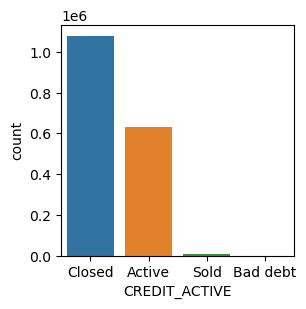

In [58]:
plt.figure(figsize=(3,3))
ax = sns.countplot(x= filtered_bureau_data["CREDIT_ACTIVE"], order = filtered_bureau_data["CREDIT_ACTIVE"].value_counts().index)


##### Number of Active Loans

In [62]:
active_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Active")].groupby("SK_ID_CURR").count())
active_loan.rename(columns={"CREDIT_ACTIVE": "NUM_ACTIVE_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_ACTIVE_LOANS
active_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Sold Loans

In [63]:
sold_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Sold")].groupby("SK_ID_CURR").count())
sold_loan.rename(columns={"CREDIT_ACTIVE": "NUM_SOLD_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_SOLD_LOANS
sold_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Bad Debt Loans

In [64]:
# Create new column to count number of bad debt loans using num_loan_dataset
bad_debt_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Bad debt")].groupby("SK_ID_CURR").count())
bad_debt_loan.rename(columns={"CREDIT_ACTIVE": "NUM_BAD_DEBT_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_BAD_DEBT_LOANS
bad_debt_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Closed Loans

In [65]:
closed_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Closed")].groupby("SK_ID_CURR").count())
closed_loan.rename(columns={"CREDIT_ACTIVE": "NUM_CLOSED_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_CLOSED_LOANS
closed_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Combine Different Types of Loans

In [66]:
num_loan_dataset = pd.merge(active_loan, sold_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset = pd.merge(num_loan_dataset, bad_debt_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset = pd.merge(num_loan_dataset, closed_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset.fillna(0, inplace=True)

num_loan_dataset

NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  NUM_BAD_DEBT_LOANS  \
SK_ID_CURR                                                         
100001                  3.00            0.00                0.00   
100002                  2.00            0.00                0.00   
100003                  1.00            0.00                0.00   
100005                  2.00            0.00                0.00   
100008                  1.00            0.00                0.00   
...                      ...             ...                 ...   
456185                  0.00            0.00                0.00   
456191                  0.00            0.00                0.00   
456197                  0.00            0.00                0.00   
456237                  0.00            0.00                0.00   
456254                  0.00            0.00                0.00   

            NUM_CLOSED_LOANS  
SK_ID_CURR                    
100001                  4.00  
100002                  6.00  
100003                  3.00  
100005                  1.00  
100008                  2.00  
...                      ...  
456185                  5.00  
456191                  3.00  
456197                  7.00  
456237                  1.00  
456254                  1.00  

[305811 rows x 4 columns]

#### Extracting Average Values for Other Variables for each SK_ID_CURR

In [67]:
avg_bureau_data = filtered_bureau_data.drop("CREDIT_ACTIVE", axis=1).groupby("SK_ID_CURR").mean()
avg_bureau_data.rename(columns={"AMT_CREDIT_MAX_OVERDUE":"AVG_AMT_CREDIT_MAX_OVERDUE","CNT_CREDIT_PROLONG":"AVG_CNT_CREDIT_PROLONG","AMT_CREDIT_SUM": "AVG_AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT": "AVG_AMT_CREDIT_SUM_DEBT","AMT_CREDIT_SUM_LIMIT":"AVG_AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE": "AVG_AMT_CREDIT_SUM_OVERDUE"}, inplace=True)
avg_bureau_data

AVG_AMT_CREDIT_MAX_OVERDUE  AVG_CNT_CREDIT_PROLONG  \
SK_ID_CURR                                                       
100001                             NaN                    0.00   
100002                         1681.03                    0.00   
100003                            0.00                    0.00   
100004                            0.00                    0.00   
100005                            0.00                    0.00   
...                                ...                     ...   
456249                         6147.00                    0.00   
456250                            0.00                    0.00   
456253                             NaN                    0.00   
456254                             NaN                    0.00   
456255                        12056.48                    0.09   

            AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
SK_ID_CURR                                                
100001               207623.57                 85240.93   
100002               108131.95                 49156.20   
100003               254350.12                     0.00   
100004                94518.90                     0.00   
100005               219042.00                189469.50   
...                        ...                      ...   
456249               284142.97                 16307.10   
456250              1028819.85                744013.36   
456253               990000.00                448958.25   
456254                45000.00                     0.00   
456255               345629.05                191864.13   

            AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  
SK_ID_CURR                                                        
100001                          0.00                        0.00  
100002                       7997.14                        0.00  
100003                     202500.00                        0.00  
100004                          0.00                        0.00  
100005                          0.00                        0.00  
...                              ...                         ...  
456249                          0.00                        0.00  
456250                      19422.80                        0.00  
456253                          0.00                        0.00  
456254                           NaN                        0.00  
456255                          0.00                        0.00  

[305811 rows x 6 columns]

#### Combining all extracted variables for Bureau Data according to SK_ID_CURR

In [68]:
aggregated_credit_bureau_data = pd.merge(avg_bureau_data, num_loan_dataset,on="SK_ID_CURR")
aggregated_credit_bureau_data

AVG_AMT_CREDIT_MAX_OVERDUE  AVG_CNT_CREDIT_PROLONG  \
SK_ID_CURR                                                       
100001                             NaN                    0.00   
100002                         1681.03                    0.00   
100003                            0.00                    0.00   
100004                            0.00                    0.00   
100005                            0.00                    0.00   
...                                ...                     ...   
456249                         6147.00                    0.00   
456250                            0.00                    0.00   
456253                             NaN                    0.00   
456254                             NaN                    0.00   
456255                        12056.48                    0.09   

            AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
SK_ID_CURR                                                
100001               207623.57                 85240.93   
100002               108131.95                 49156.20   
100003               254350.12                     0.00   
100004                94518.90                     0.00   
100005               219042.00                189469.50   
...                        ...                      ...   
456249               284142.97                 16307.10   
456250              1028819.85                744013.36   
456253               990000.00                448958.25   
456254                45000.00                     0.00   
456255               345629.05                191864.13   

            AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  \
SK_ID_CURR                                                         
100001                          0.00                        0.00   
100002                       7997.14                        0.00   
100003                     202500.00                        0.00   
100004                          0.00                        0.00   
100005                          0.00                        0.00   
...                              ...                         ...   
456249                          0.00                        0.00   
456250                      19422.80                        0.00   
456253                          0.00                        0.00   
456254                           NaN                        0.00   
456255                          0.00                        0.00   

            NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  NUM_BAD_DEBT_LOANS  \
SK_ID_CURR                                                         
100001                  3.00            0.00                0.00   
100002                  2.00            0.00                0.00   
100003                  1.00            0.00                0.00   
100004                  0.00            0.00                0.00   
100005                  2.00            0.00                0.00   
...                      ...             ...                 ...   
456249                  2.00            0.00                0.00   
456250                  2.00            0.00                0.00   
456253                  2.00            0.00                0.00   
456254                  0.00            0.00                0.00   
456255                  5.00            0.00                0.00   

            NUM_CLOSED_LOANS  
SK_ID_CURR                    
100001                  4.00  
100002                  6.00  
100003                  3.00  
100004                  2.00  
100005                  1.00  
...                      ...  
456249                 11.00  
456250                  1.00  
456253                  2.00  
456254                  1.00  
456255                  6.00  

[305811 rows x 10 columns]

## Merge Application & Bureau Data for EDA

In [69]:
unclean_merged_data = filtered_app_data.merge(aggregated_credit_bureau_data, how="left", on="SK_ID_CURR")
unclean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   FLAG_OWN_CAR                 307511 non-null  object 
 3   FLAG_OWN_REALTY              307511 non-null  object 
 4   CNT_CHILDREN                 307511 non-null  int64  
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_ANNUITY                  307499 non-null  float64
 8   AMT_GOODS_PRICE              307233 non-null  float64
 9   NAME_INCOME_TYPE             307511 non-null  object 
 10  NAME_EDUCATION_TYPE          307511 non-null  object 
 11  NAME_FAMILY_STATUS           307511 non-null  object 
 12  NAME_HOUSING_TYPE            307511 non-null  object 
 13 

## 1. Data Exploration

## 1.1 Verify Customer Segment
Ensure sufficient observations and understand relevant distribution

##### Organization Type Distribution

[Text(0, 0, 'Business Entity Type 3'),
 Text(1, 0, 'XNA'),
 Text(2, 0, 'Self-employed'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'Medicine'),
 Text(5, 0, 'Business Entity Type 2'),
 Text(6, 0, 'Government'),
 Text(7, 0, 'School'),
 Text(8, 0, 'Trade: type 7'),
 Text(9, 0, 'Kindergarten'),
 Text(10, 0, 'Construction'),
 Text(11, 0, 'Business Entity Type 1'),
 Text(12, 0, 'Transport: type 4'),
 Text(13, 0, 'Trade: type 3'),
 Text(14, 0, 'Industry: type 9'),
 Text(15, 0, 'Industry: type 3'),
 Text(16, 0, 'Security'),
 Text(17, 0, 'Housing'),
 Text(18, 0, 'Industry: type 11'),
 Text(19, 0, 'Military'),
 Text(20, 0, 'Bank'),
 Text(21, 0, 'Agriculture'),
 Text(22, 0, 'Police'),
 Text(23, 0, 'Transport: type 2'),
 Text(24, 0, 'Postal'),
 Text(25, 0, 'Security Ministries'),
 Text(26, 0, 'Trade: type 2'),
 Text(27, 0, 'Restaurant'),
 Text(28, 0, 'Services'),
 Text(29, 0, 'University'),
 Text(30, 0, 'Industry: type 7'),
 Text(31, 0, 'Transport: type 3'),
 Text(32, 0, 'Industry: type 1'),
 Text(33, 0, 

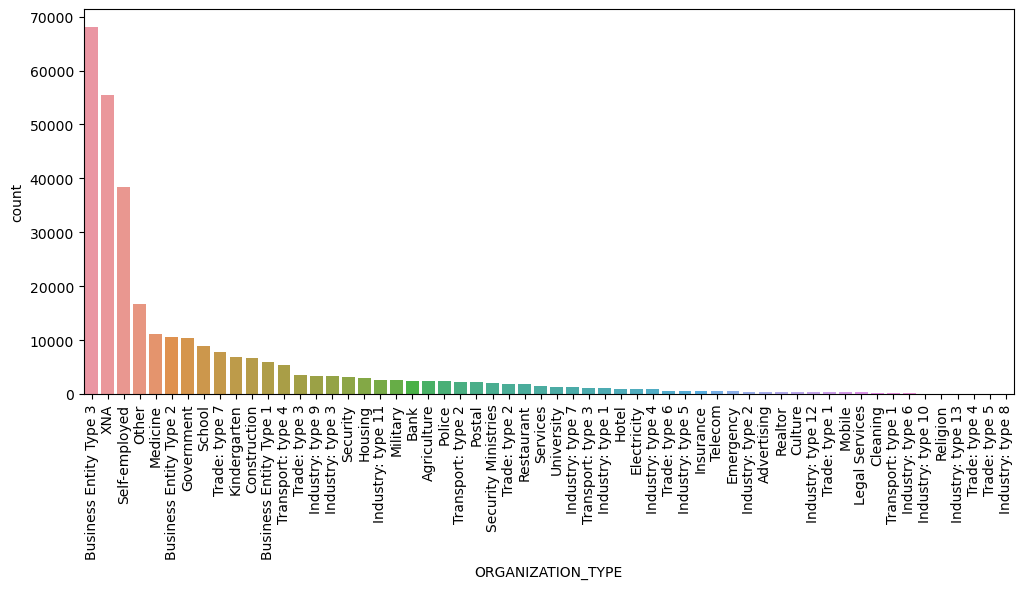

In [16]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x= unclean_merged_data['ORGANIZATION_TYPE'], order = unclean_merged_data['ORGANIZATION_TYPE'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

##### Organization Type Distribution of Events and Non-events

TARGET                    0    1
ORGANIZATION_TYPE               
Advertising            0.92 0.08
Agriculture            0.90 0.10
Bank                   0.95 0.05
Business Entity Type 1 0.92 0.08
Business Entity Type 2 0.91 0.09
Business Entity Type 3 0.91 0.09
Cleaning               0.89 0.11
Construction           0.88 0.12
Culture                0.94 0.06
Electricity            0.93 0.07
Emergency              0.93 0.07
Government             0.93 0.07
Hotel                  0.94 0.06
Housing                0.92 0.08
Industry: type 1       0.89 0.11
Industry: type 10      0.94 0.06
Industry: type 11      0.91 0.09
Industry: type 12      0.96 0.04
Industry: type 13      0.87 0.13
Industry: type 2       0.93 0.07
Industry: type 3       0.89 0.11
Industry: type 4       0.90 0.10
Industry: type 5       0.93 0.07
Industry: type 6       0.93 0.07
Industry: type 7       0.92 0.08
Industry: type 8       0.88 0.12
Industry: type 9       0.93 0.07
Insurance              0.94 0.06
Kindergart

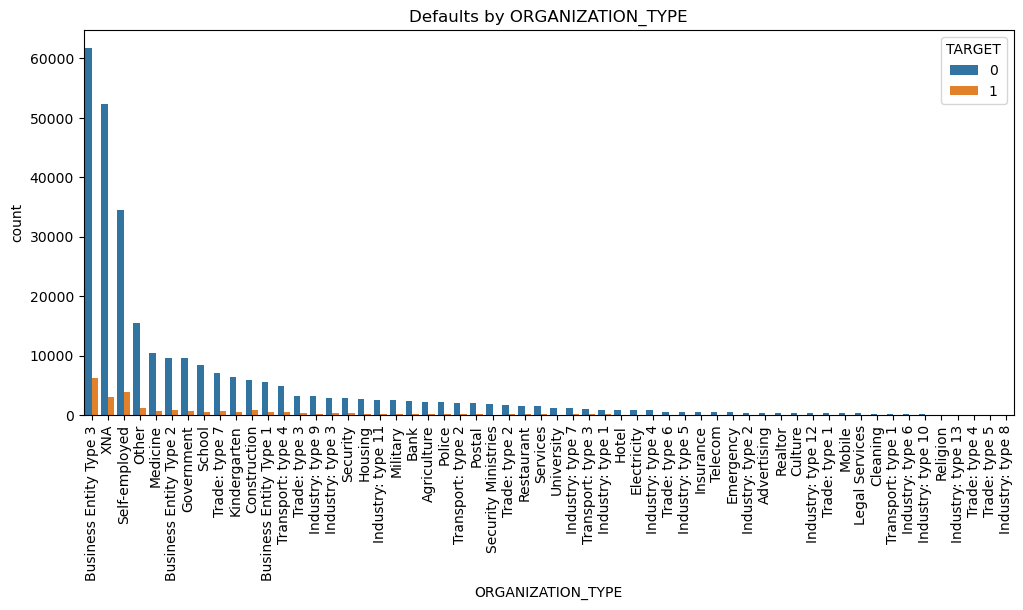

In [17]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x= unclean_merged_data['ORGANIZATION_TYPE'], hue=unclean_merged_data['TARGET'], order = unclean_merged_data['ORGANIZATION_TYPE'].value_counts().index)
plt.title('Defaults by ORGANIZATION_TYPE')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


print(unclean_merged_data.groupby("ORGANIZATION_TYPE")["TARGET"].value_counts(normalize = True).unstack())

## EDA FOR SELF-EMPLOYED

#### Filter Applicants Organization Type by Self-Employed

In [18]:
# extract selected columns and filter by self-employed
unclean_merged_data = unclean_merged_data[unclean_merged_data['ORGANIZATION_TYPE'] == 'Self-employed']
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
13          100017       0            Y               N             1   
20          100024       0            Y               Y             0   
22          100026       0            N               N             1   
33          100039       0            Y               N             1   
35          100041       0            N               N             0   
...            ...     ...          ...             ...           ...   
307491      456235       0            Y               Y             2   
307492      456236       0            Y               Y             0   
307494      456238       0            Y               N             1   
307496      456240       0            N               N             0   
307504      456248       0            N               Y             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
13             225000.00   918468.00     28966.50        697500.00   
20             135000.00   427500.00     21375.00        427500.00   
22             450000.00   497520.00     32521.50        450000.00   
33             360000.00   733315.50     39069.00        679500.00   
35             112500.00   450000.00     44509.50        450000.00   
...                  ...         ...          ...              ...   
307491          90000.00  1078200.00     31522.50        900000.00   
307492         585000.00  1575000.00     43443.00       1575000.00   
307494         270000.00   479700.00     46858.50        450000.00   
307496         360000.00   337500.00     16875.00        337500.00   
307504         153000.00   331920.00     16096.50        225000.00   

            NAME_INCOME_TYPE  ... AVG_AMT_CREDIT_MAX_OVERDUE  \
13                   Working  ...                       0.00   
20                   Working  ...                        NaN   
22                   Working  ...                       0.00   
33      Commercial associate  ...                        NaN   
35                   Working  ...                     769.37   
...                      ...  ...                        ...   
307491  Commercial associate  ...                       0.00   
307492               Working  ...                    2805.55   
307494  Commercial associate  ...                    3191.74   
307496               Working  ...                    3996.00   
307504               Working  ...                        NaN   

       AVG_CNT_CREDIT_PROLONG AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
13                       0.00          143295.00                     0.00   
20                        NaN                NaN                      NaN   
22                       0.00         1875000.00               1738907.19   
33                       0.00          498788.00                348392.57   
35                       0.00           63254.24                     0.00   
...                       ...                ...                      ...   
307491                   0.00          493050.00                386679.00   
307492                   0.00          638975.60                442079.68   
307494                   0.00          184917.00                104225.25   
307496                   0.00           66199.50                 39872.25   
307504                    NaN                NaN                      NaN   

        AVG_AMT_CREDIT_SUM_LIMIT AVG_AMT_CREDIT_SUM_OVERDUE  NUM_ACTIVE_LOANS  \
13                          0.00                       0.00              0.00   
20                           NaN                        NaN               NaN   
22                          0.00                       0.00              2.00   
33                          0.00                       0.00              3.00   
35                          0.00                       0.00              1.00   
...                          ...                        ...               ...   
307491                      0

##### Age Distribution

<Axes: xlabel='AGE', ylabel='count'>

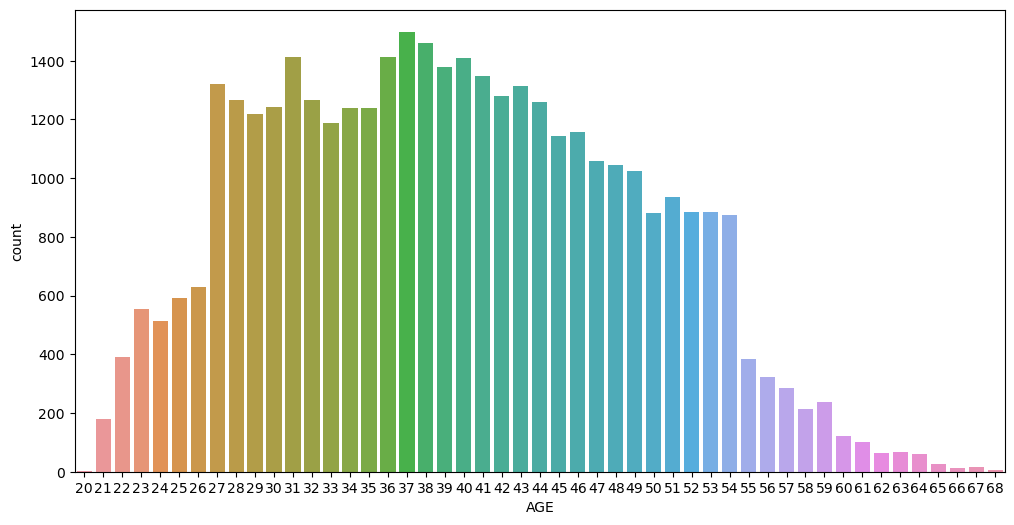

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x=unclean_merged_data["AGE"],orient='h')

##### Age Distribution of Events and Non-events

TARGET    0    1
AGE             
20     1.00  NaN
21     0.87 0.13
22     0.83 0.17
23     0.84 0.16
24     0.86 0.14
25     0.89 0.11
26     0.88 0.12
27     0.85 0.15
28     0.87 0.13
29     0.89 0.11
30     0.88 0.12
31     0.88 0.12
32     0.89 0.11
33     0.89 0.11
34     0.89 0.11
35     0.88 0.12
36     0.91 0.09
37     0.90 0.10
38     0.91 0.09
39     0.90 0.10
40     0.91 0.09
41     0.90 0.10
42     0.92 0.08
43     0.92 0.08
44     0.90 0.10
45     0.91 0.09
46     0.92 0.08
47     0.91 0.09
48     0.91 0.09
49     0.92 0.08
50     0.91 0.09
51     0.92 0.08
52     0.92 0.08
53     0.92 0.08
54     0.92 0.08
55     0.92 0.08
56     0.91 0.09
57     0.90 0.10
58     0.94 0.06
59     0.94 0.06
60     0.93 0.07
61     0.96 0.04
62     0.97 0.03
63     0.94 0.06
64     0.93 0.07
65     1.00  NaN
66     1.00  NaN
67     0.87 0.13
68     0.80 0.20


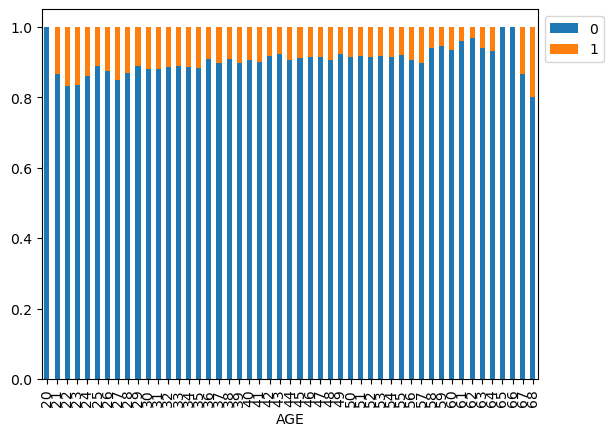

In [21]:
df_reason_bivariate = unclean_merged_data.groupby("AGE")['TARGET'].value_counts(normalize = True).unstack()
ax = df_reason_bivariate.plot(kind='bar', stacked='True')
ax.legend(bbox_to_anchor=(1.0, 1.0))

print(unclean_merged_data.groupby("AGE")["TARGET"].value_counts(normalize = True).unstack())

##### Filter Applicants by Age 21 - 35

In [22]:
# Select records with applicants aged between 18 and 35
unclean_merged_data = unclean_merged_data[(unclean_merged_data["AGE"] >= 21) & (unclean_merged_data["AGE"] <= 35)]

##### AMT_CREDIT Distribution

Text(0.5, 1.0, 'AMT_CREDIT')

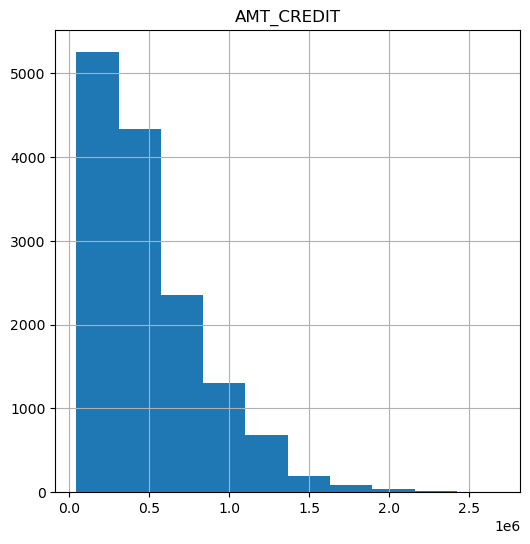

In [23]:
unclean_merged_data["AMT_CREDIT"].hist(figsize=(6,6))
plt.title("AMT_CREDIT")

##### AMT_CREDIT Distribution by Events and Non-events

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000.]),
 [Text(-500000.0, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(500000.0, 0, '0.5'),
  Text(1000000.0, 0, '1.0'),
  Text(1500000.0, 0, '1.5'),
  Text(2000000.0, 0, '2.0'),
  Text(2500000.0, 0, '2.5'),
  Text(3000000.0, 0, '3.0'),
  Text(3500000.0, 0, '3.5')])

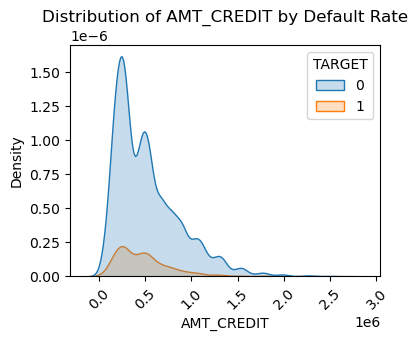

In [24]:
plt.figure(figsize=(4,3))
sns.kdeplot(data=unclean_merged_data, x="AMT_CREDIT", hue="TARGET", fill = True)
title = "Distribution of AMT_CREDIT by Default Rate"
plt.title(title)
plt.xticks(rotation=45)

##### Filter Applicants by Credit Amount < $500,000

In [25]:
# Select records with applicants aged between 18 and 35
unclean_merged_data = unclean_merged_data[(unclean_merged_data["AMT_CREDIT"] <=500000)]

### Sorting Out Remaining Numerical (Continuous & Discrete) & Categorical Data for Analysis

In [ ]:
num_cont_var = ["AMT_INCOME_TOTAL",
                "AMT_ANNUITY",
                "AMT_GOODS_PRICE",
                "REGION_POPULATION_RELATIVE",
                "EXT_SOURCE_1",
                "EXT_SOURCE_2",
                "EXT_SOURCE_3",
                "AVG_AMT_CREDIT_MAX_OVERDUE",
                "AVG_AMT_CREDIT_SUM",
                "AVG_AMT_CREDIT_SUM_DEBT",
                "AVG_AMT_CREDIT_SUM_OVERDUE",
                "AVG_AMT_CREDIT_SUM_LIMIT"]

num_disc_var = ["CNT_CHILDREN",
                "CNT_FAM_MEMBERS", 
                "OBS_30_CNT_SOCIAL_CIRCLE", 
                "DEF_30_CNT_SOCIAL_CIRCLE", 
                "OBS_60_CNT_SOCIAL_CIRCLE",
                "DEF_60_CNT_SOCIAL_CIRCLE",
                "AMT_REQ_CREDIT_BUREAU_HOUR",
                "AMT_REQ_CREDIT_BUREAU_DAY",
                "AMT_REQ_CREDIT_BUREAU_WEEK",
                "AMT_REQ_CREDIT_BUREAU_MON",
                "AMT_REQ_CREDIT_BUREAU_QRT",
                "AMT_REQ_CREDIT_BUREAU_YEAR",
                "NUM_ACTIVE_LOANS",
                "NUM_SOLD_LOANS",
                "NUM_BAD_DEBT_LOANS",
                "NUM_CLOSED_LOANS",
                "YEARS_REGISTERED",
                "YEARS_EMPLOYED",
                "YEARS_ID_PUBLISHED",
                "OWN_CAR_AGE",
                "AVG_CNT_CREDIT_PROLONG",]


cat_var = [ "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "REGION_RATING_CLIENT",
            "REGION_RATING_CLIENT_W_CITY"]

## 1.2 Univariate Analysis for Target Segment

#### Histogram - Continuous Numerical Variables 

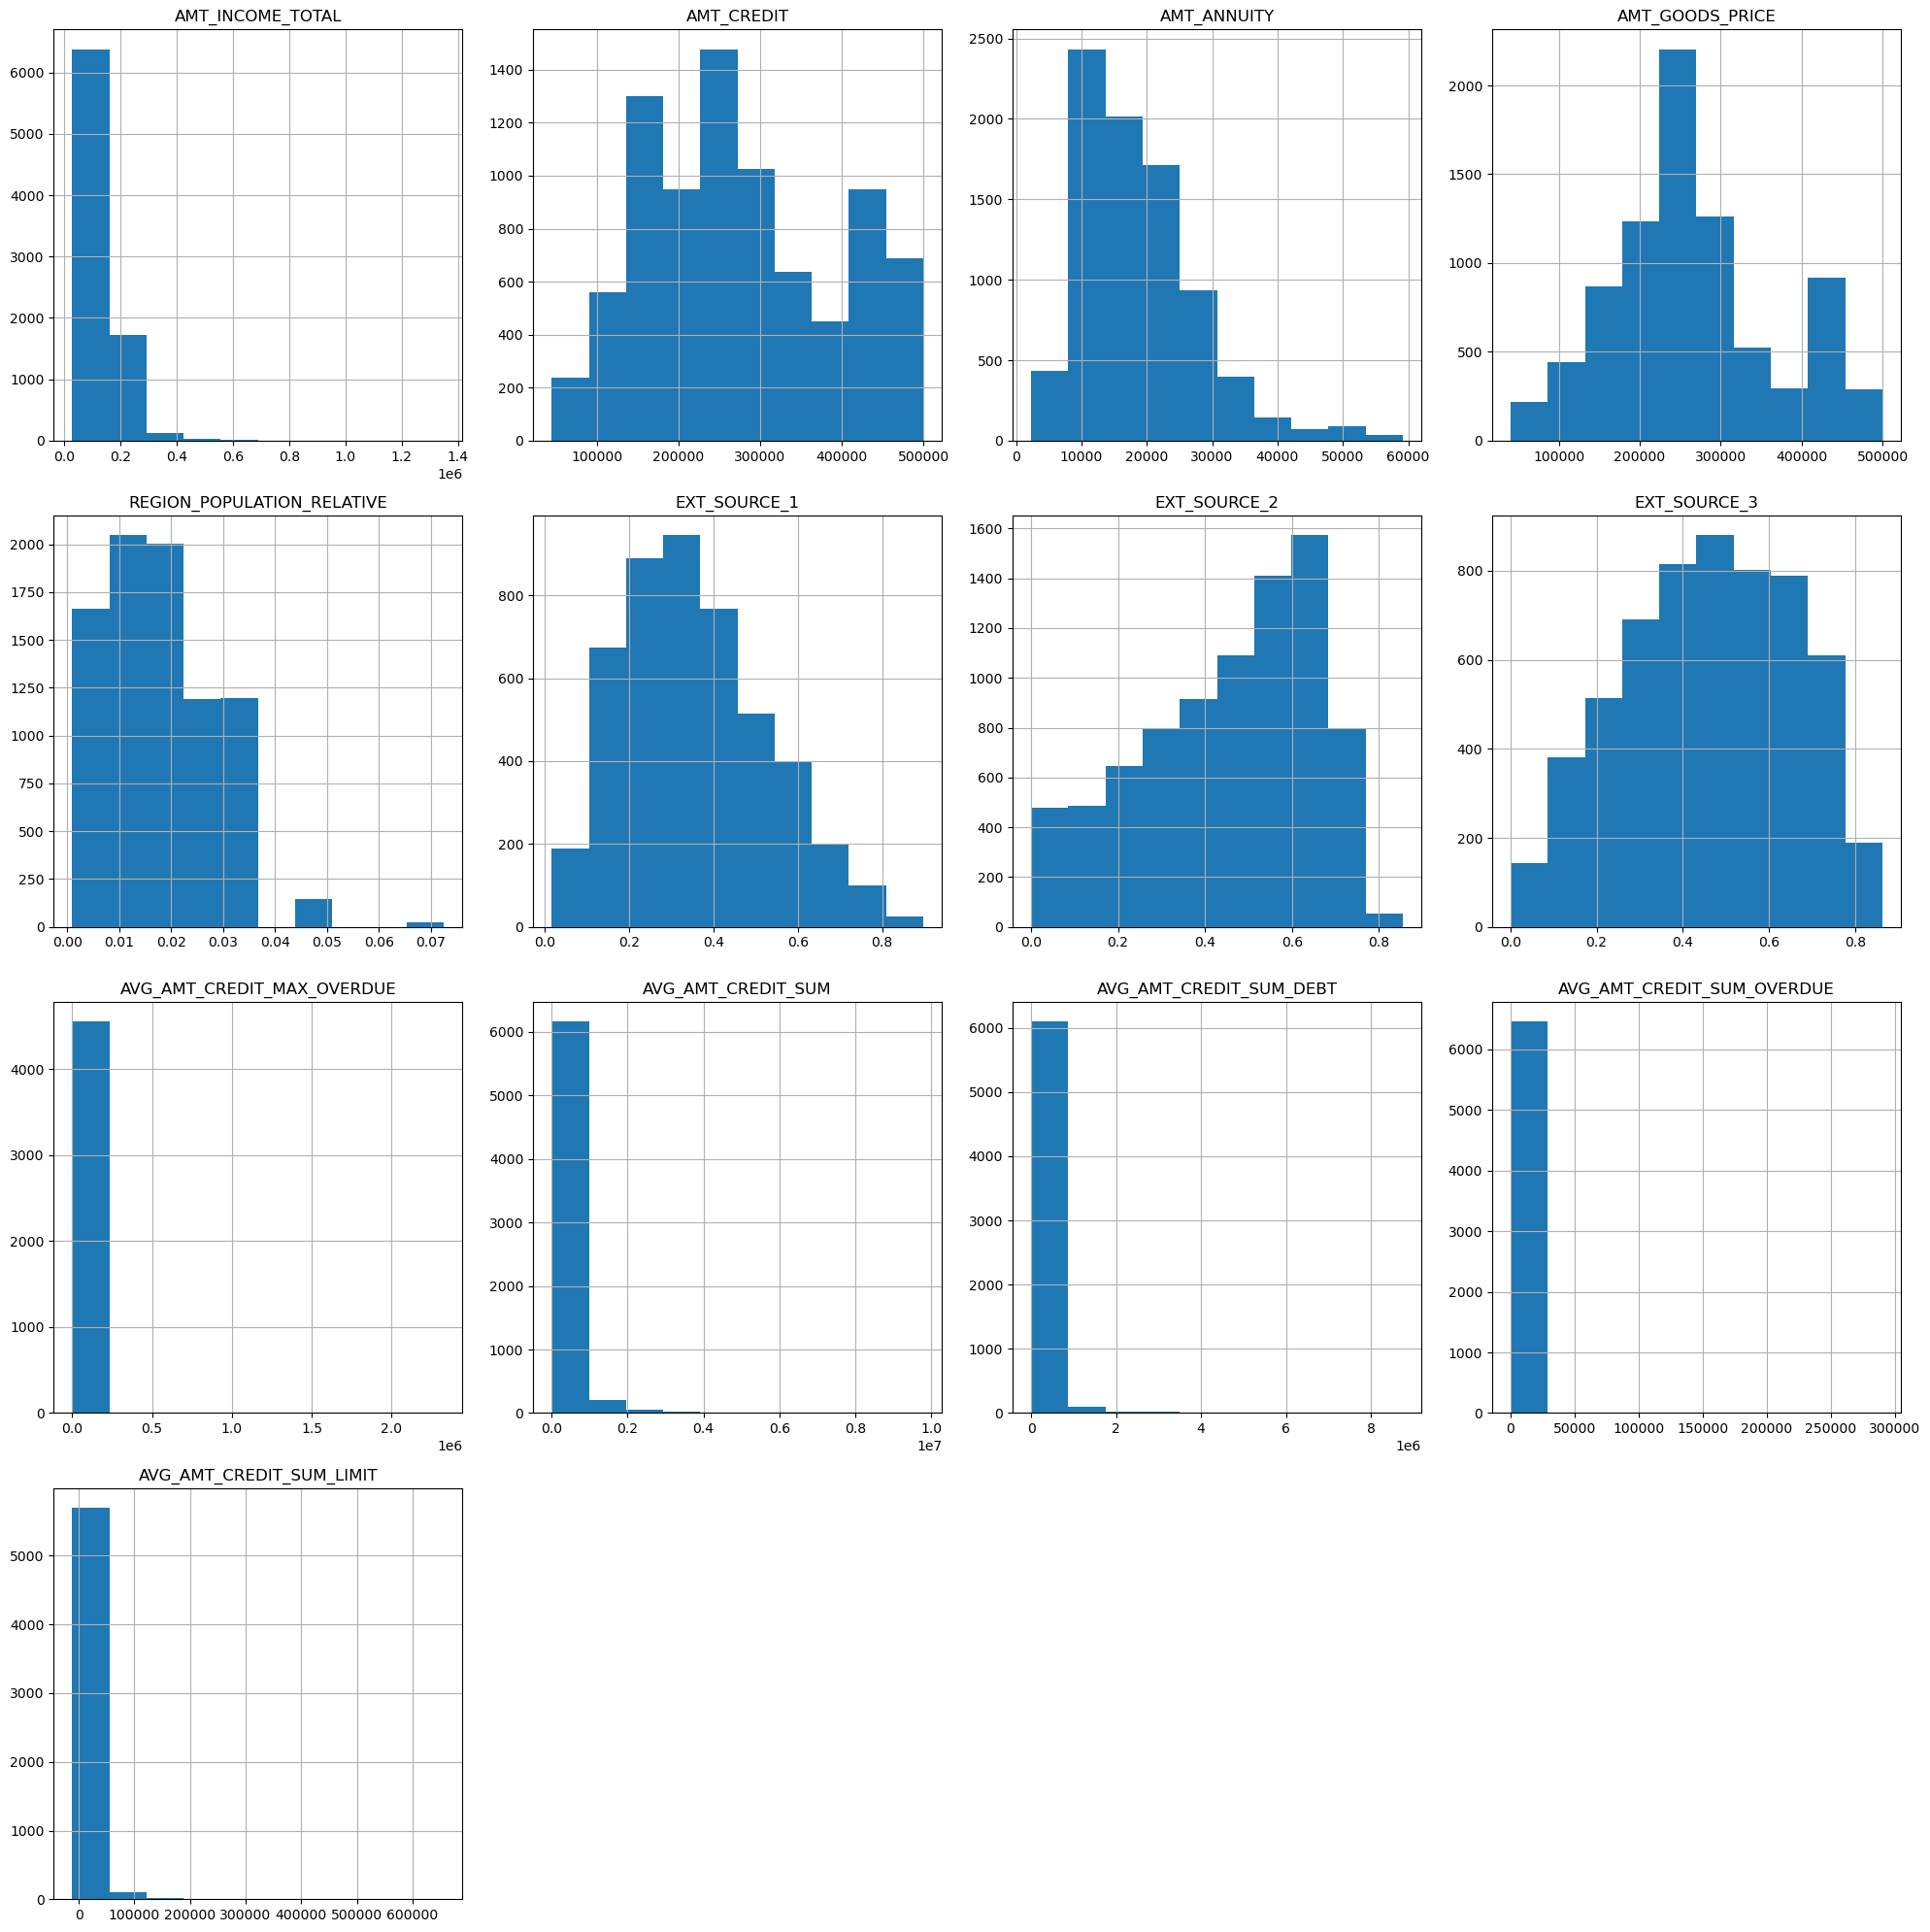

In [26]:
unclean_merged_data[num_cont_var].hist(figsize=(20,20))
plt.tight_layout()

#### Bar Chart - Discrete Numerical Variables

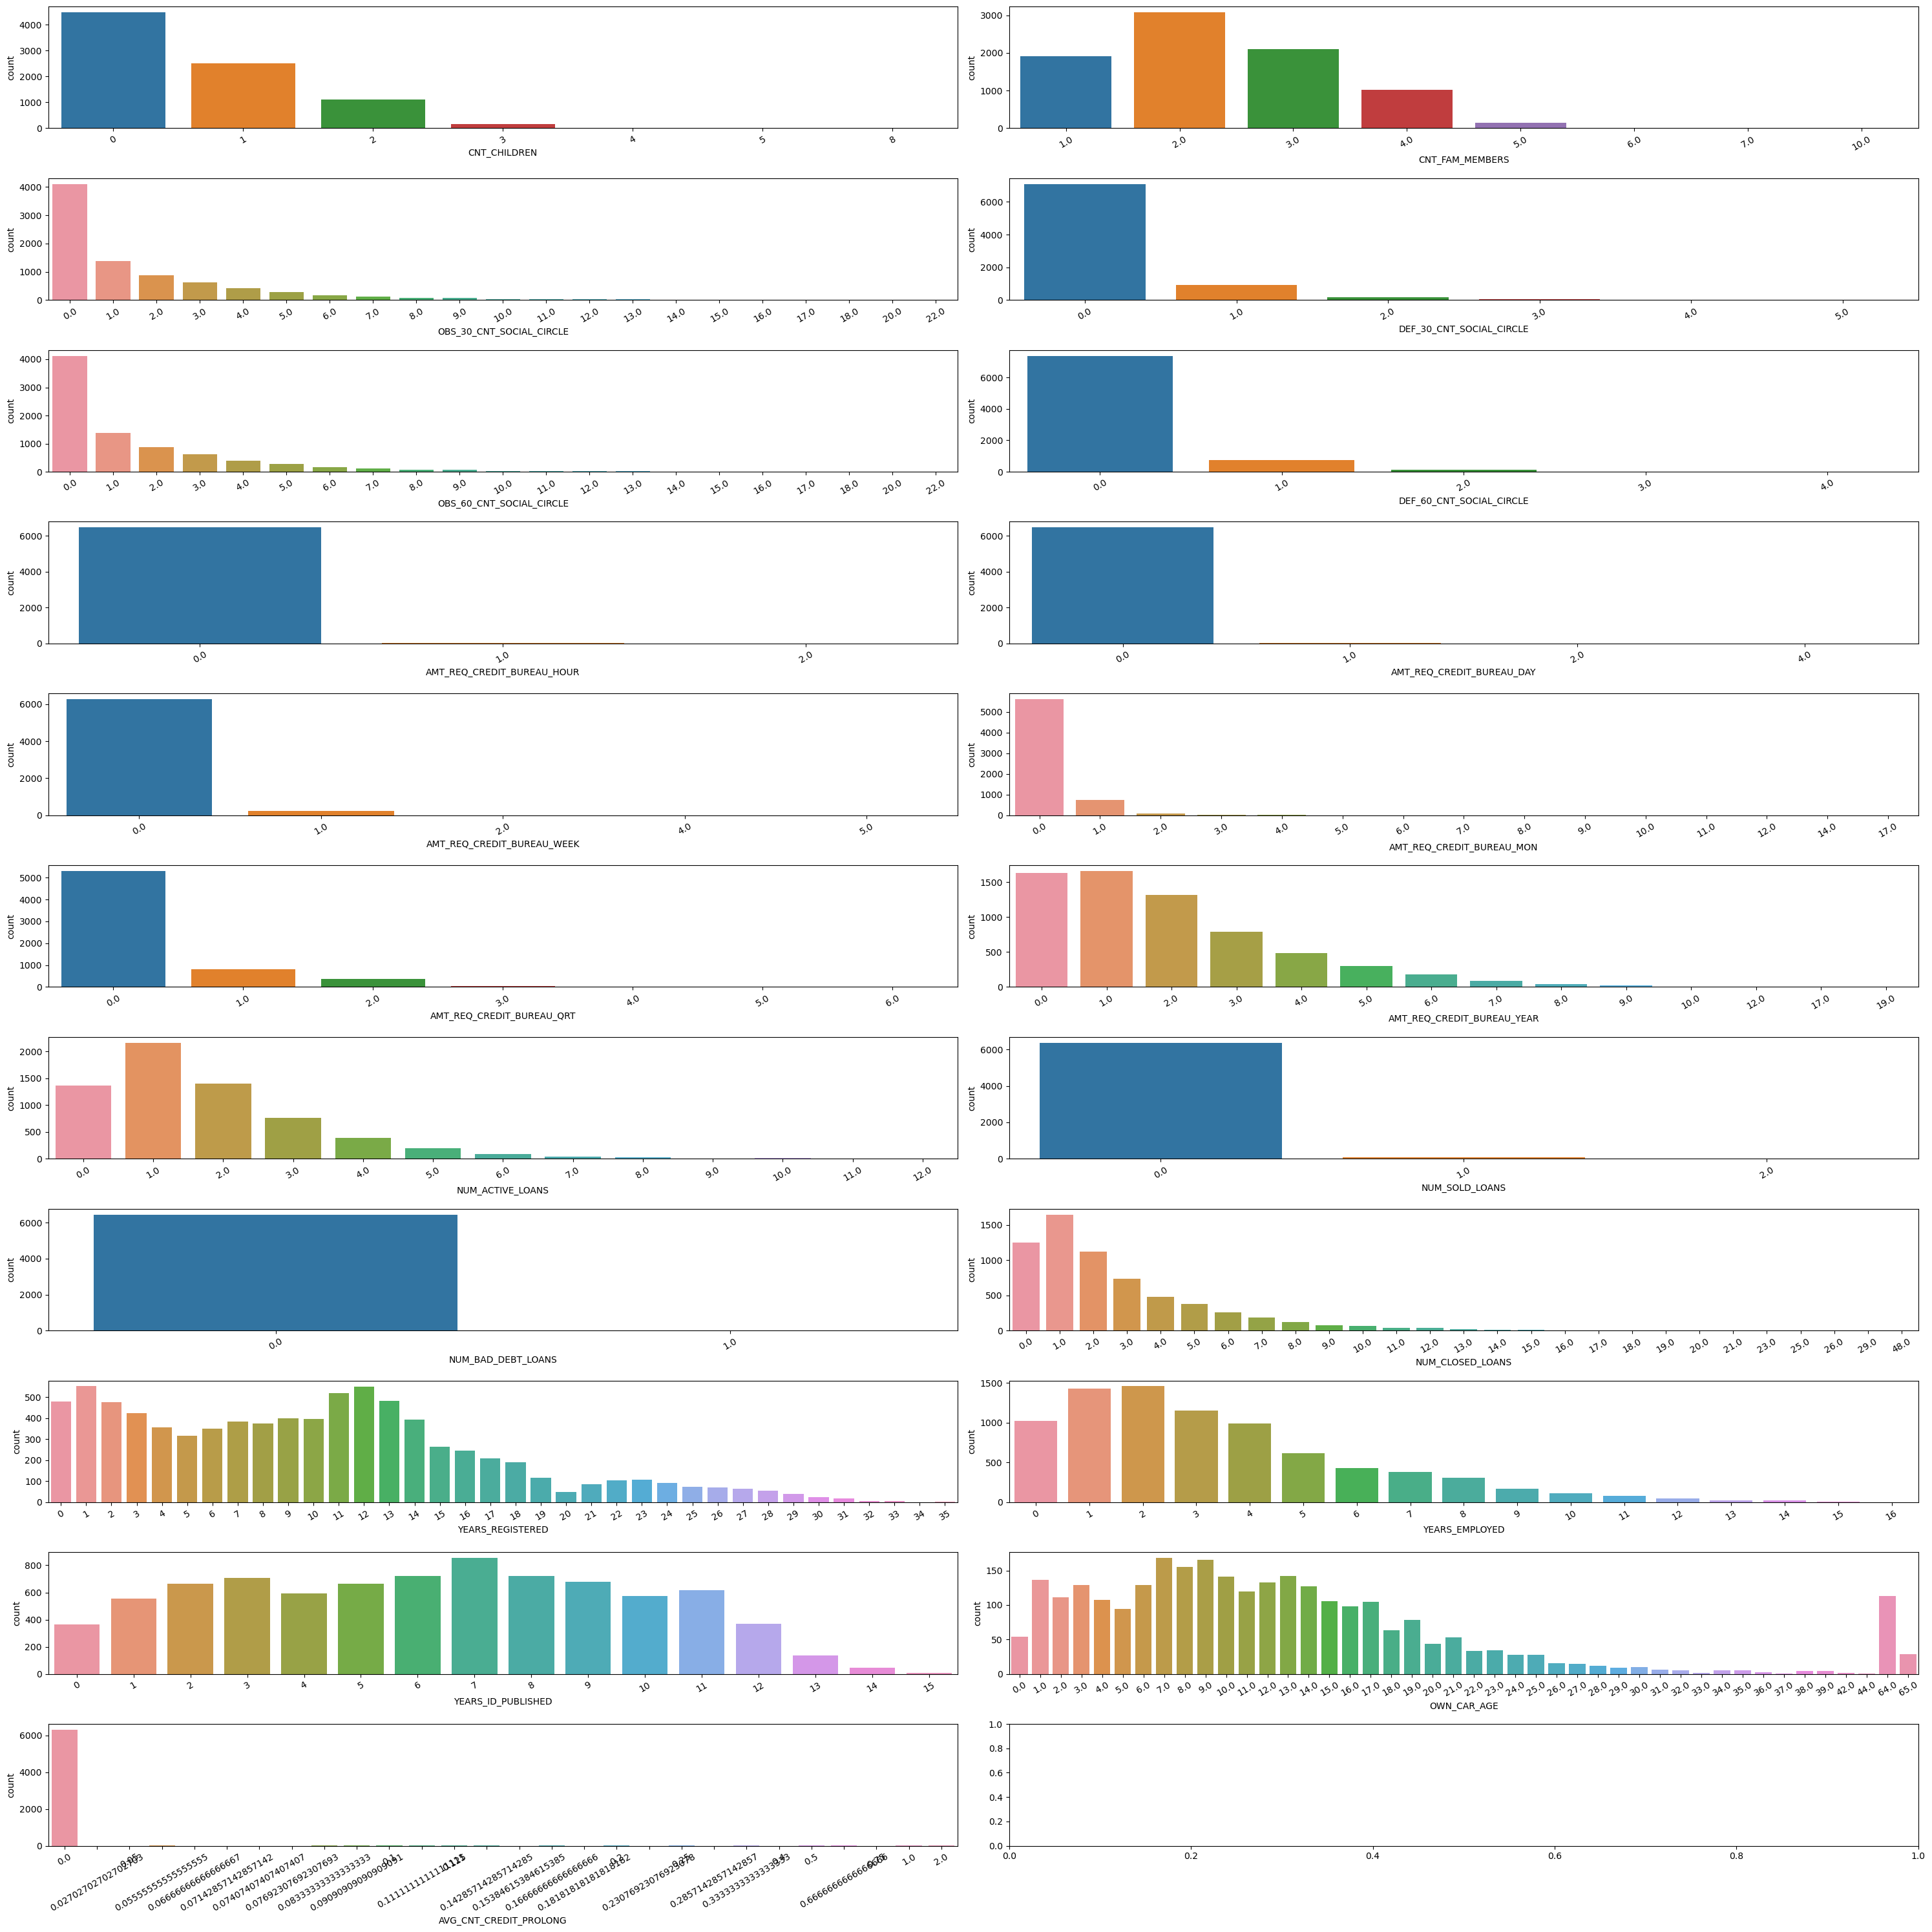

In [30]:
row_count=int(np.ceil(len(num_disc_var)/2))

fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(30,30))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x=unclean_merged_data[num_disc_var[i]],orient='h')
    axis.set_xlabel(str(num_disc_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=30)
    if i == len(num_disc_var)-1: 
         break

plt.tight_layout()

#### Bar Chart - Categorical Variables

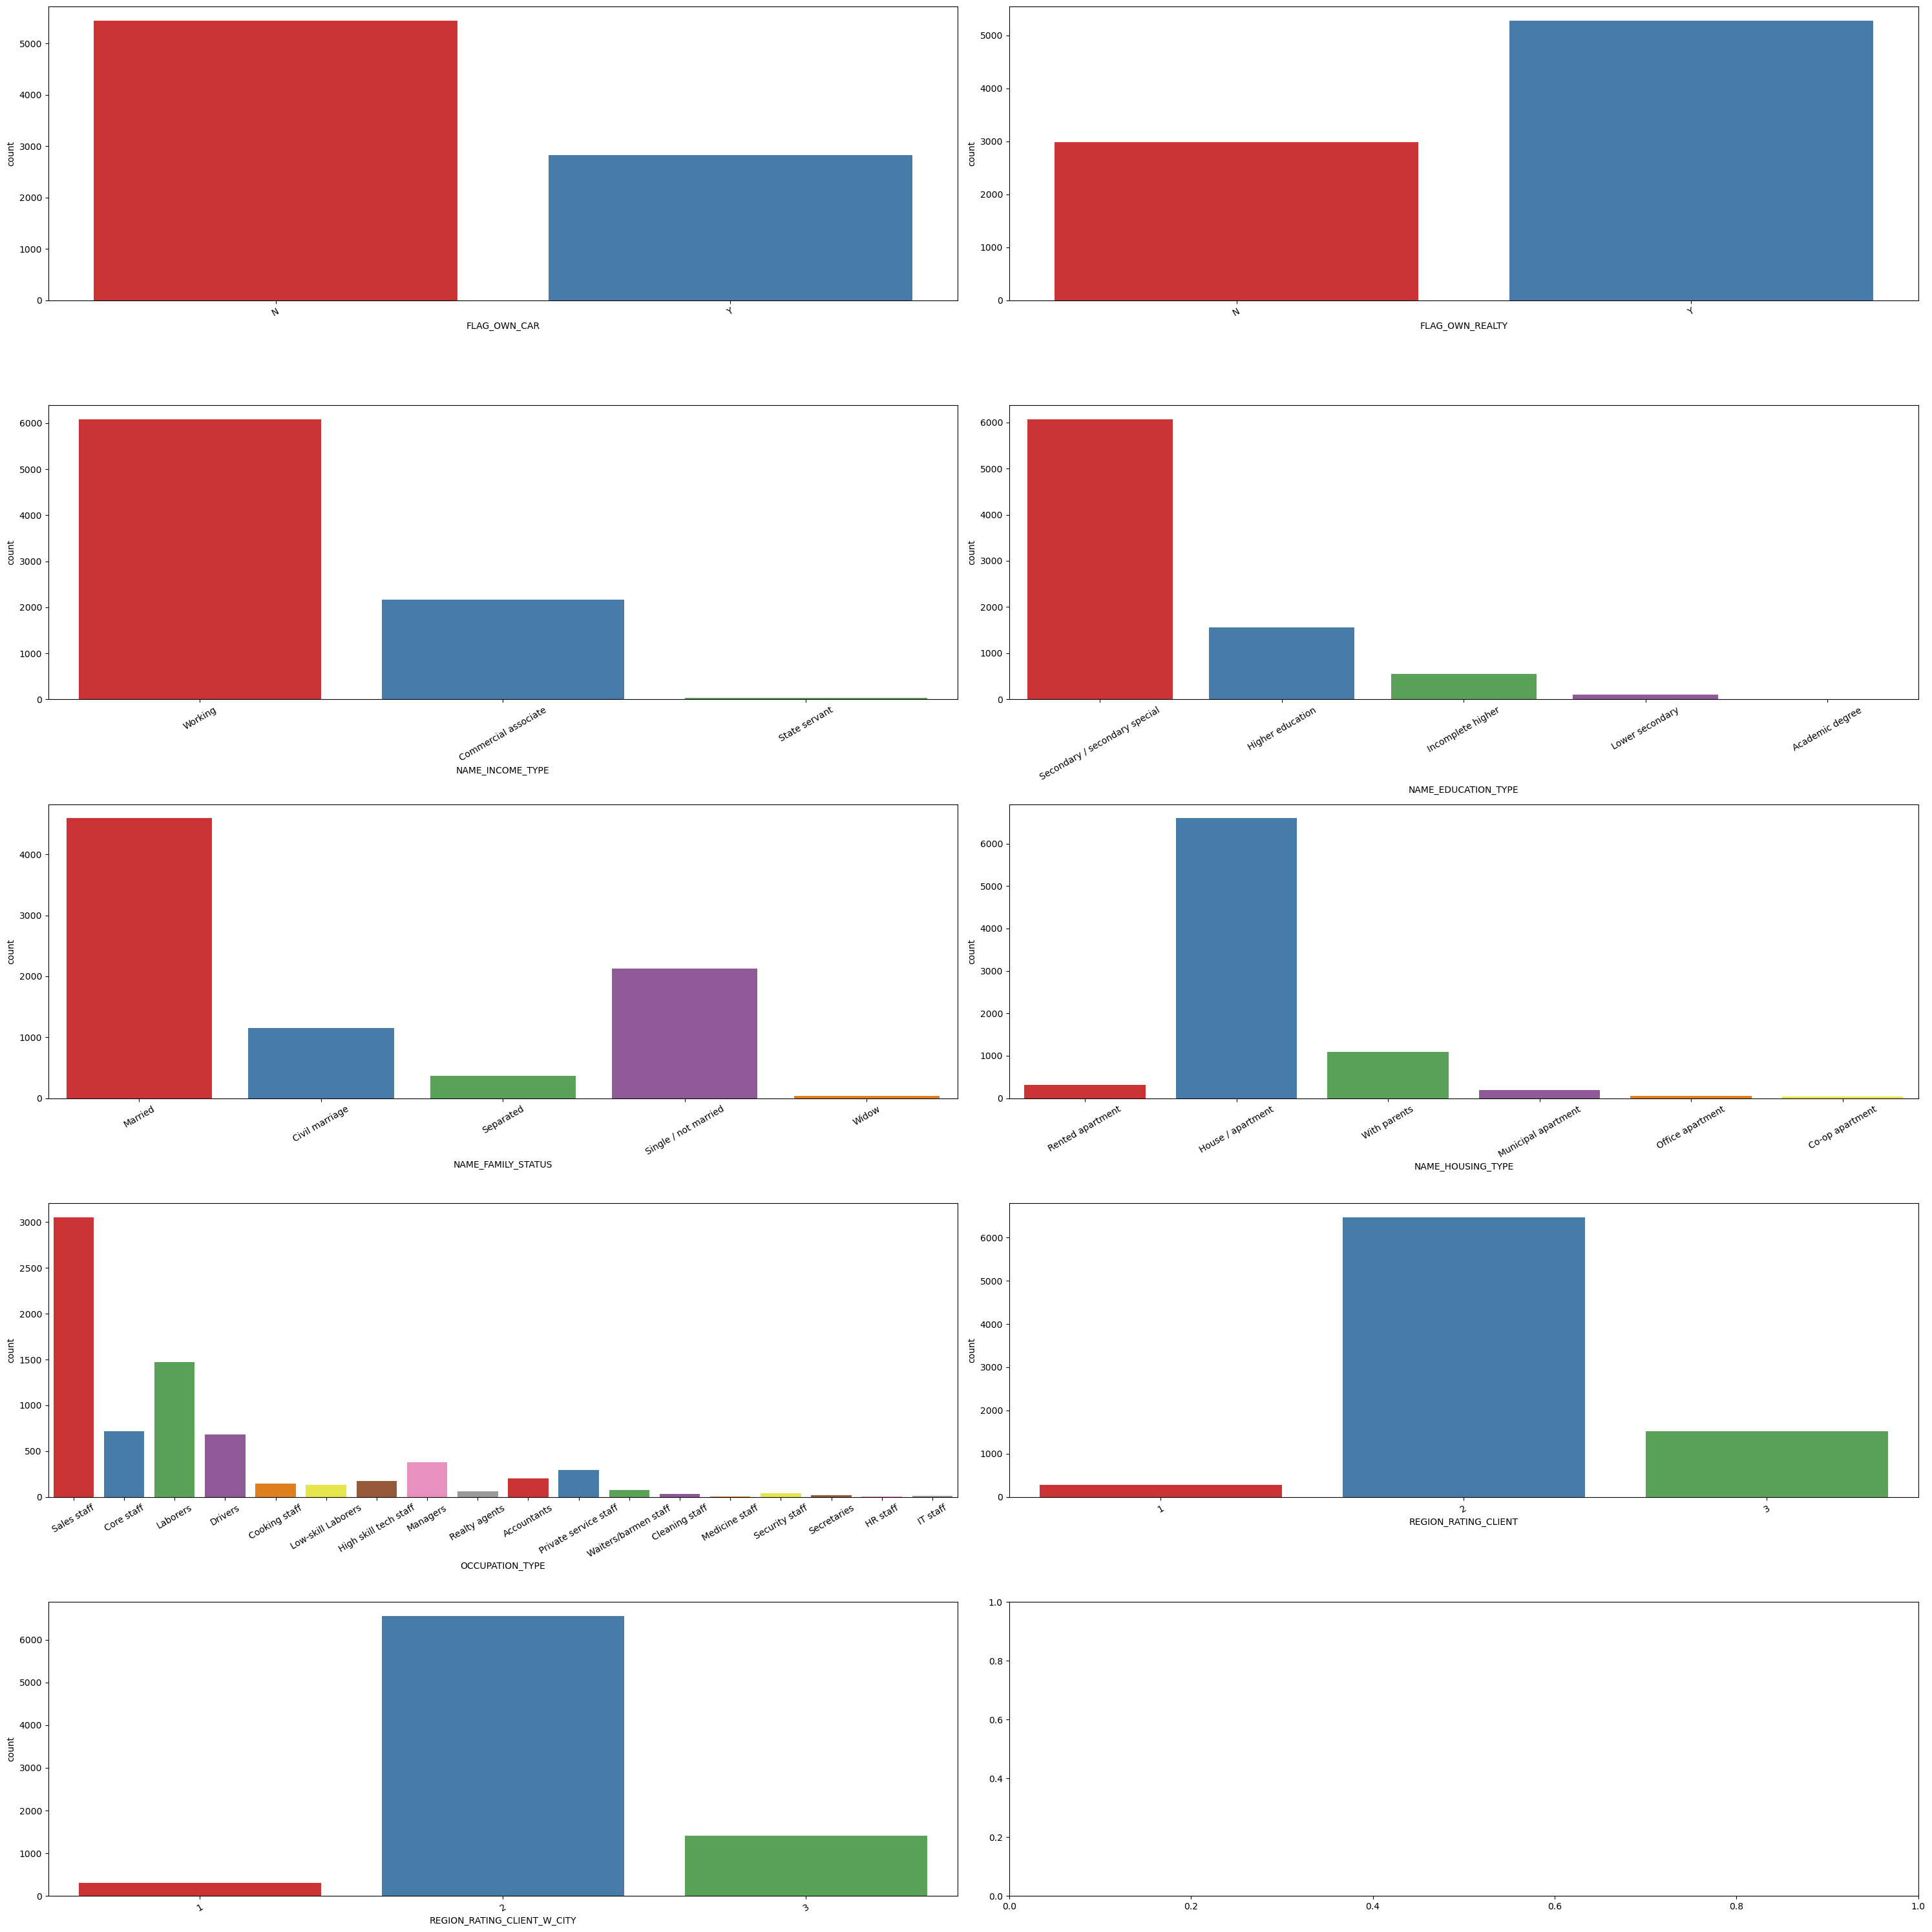

In [31]:
row_count=int(np.ceil(len(cat_var)/2))

fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(30,30))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x=unclean_merged_data[cat_var[i]],orient='h', palette="Set1")
    axis.set_xlabel(str(cat_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=30)
    if i == len(cat_var)-1: 
         break

plt.tight_layout()

## 1.3 Bivariate Analysis for Target Segment

#### KDE Plot - Continuous Numerical Variables 

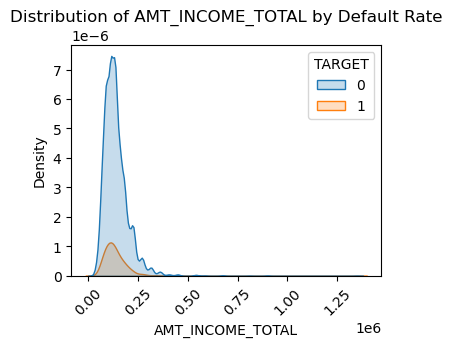

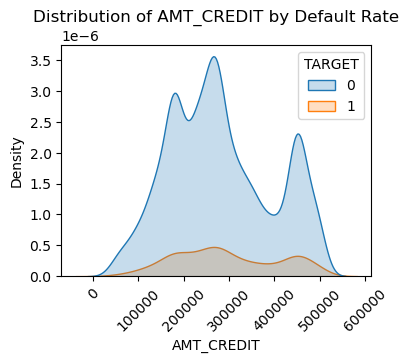

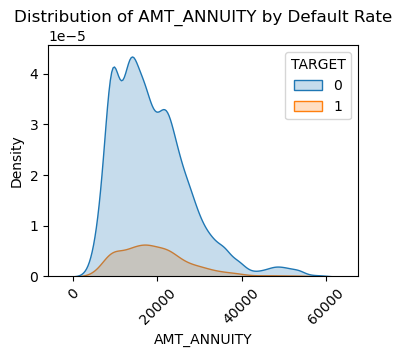

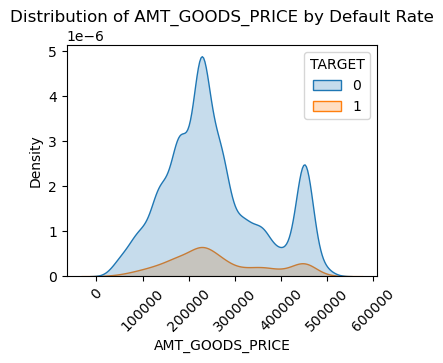

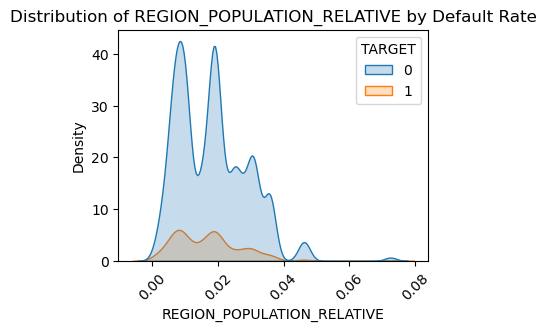

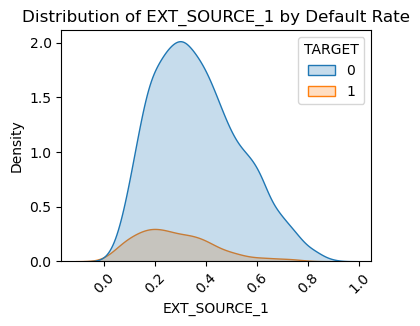

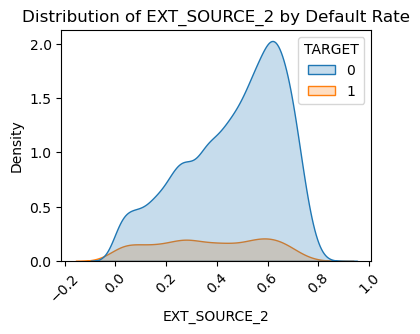

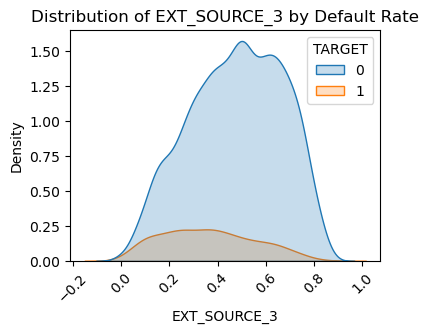

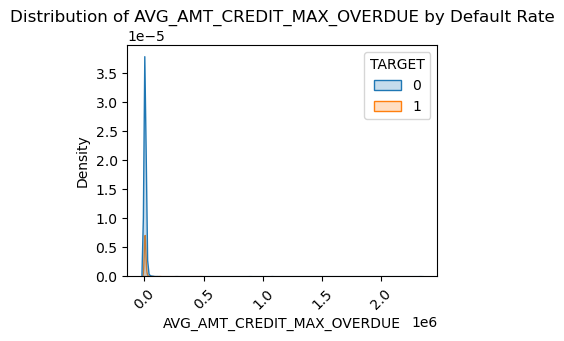

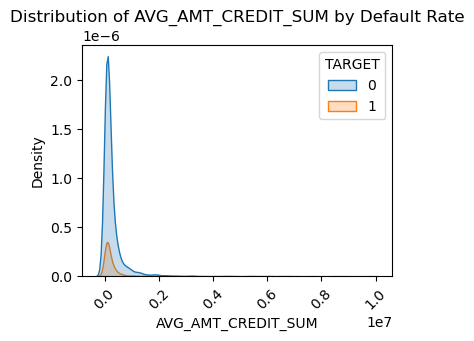

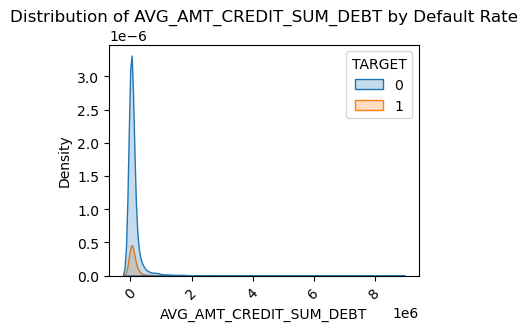

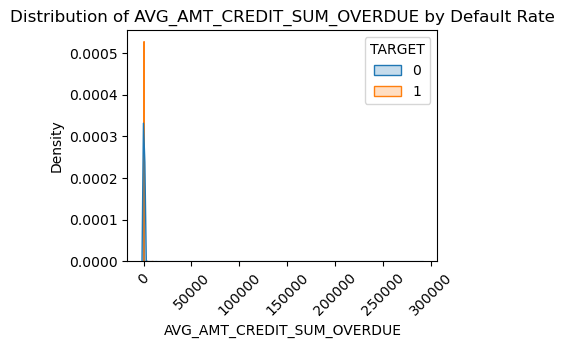

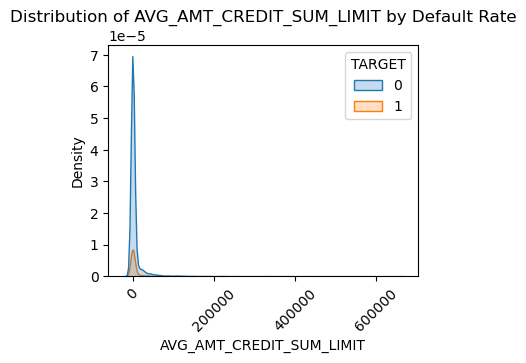

In [32]:
for i in range(len(num_cont_var)):
    plt.figure(figsize=(4,3))
    sns.kdeplot(data=unclean_merged_data, x=num_cont_var[i], hue="TARGET", fill = True)
    title = "Distribution of " + num_cont_var[i] + " by Default Rate"
    plt.title(title)
    plt.xticks(rotation=45)

#### Bar Charts - Discrete Numerical Data

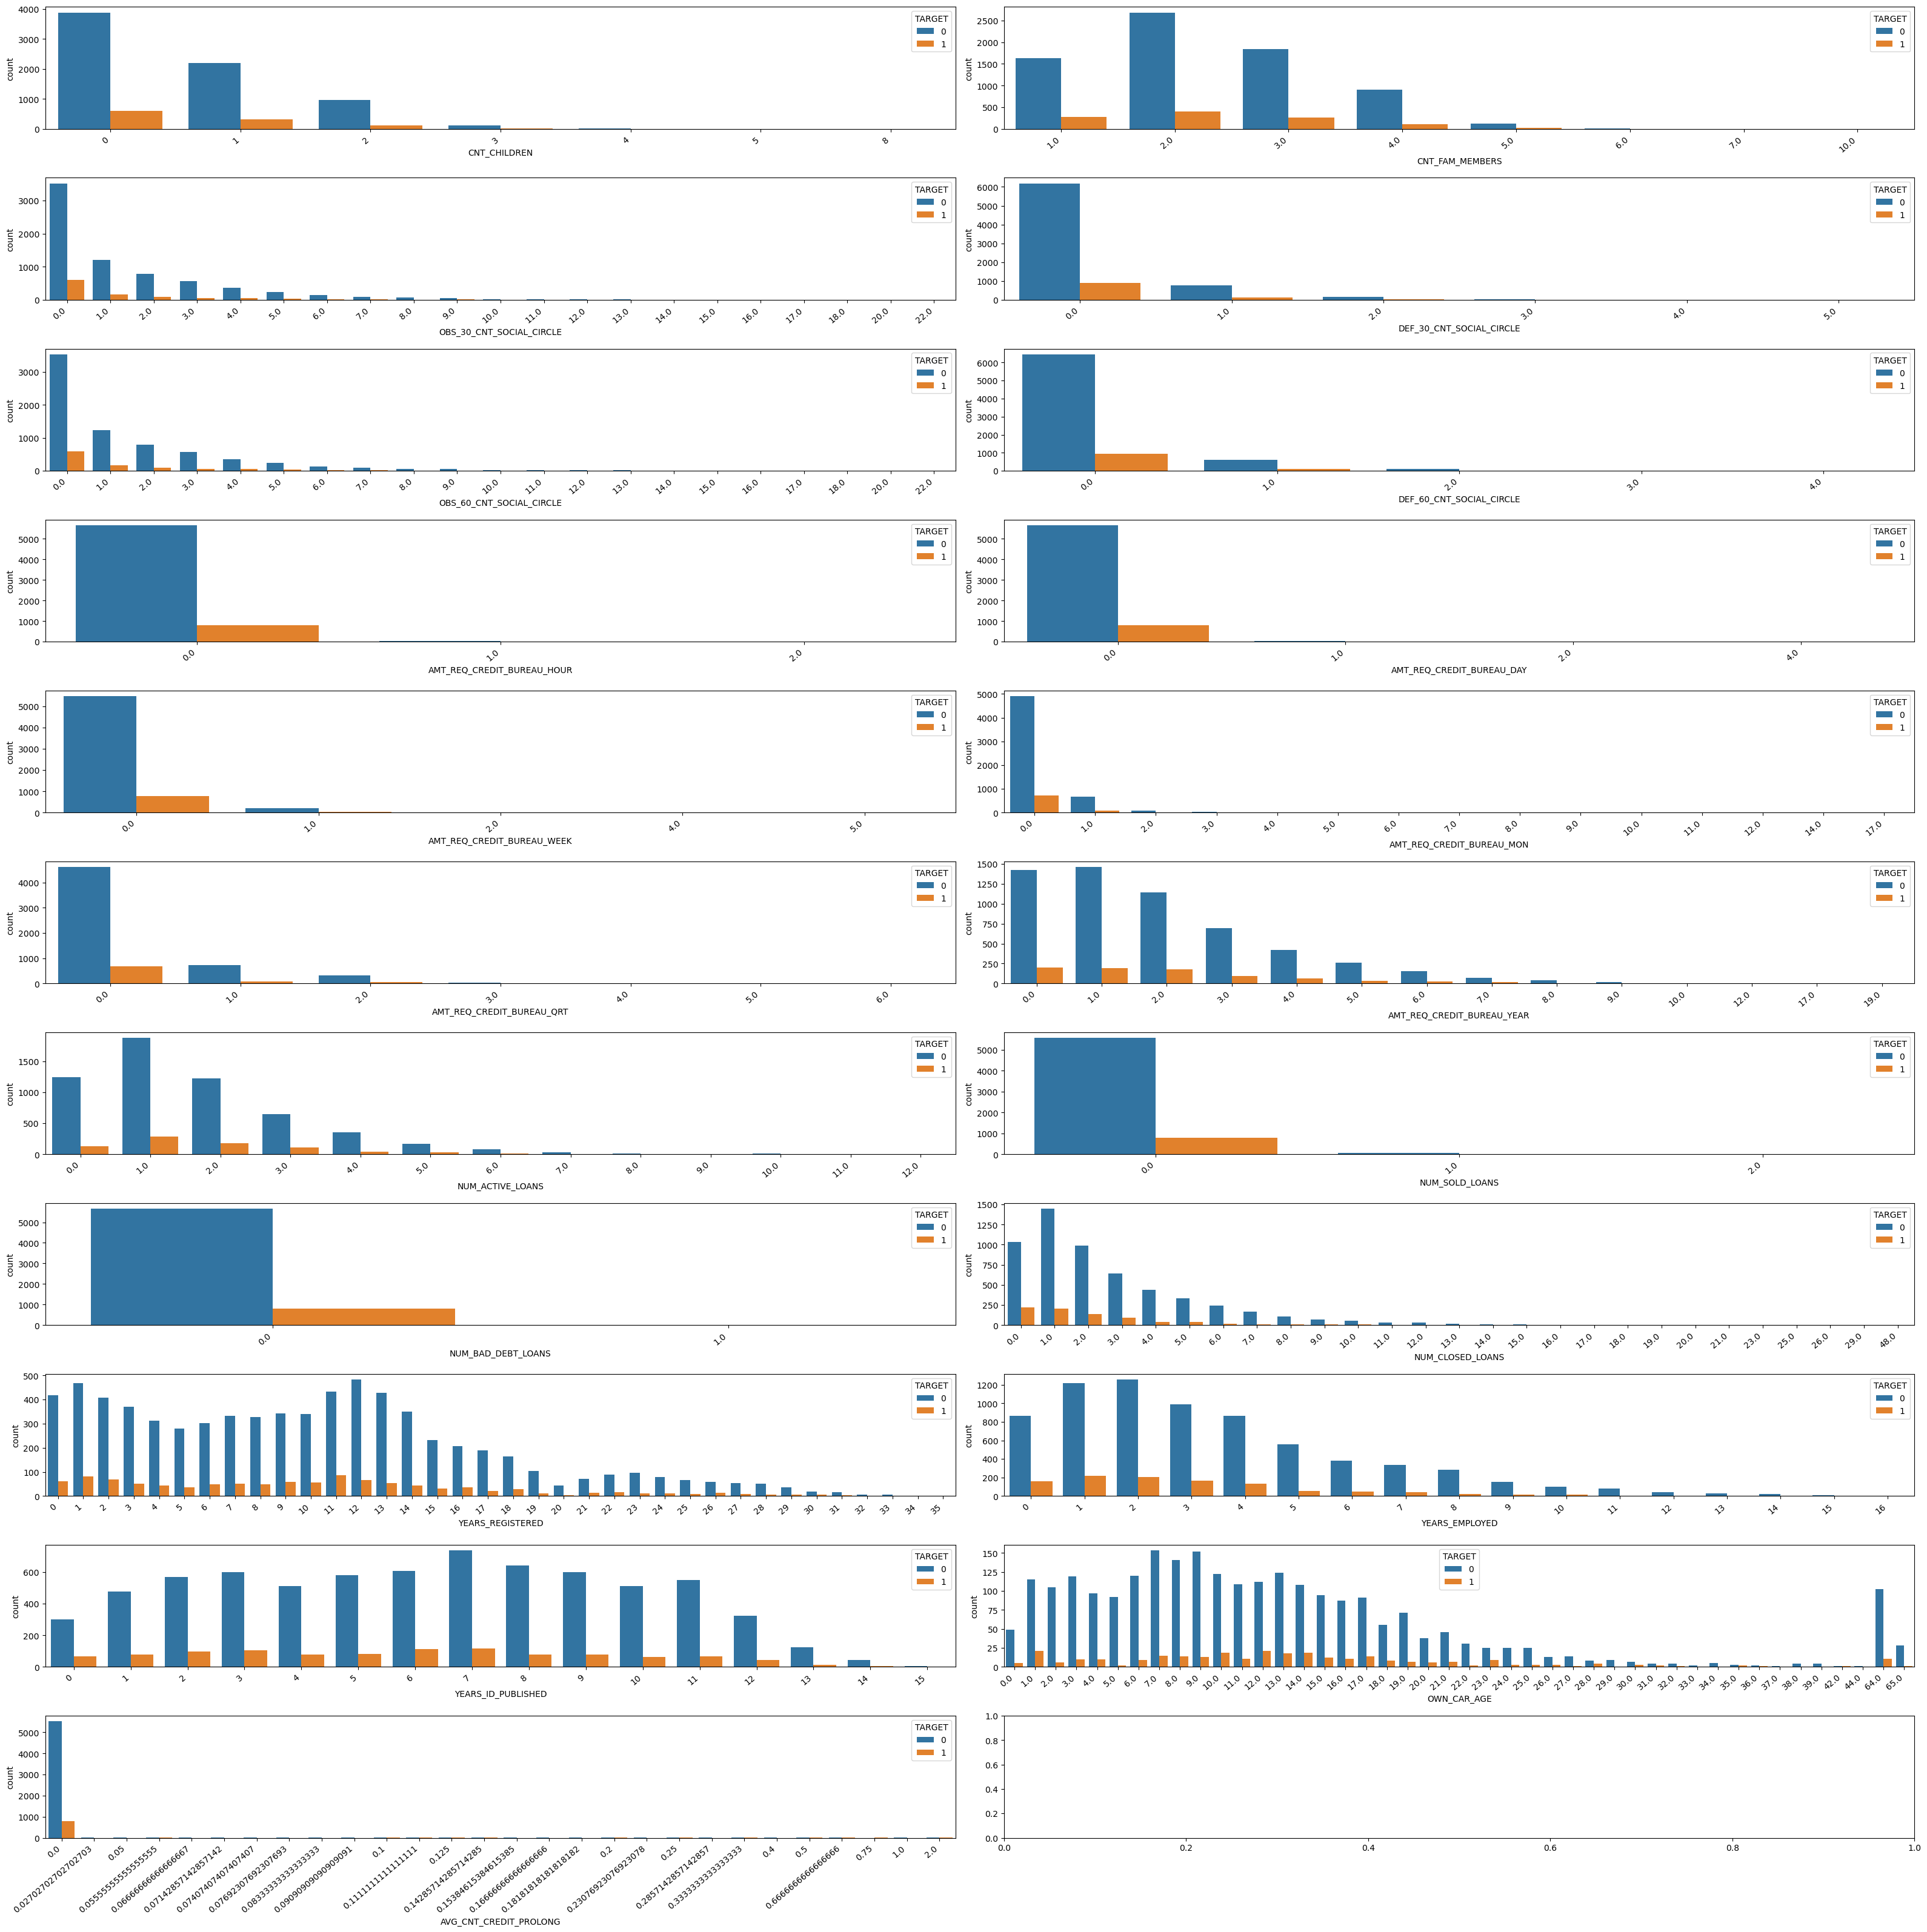

In [33]:
row_count=int(np.ceil(len(num_disc_var)/2))
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 32))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x= unclean_merged_data[num_disc_var[i]], hue=app_data['TARGET'])
    axis.set_xlabel(str(num_disc_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")

    if i == len(num_disc_var)-1: 
         break
    
# Show the plot
plt.tight_layout()

#### Bar Charts - Categorical Data

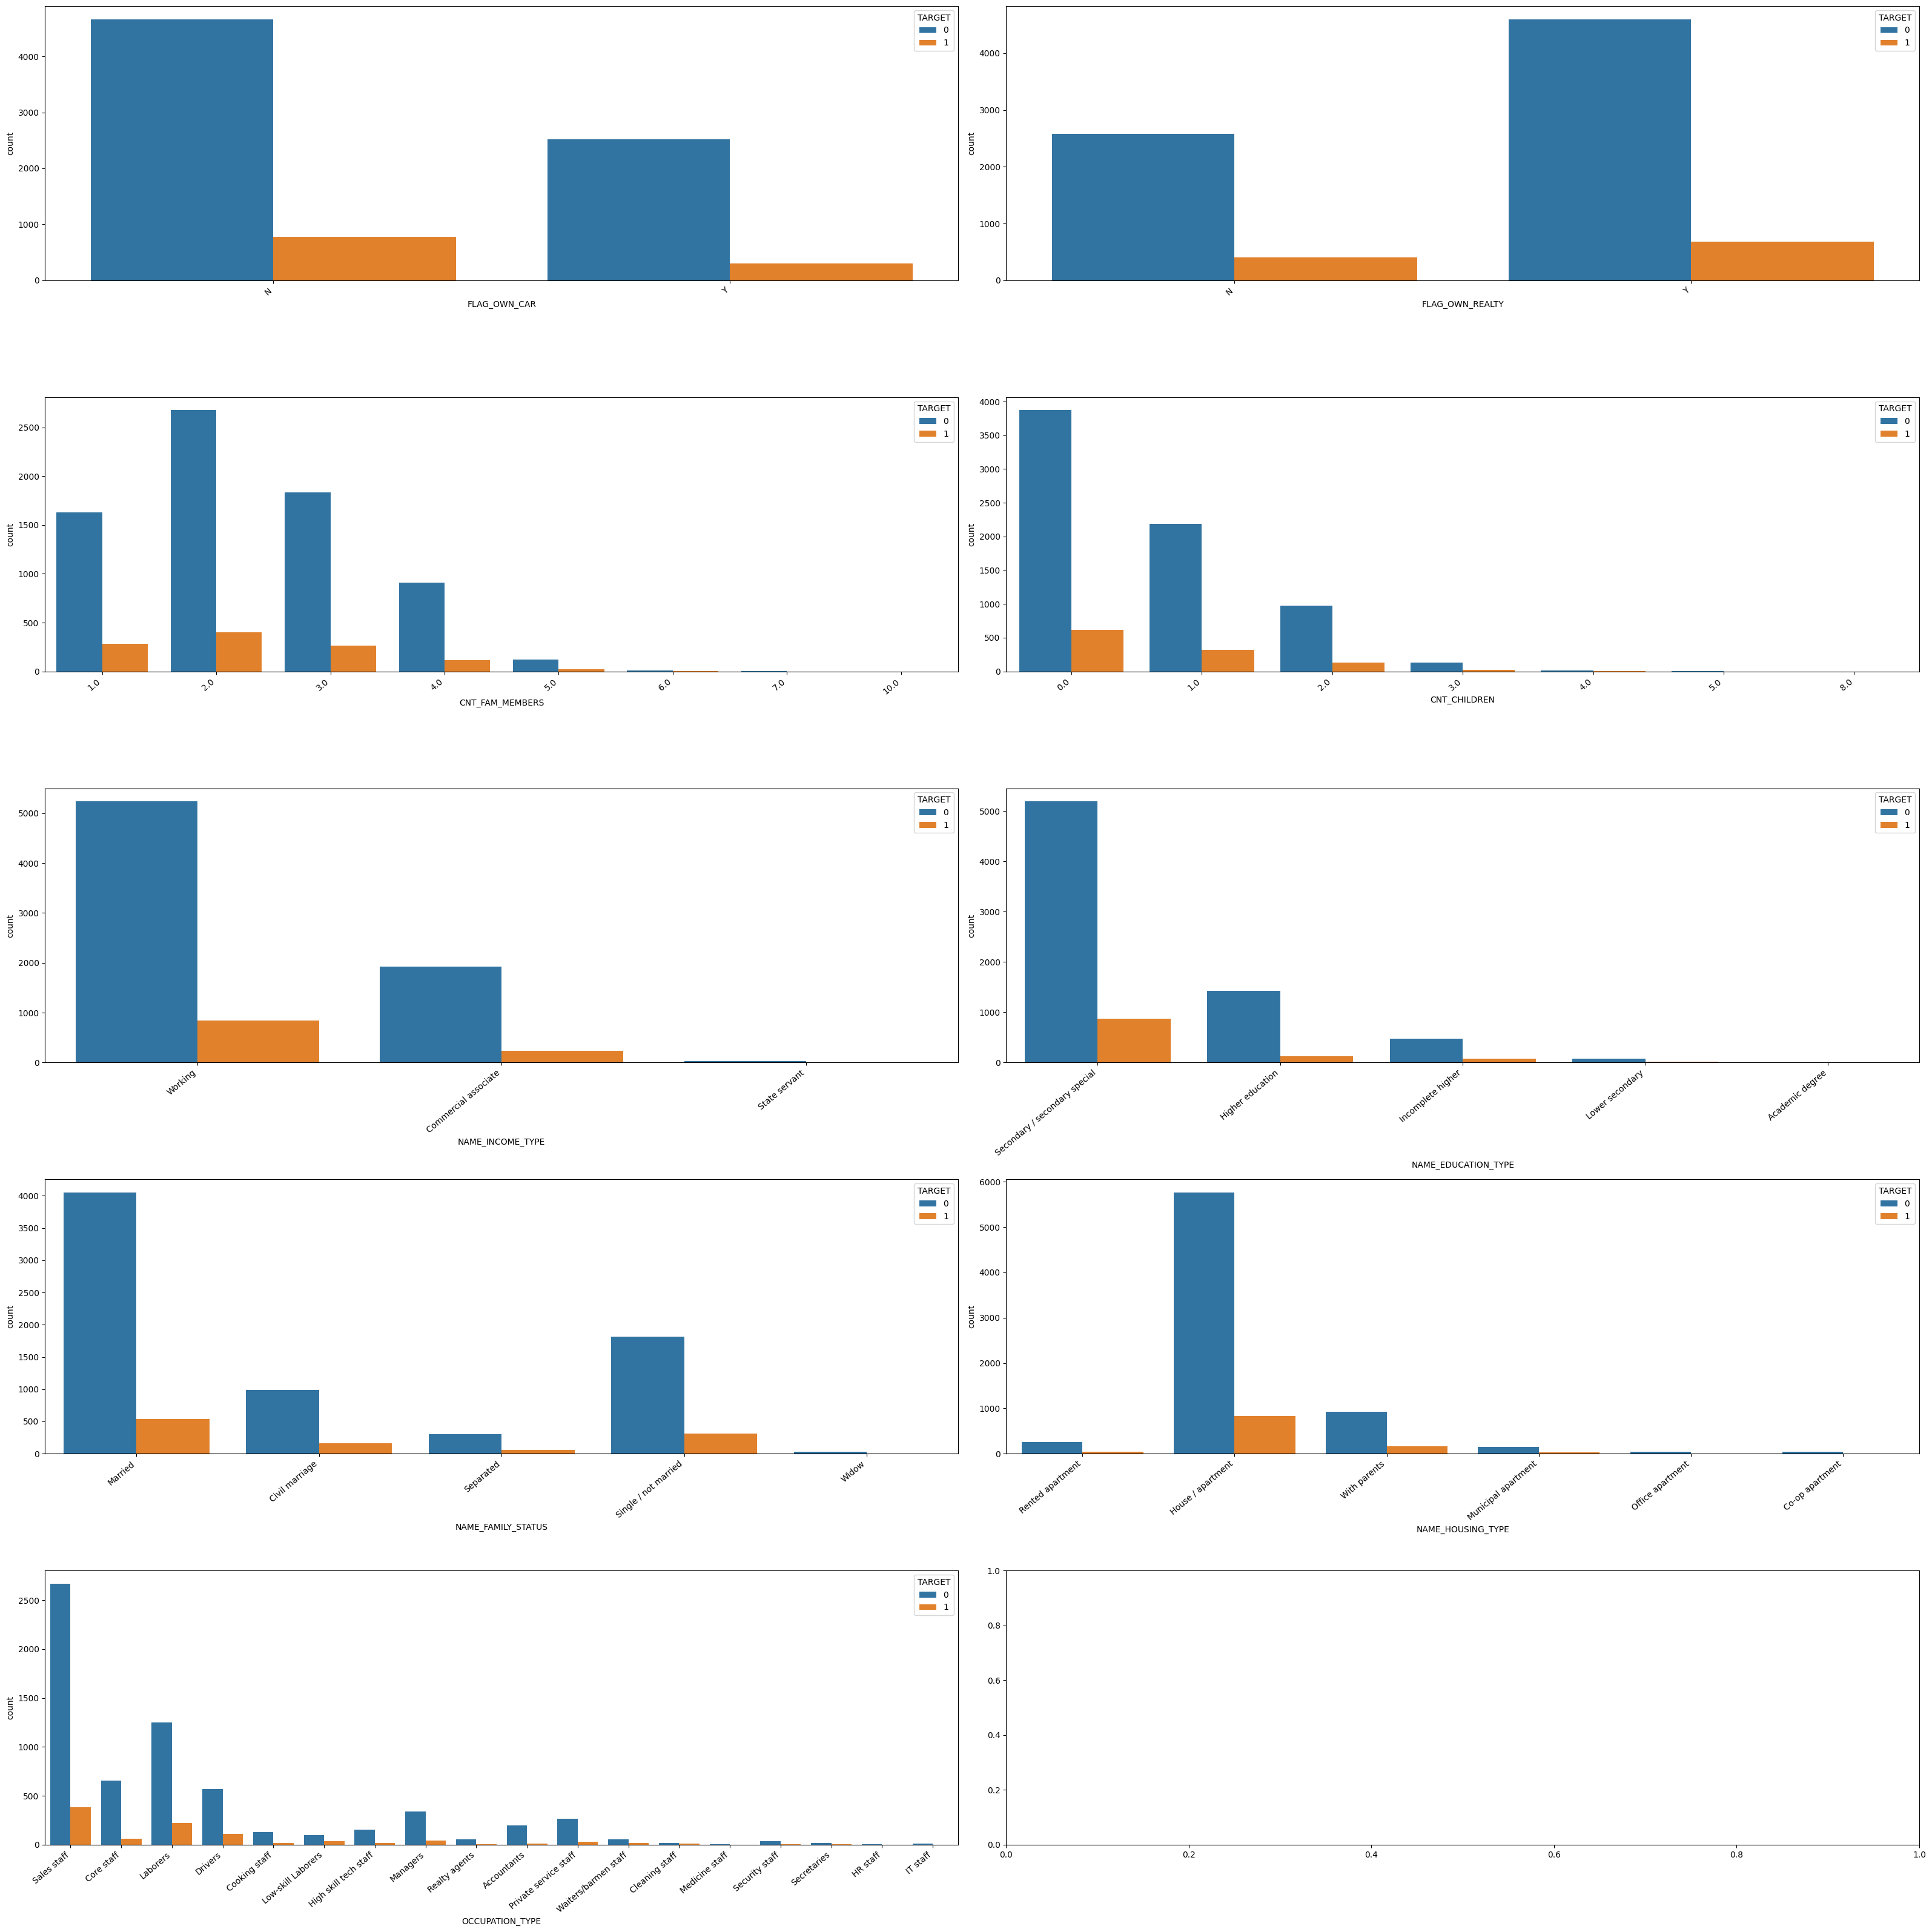

In [616]:
row_count=int(np.ceil(len(cat_var)/2))
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 32))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x= unclean_merged_data[cat_var[i]], hue=app_data['TARGET'])
    axis.set_xlabel(str(cat_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")

    if i == len(cat_var)-1: 
         break
    
# Show the plot
plt.tight_layout()

#### Stacked Bar Charts - Numerical Discrete Data

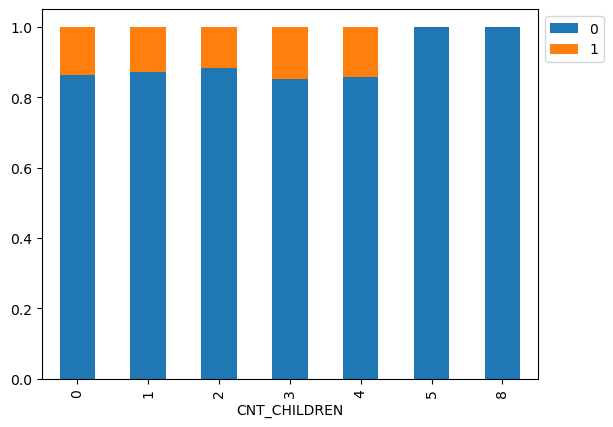

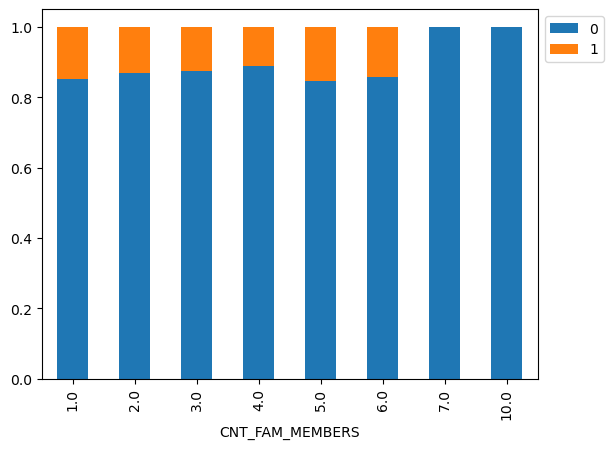

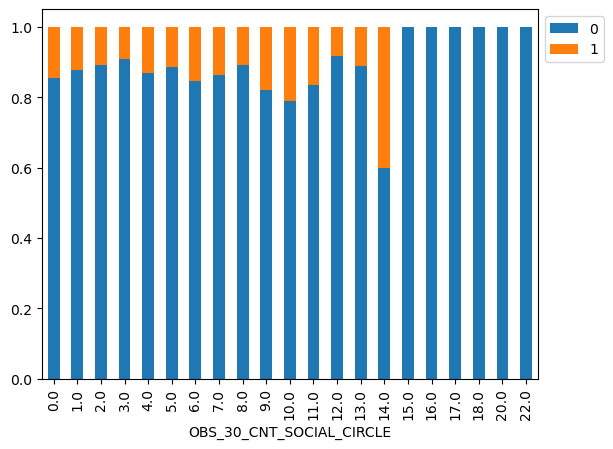

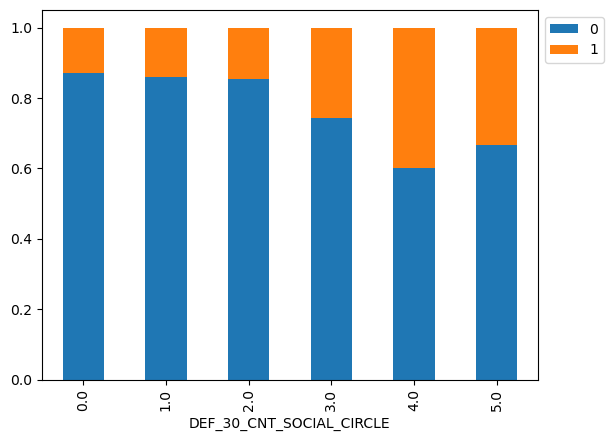

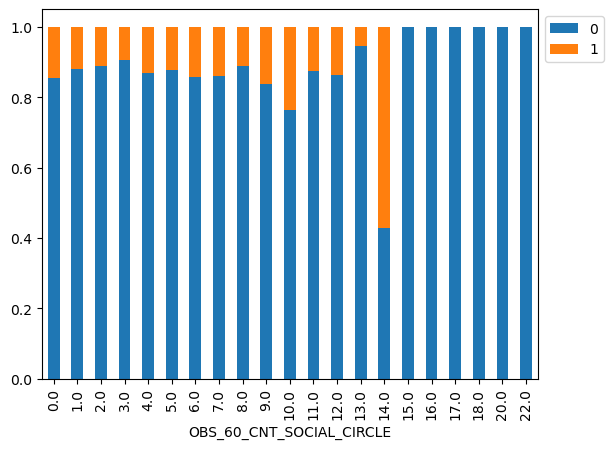

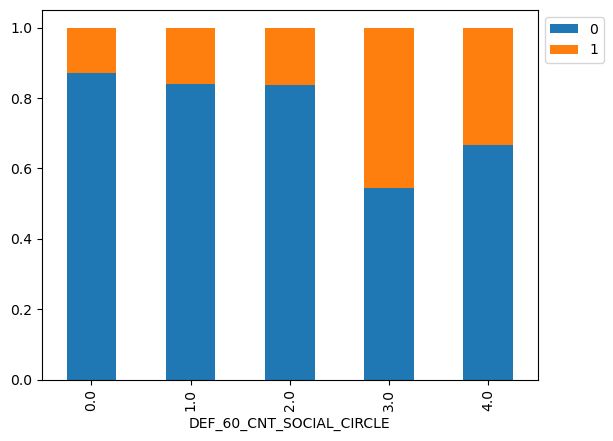

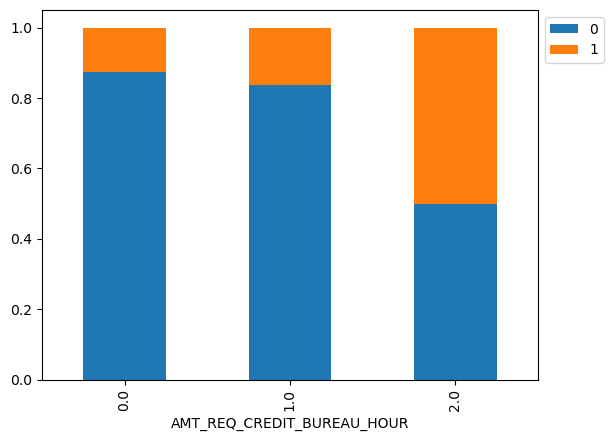

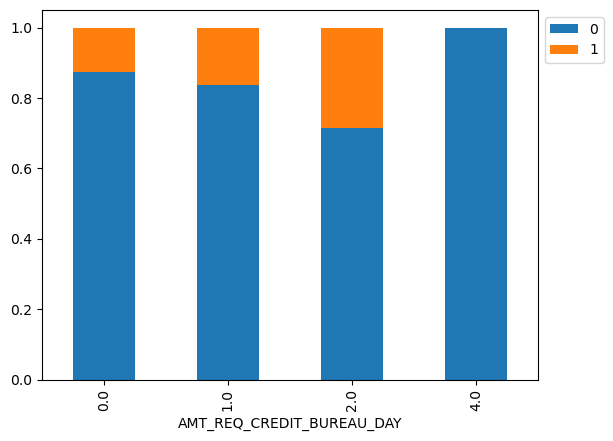

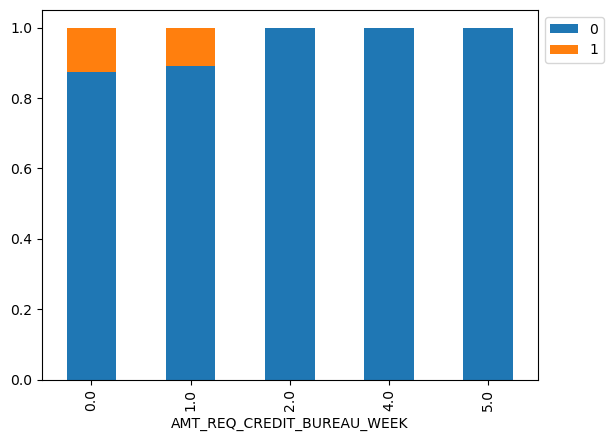

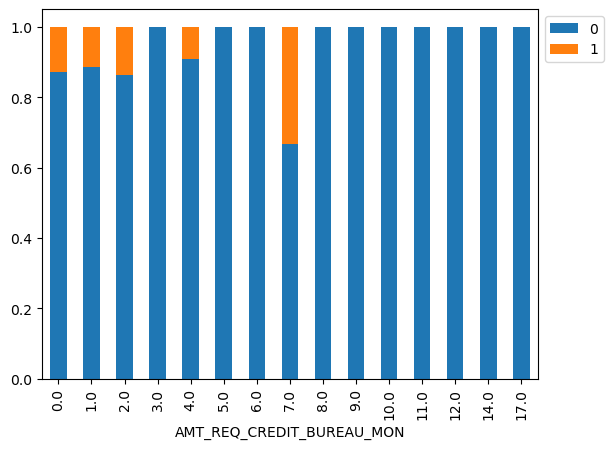

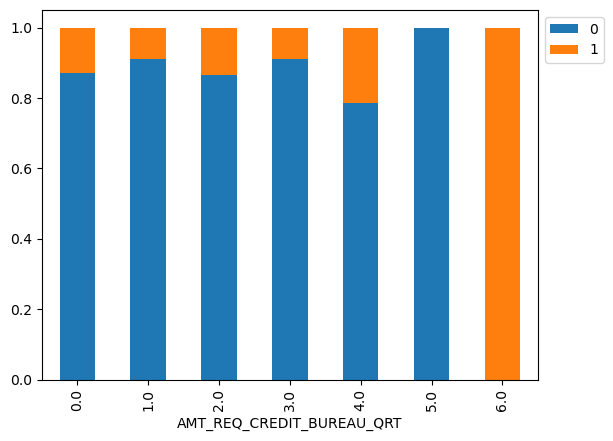

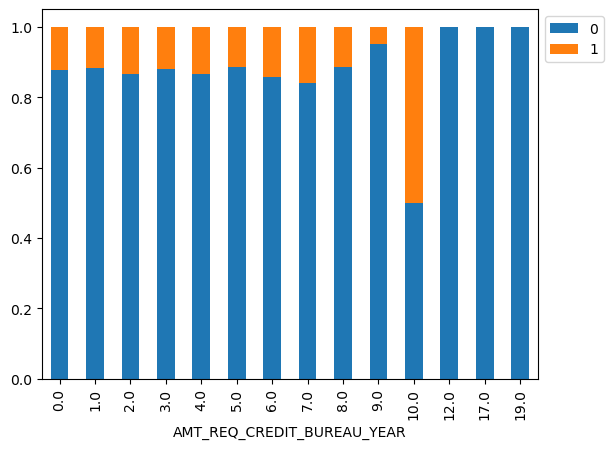

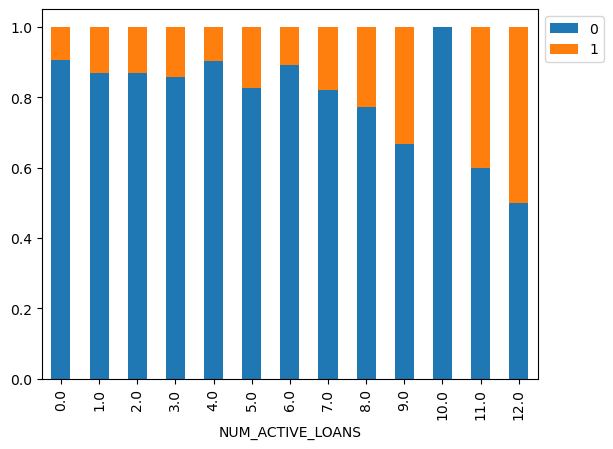

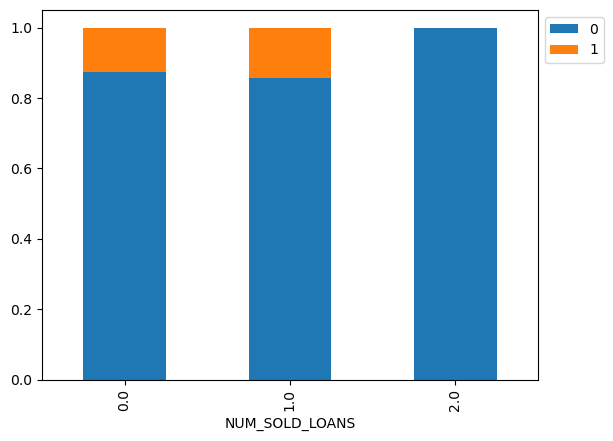

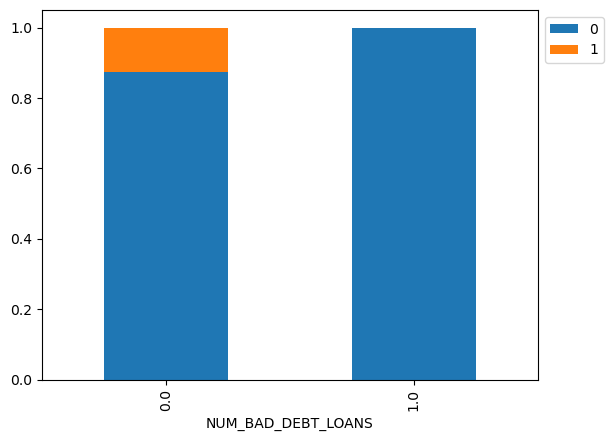

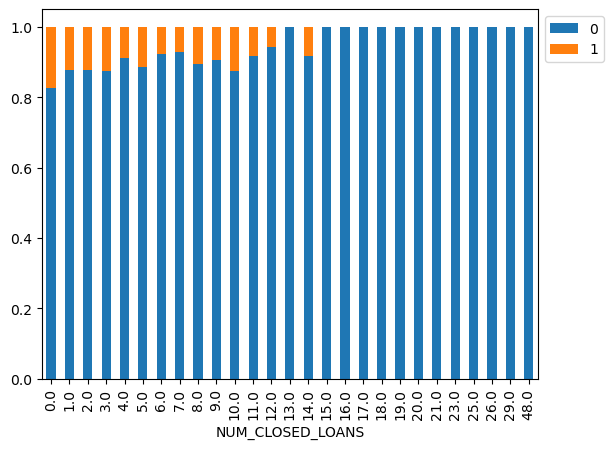

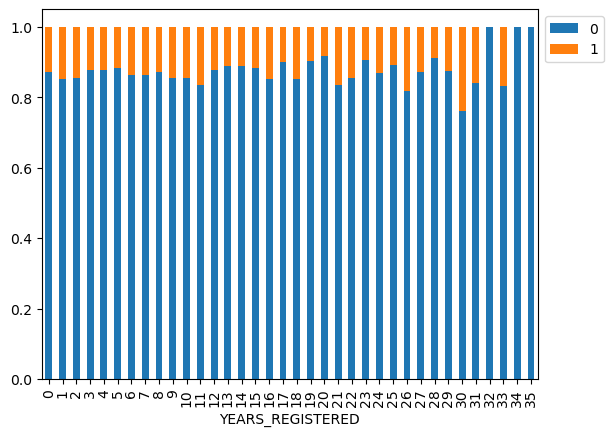

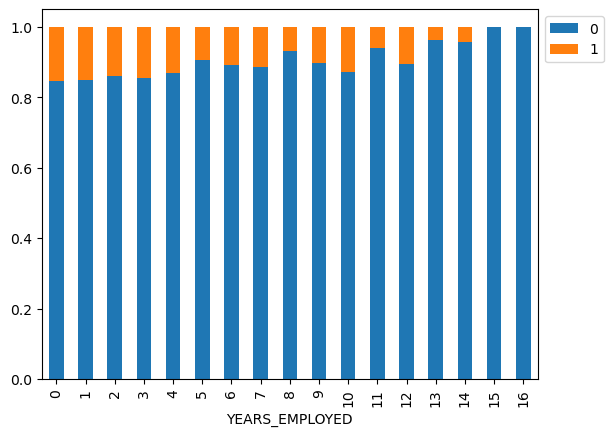

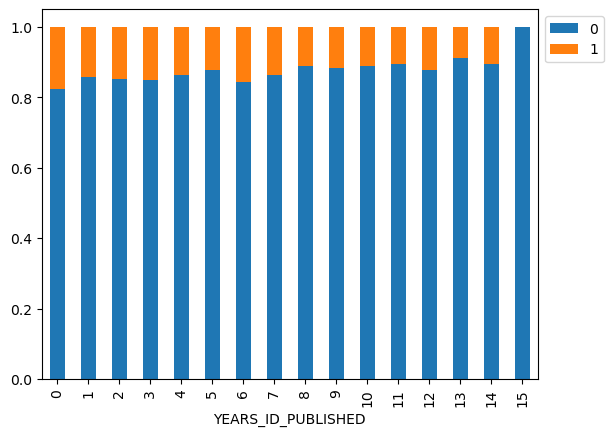

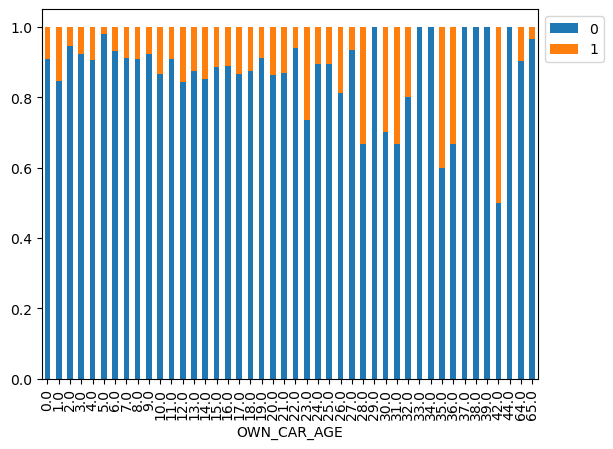

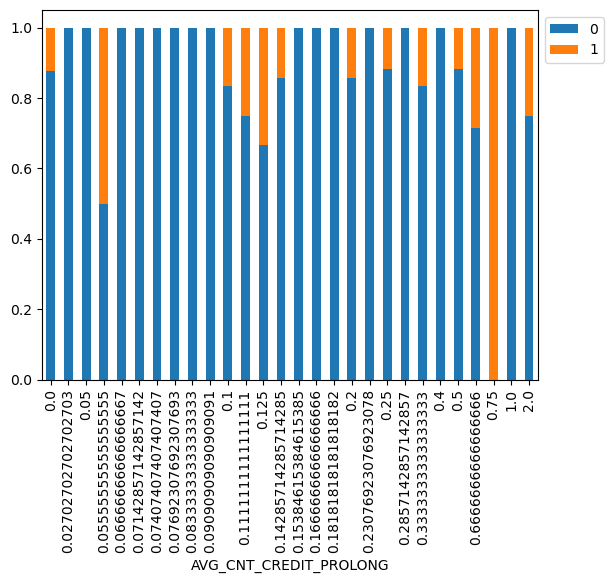

In [35]:
row_count=int(np.ceil(len(num_disc_var)/2))

for i in num_disc_var:
    df_reason_bivariate = unclean_merged_data.groupby(i)['TARGET'].value_counts(normalize = True).unstack()
    ax = df_reason_bivariate.plot(kind='bar', stacked='True')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    if i == len(num_disc_var)-1: 
         break
        
plt.show()

#### Stacked Bar Charts - Categorical Data

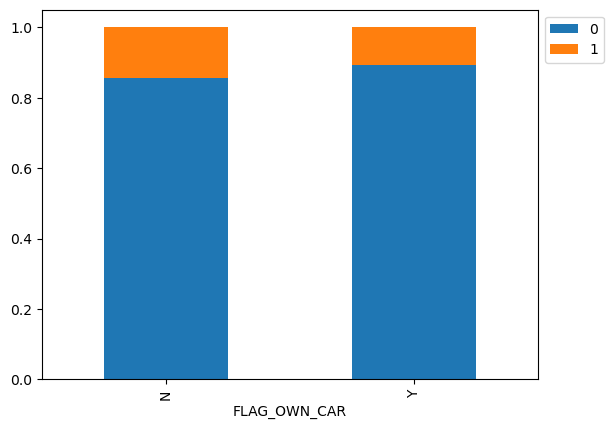

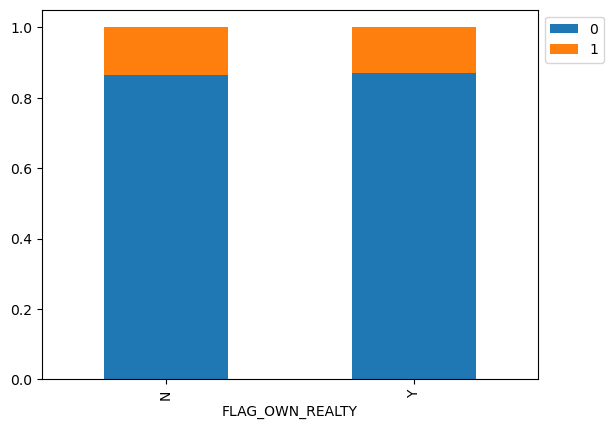

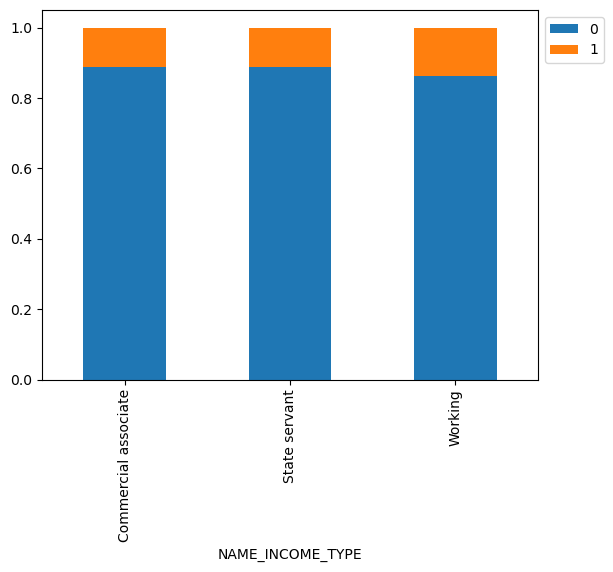

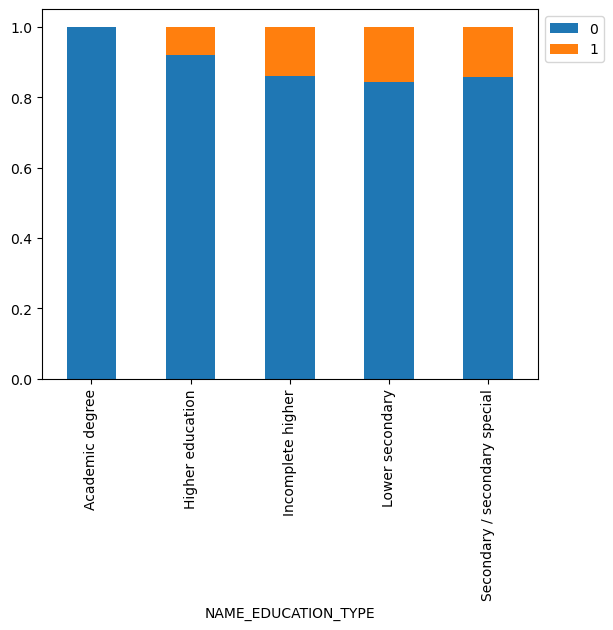

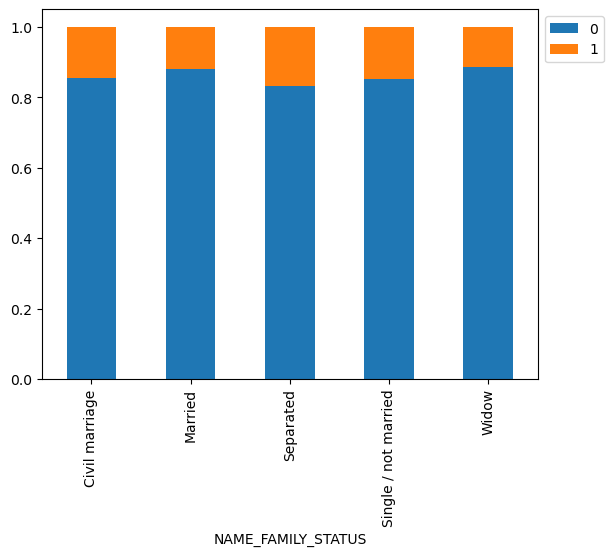

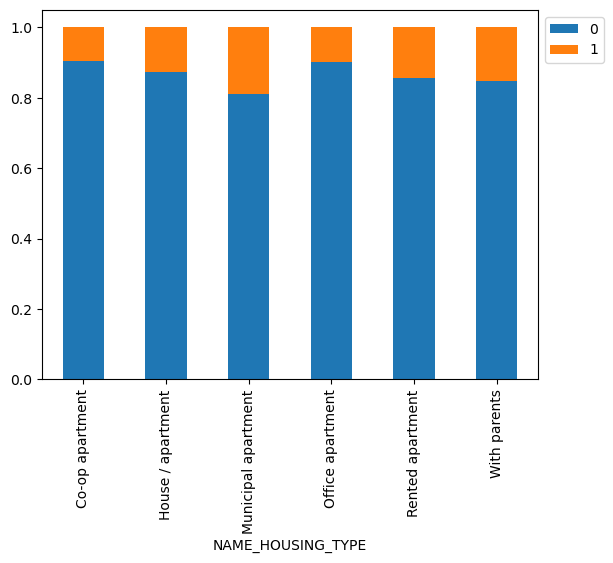

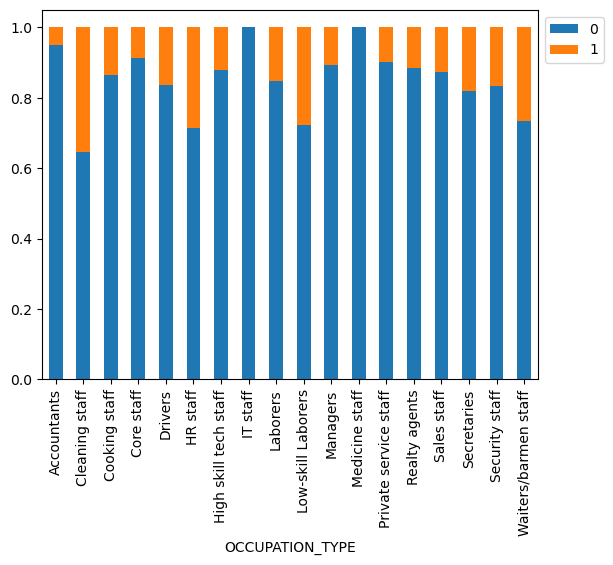

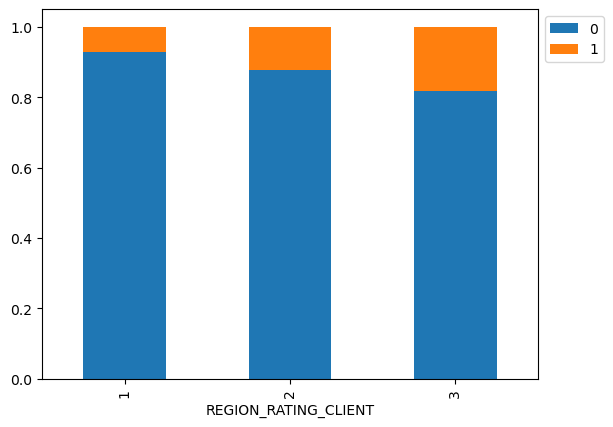

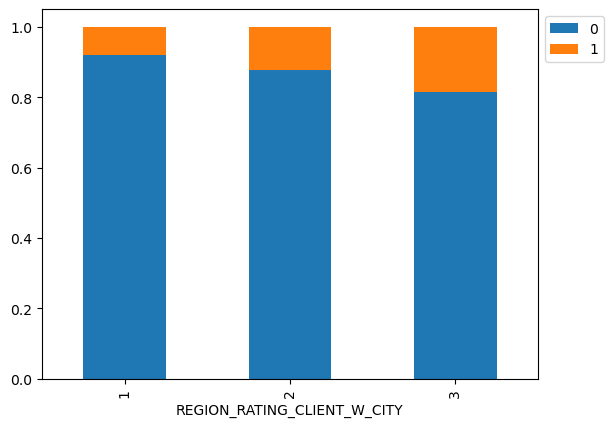

In [34]:
row_count=int(np.ceil(len(cat_var)/2))

for i in cat_var:
    df_reason_bivariate = unclean_merged_data.groupby(i)['TARGET'].value_counts(normalize = True).unstack()
    ax = df_reason_bivariate.plot(kind='bar', stacked='True')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    if i == len(cat_var)-1: 
         break
        
plt.show()

## 2. Data Preparation

### 2.1 Feature Extraction & Engineering from Unclean Merged Filtered Data

In [36]:
# Create DEBT_INCOME_RATIO variable
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['AMT_CREDIT']/unclean_merged_data['AMT_INCOME_TOTAL']
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['DEBT_INCOME_RATIO'].astype(float)
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['DEBT_INCOME_RATIO'].round(2)
# DROP AMT_CREDIT and AMT_INCOME_TOTAL
unclean_merged_data.drop("AMT_CREDIT", axis=1, inplace=True)
unclean_merged_data.drop("AMT_INCOME_TOTAL", axis=1, inplace=True)

unclean_merged_data['DEBT_INCOME_RATIO']


22       1.11
35       4.00
45       2.00
53       1.40
77       2.50
         ... 
307353   3.48
307383   3.39
307385   1.00
307436   1.60
307457   1.78
Name: DEBT_INCOME_RATIO, Length: 8270, dtype: float64

In [37]:
unclean_merged_data["TOTAL_LOANS"] = unclean_merged_data["NUM_ACTIVE_LOANS"] + unclean_merged_data["NUM_SOLD_LOANS"] + unclean_merged_data["NUM_BAD_DEBT_LOANS"] + unclean_merged_data["NUM_CLOSED_LOANS"]
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
22          100026       0            N               N             1   
35          100041       0            N               N             0   
45          100052       0            N               Y             1   
53          100061       0            N               Y             2   
77          100089       0            N               Y             0   
...            ...     ...          ...             ...           ...   
307353      456078       0            N               Y             0   
307383      456108       1            N               Y             1   
307385      456110       0            Y               Y             2   
307436      456174       0            N               N             2   
307457      456196       0            N               Y             2   

        AMT_ANNUITY  AMT_GOODS_PRICE      NAME_INCOME_TYPE  \
22         32521.50        450000.00               Working   
35         44509.50        450000.00               Working   
45          9000.00        180000.00               Working   
53         16164.00        238500.00  Commercial associate   
77         15781.50        256500.00               Working   
...             ...              ...                   ...   
307353     21339.00        337500.00               Working   
307383     33444.00        378000.00               Working   
307385      9000.00        180000.00  Commercial associate   
307436     17064.00        180000.00               Working   
307457     18000.00        360000.00  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  ...  \
22      Secondary / secondary special               Married  ...   
35                   Higher education               Married  ...   
45      Secondary / secondary special        Civil marriage  ...   
53                   Higher education               Married  ...   
77      Secondary / secondary special        Civil marriage  ...   
...                               ...                   ...  ...   
307353  Secondary / secondary special  Single / not married  ...   
307383  Secondary / secondary special               Married  ...   
307385  Secondary / secondary special               Married  ...   
307436  Secondary / secondary special               Married  ...   
307457  Secondary / secondary special        Civil marriage  ...   

       AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  AVG_AMT_CREDIT_SUM_LIMIT  \
22             1875000.00               1738907.19                      0.00   
35               63254.24                     0.00                      0.00   
45                    NaN                      NaN                       NaN   
53               37741.50                     0.00                       NaN   
77              116545.50                     0.00                      0.00   
...                   ...                      ...                       ...   
307353                NaN                      NaN                       NaN   
307383          168275.04                108897.75                    581.47   
307385         6760620.00               6510321.00                      0.00   
307436           64469.25                     0.00                      0.00   
307457          125526.27                 24386.85                      0.00   

       AVG_AMT_CREDIT_SUM_OVERDUE  NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  \
22                           0.00              2.00            0.00   
35                           0.00              1.00            0.00   
45                            NaN               NaN             NaN   
53                           0.00              0.00            0.00   
77                           0.00              0.00            0.00   
...                           ...               ...             ...   
307353                        NaN               NaN             NaN   
307383                       0.00       

##### Get Active Loans, Bad Debt Loans, and Closed Loans Ratio
Drop used variables

In [38]:
unclean_merged_data["ACTIVE_LOAN_RATIO"] = unclean_merged_data["NUM_ACTIVE_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["CLOSED_LOAN_RATIO"] = unclean_merged_data["NUM_CLOSED_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["BAD_DEBT_LOAN_RATIO"] = unclean_merged_data["NUM_BAD_DEBT_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["SOLD_LOAN_RATIO"] = unclean_merged_data["NUM_SOLD_LOANS"] / unclean_merged_data["TOTAL_LOANS"]

# Drop Active, Bad debt and Closed columns
unclean_merged_data.drop(["NUM_ACTIVE_LOANS", "NUM_CLOSED_LOANS","NUM_BAD_DEBT_LOANS", "NUM_SOLD_LOANS", "TOTAL_LOANS"], axis=1, inplace=True)
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
22          100026       0            N               N             1   
35          100041       0            N               N             0   
45          100052       0            N               Y             1   
53          100061       0            N               Y             2   
77          100089       0            N               Y             0   
...            ...     ...          ...             ...           ...   
307353      456078       0            N               Y             0   
307383      456108       1            N               Y             1   
307385      456110       0            Y               Y             2   
307436      456174       0            N               N             2   
307457      456196       0            N               Y             2   

        AMT_ANNUITY  AMT_GOODS_PRICE      NAME_INCOME_TYPE  \
22         32521.50        450000.00               Working   
35         44509.50        450000.00               Working   
45          9000.00        180000.00               Working   
53         16164.00        238500.00  Commercial associate   
77         15781.50        256500.00               Working   
...             ...              ...                   ...   
307353     21339.00        337500.00               Working   
307383     33444.00        378000.00               Working   
307385      9000.00        180000.00  Commercial associate   
307436     17064.00        180000.00               Working   
307457     18000.00        360000.00  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  ...  \
22      Secondary / secondary special               Married  ...   
35                   Higher education               Married  ...   
45      Secondary / secondary special        Civil marriage  ...   
53                   Higher education               Married  ...   
77      Secondary / secondary special        Civil marriage  ...   
...                               ...                   ...  ...   
307353  Secondary / secondary special  Single / not married  ...   
307383  Secondary / secondary special               Married  ...   
307385  Secondary / secondary special               Married  ...   
307436  Secondary / secondary special               Married  ...   
307457  Secondary / secondary special        Civil marriage  ...   

       AVG_CNT_CREDIT_PROLONG  AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
22                       0.00          1875000.00               1738907.19   
35                       0.00            63254.24                     0.00   
45                        NaN                 NaN                      NaN   
53                       0.00            37741.50                     0.00   
77                       0.00           116545.50                     0.00   
...                       ...                 ...                      ...   
307353                    NaN                 NaN                      NaN   
307383                   0.00           168275.04                108897.75   
307385                   0.00          6760620.00               6510321.00   
307436                   0.00            64469.25                     0.00   
307457                   0.00           125526.27                 24386.85   

       AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  \
22                         0.00                        0.00   
35                         0.00                        0.00   
45                          NaN                         NaN   
53                          NaN                        0.00   
77                         0.00                        0.00   
...                         ...                         ...   
307353                      NaN                         NaN   
307383                   581.47                        0.00   
307385                     0.00                        0.00   
30

### 2.2 Data Cleaning

#### Outliers
Identify valid and invalid outliers and remove invalid outliers to ensure subsequent data analysis is not skewed incorrectly

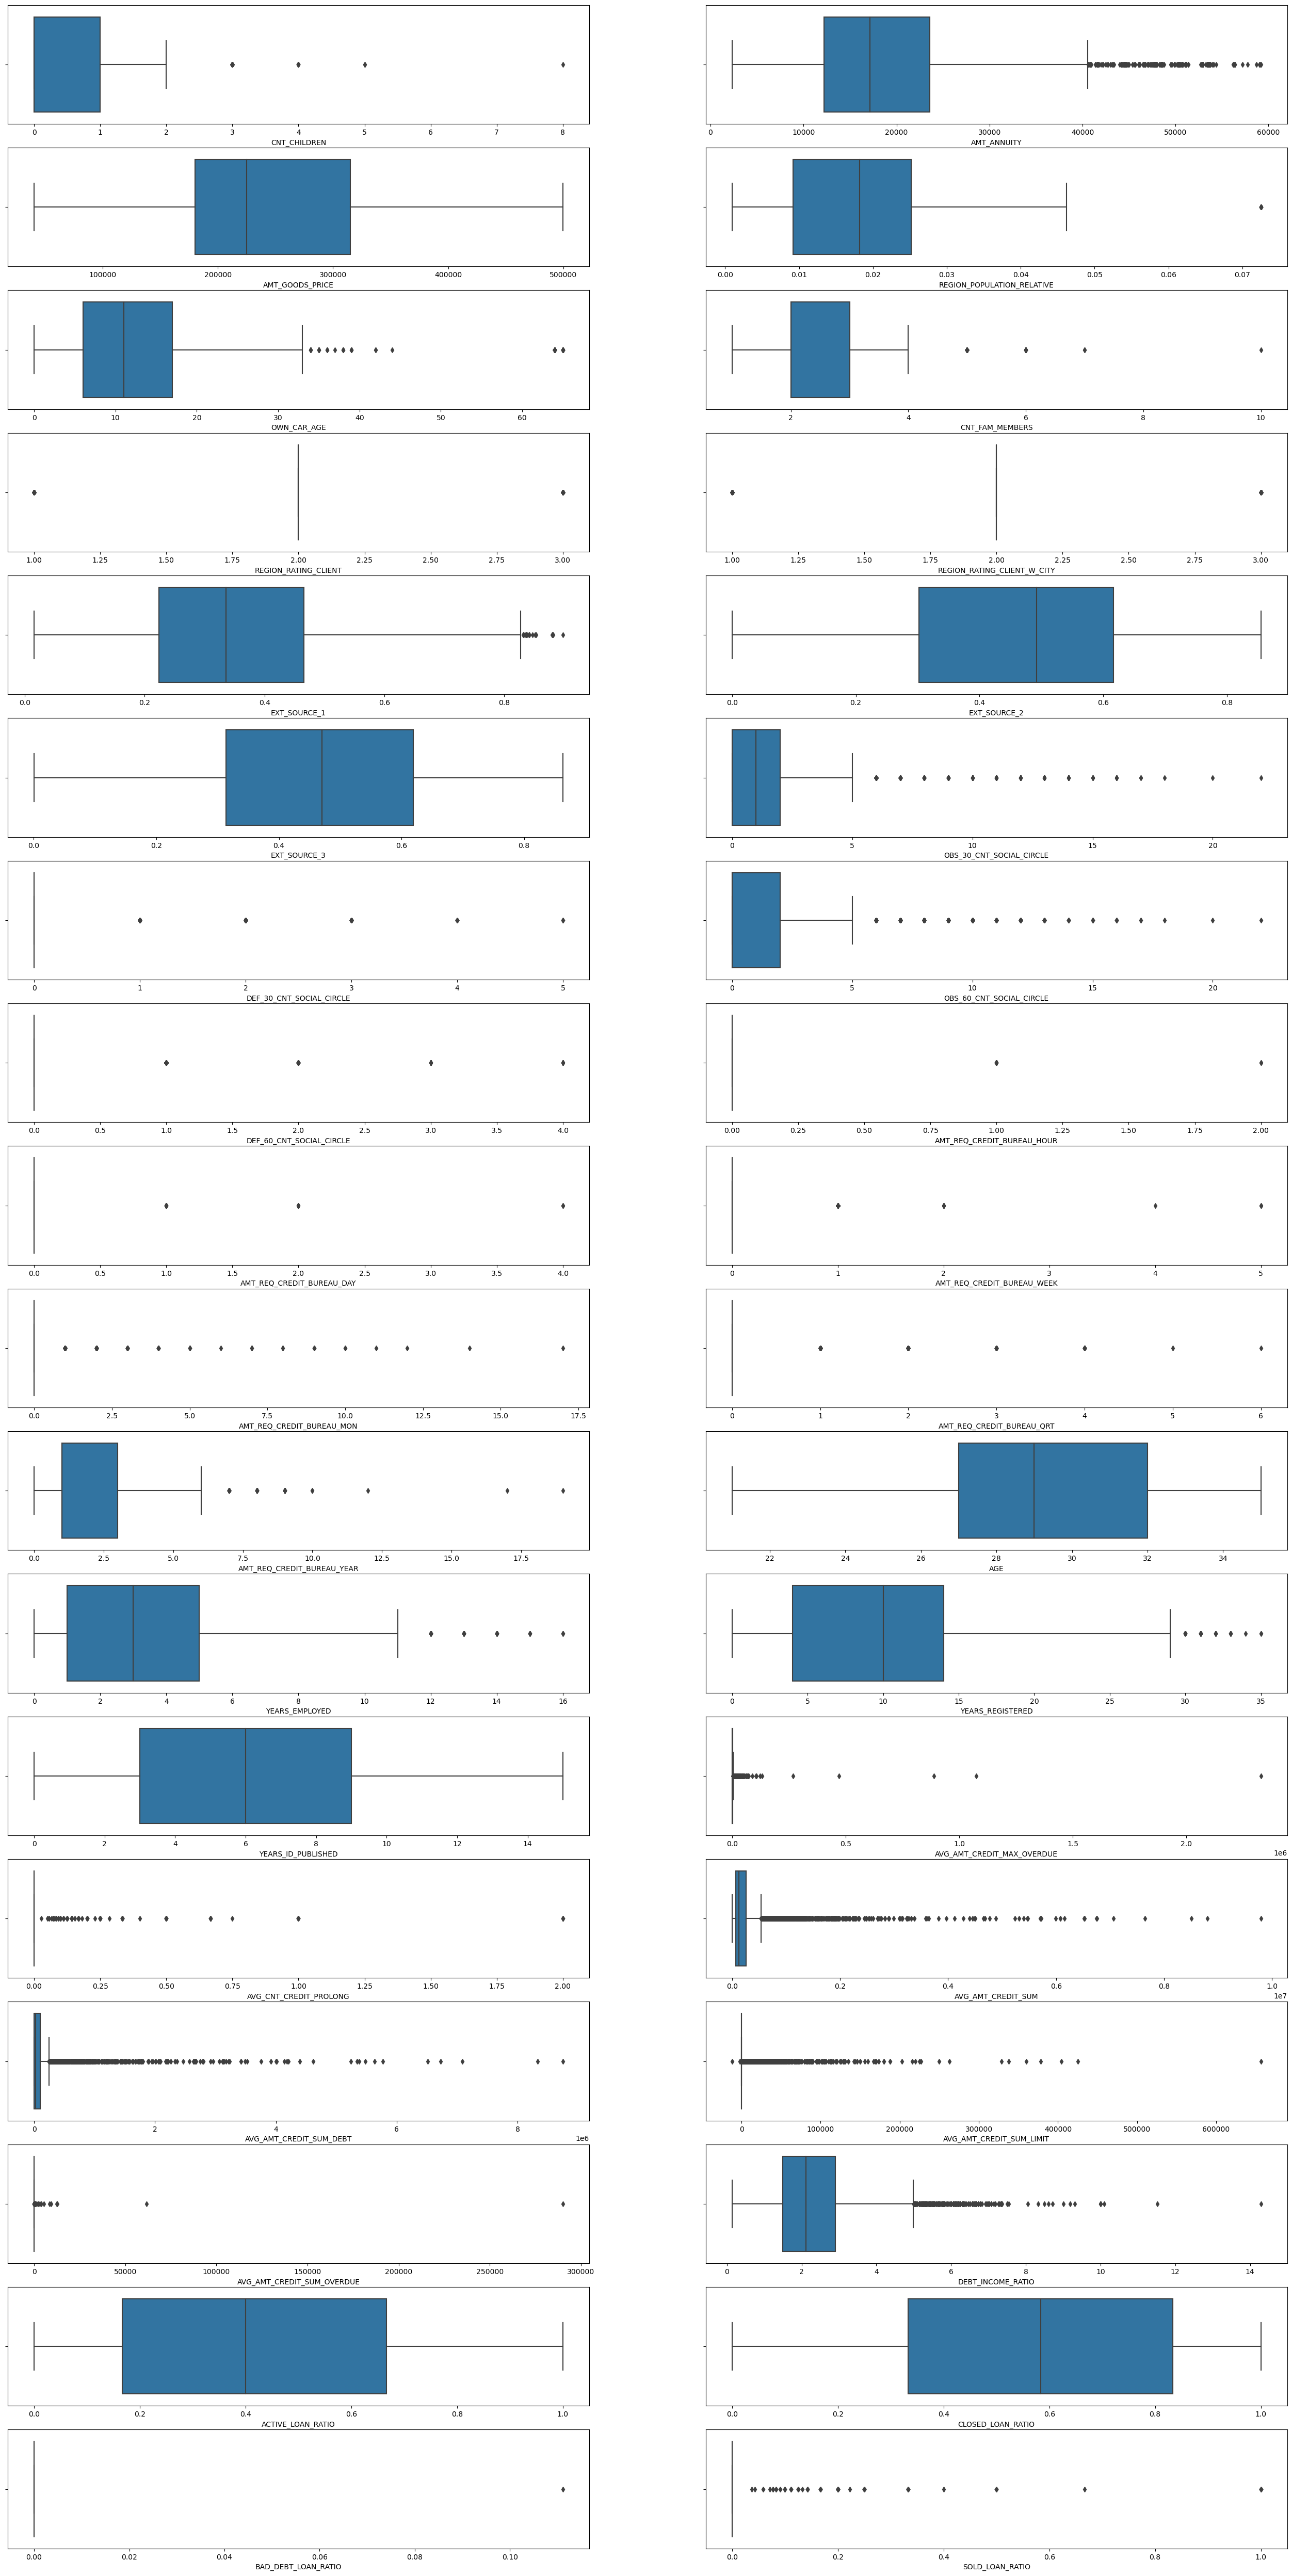

In [39]:
# create boxplots
numerical_var = unclean_merged_data.select_dtypes(include=np.number).columns.tolist()
remove_numerical_var = ["SK_ID_CURR", "TARGET"]

for var in remove_numerical_var:
    numerical_var.remove(var)

row_count=int(np.ceil(len(numerical_var)/2))

# create the figure and two subplots
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 64))

for i, axis in enumerate(fig.axes):
    sns.boxplot(ax=axis, data=unclean_merged_data, x = numerical_var[i],orient='h')
    axis.set_xlabel(str(numerical_var[i]))
    if i == len(numerical_var)-1: 
         break

# Show the plot
plt.show()

In [40]:
# Drop column "YEARS_REGISTERED"
# Our applicants are 21 to 35 years old a large portion of "YEARS_REGISTERED" exceed their legal age to apply for a loan
unclean_merged_data.drop(["YEARS_REGISTERED"], axis=1, inplace=True)

#### Missing Values
Identify and Impute Random and Not Random Missing Values, and drop Completely Random Values

In [41]:
# identify columns with NULL values
unclean_merged_data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_ANNUITY                       0
AMT_GOODS_PRICE                  22
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
OWN_CAR_AGE                    5447
OCCUPATION_TYPE                 739
CNT_FAM_MEMBERS                   0
REGION_RATING_CLIENT              0
REGION_RATING_CLIENT_W_CITY       0
EXT_SOURCE_1                   3569
EXT_SOURCE_2                     19
EXT_SOURCE_3                   2455
OBS_30_CNT_SOCIAL_CIRCLE         35
DEF_30_CNT_SOCIAL_CIRCLE         35
OBS_60_CNT_SOCIAL_CIRCLE         35
DEF_60_CNT_SOCIAL_CIRCLE         35
AMT_REQ_CREDIT_BUREAU_HOUR     1761
AMT_REQ_CREDIT_BUREAU_DAY      1761
AMT_REQ_CREDIT_BUREAU_WEEK     1761
AMT_REQ_CREDIT_BUREAU_MON   

Drop columns with > 10% completely random missing values

In [42]:
# Identify columns with more than 10% invalid missing observations (completely random)
total_rows = unclean_merged_data.shape[0]
cols_null_percentage = unclean_merged_data.isnull().sum() / total_rows*100
print(cols_null_percentage[cols_null_percentage > 10])

OWN_CAR_AGE                  65.86
EXT_SOURCE_1                 43.16
EXT_SOURCE_3                 29.69
AMT_REQ_CREDIT_BUREAU_HOUR   21.29
AMT_REQ_CREDIT_BUREAU_DAY    21.29
AMT_REQ_CREDIT_BUREAU_WEEK   21.29
AMT_REQ_CREDIT_BUREAU_MON    21.29
AMT_REQ_CREDIT_BUREAU_QRT    21.29
AMT_REQ_CREDIT_BUREAU_YEAR   21.29
AVG_AMT_CREDIT_MAX_OVERDUE   44.84
AVG_CNT_CREDIT_PROLONG       21.87
AVG_AMT_CREDIT_SUM           21.87
AVG_AMT_CREDIT_SUM_DEBT      24.17
AVG_AMT_CREDIT_SUM_LIMIT     29.31
AVG_AMT_CREDIT_SUM_OVERDUE   21.87
ACTIVE_LOAN_RATIO            21.87
CLOSED_LOAN_RATIO            21.87
BAD_DEBT_LOAN_RATIO          21.87
SOLD_LOAN_RATIO              21.87
dtype: float64


In [43]:
# 21.87% of bureau data is missing likely due to the fact that not everyone has bureau data
# "AVG_AMT_CREDIT_MAX_OVERDUE", "AVG_AMT_CREDIT_SUM_DEBT", and "AVG_AMT_CREDIT_SUM_LIMIT"
# from the bureau data has > 21.87% of missing data indicating that the remaining missing data
# are completely random and should be removed if it contains > 10% (i.e. > 31.87%)

# Drop columns containing > 10% of completely random null values 
unclean_merged_data.drop(["AVG_AMT_CREDIT_MAX_OVERDUE"], axis=1, inplace=True)

Impute Random and Not Random Missing Values

In [44]:
# Need to go through this list and justify the missing variables
    # Majority of these information I consider to not be missing at random cause the data probably N/A to them
    # e.g. Applicants may not have bureau data (incl external source), no appropriate social circle for observation
    # AMT_GOODS_PRICE is only applicable to consumer loans, applicant might've taken other types of loans
# We will not delete Missing not at random observations as it may cause the data to be biased

# Impute valid missing variables with "None"
valid_missing_var = ["AMT_GOODS_PRICE", "OWN_CAR_AGE", "EXT_SOURCE_1", "EXT_SOURCE_2", 
                      "EXT_SOURCE_3", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                      "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
                      "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", 
                      "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                      "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
                      "AVG_CNT_CREDIT_PROLONG","AVG_AMT_CREDIT_SUM",  
                      "AVG_AMT_CREDIT_SUM_OVERDUE", "ACTIVE_LOAN_RATIO", 
                      "CLOSED_LOAN_RATIO", "BAD_DEBT_LOAN_RATIO", "SOLD_LOAN_RATIO"]

encoded_missing_data = unclean_merged_data.copy()
for var in valid_missing_var:
    encoded_missing_data[var].fillna("Missing", inplace = True)

encoded_missing_data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_ANNUITY                       0
AMT_GOODS_PRICE                   0
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
OWN_CAR_AGE                       0
OCCUPATION_TYPE                 739
CNT_FAM_MEMBERS                   0
REGION_RATING_CLIENT              0
REGION_RATING_CLIENT_W_CITY       0
EXT_SOURCE_1                      0
EXT_SOURCE_2                      0
EXT_SOURCE_3                      0
OBS_30_CNT_SOCIAL_CIRCLE          0
DEF_30_CNT_SOCIAL_CIRCLE          0
OBS_60_CNT_SOCIAL_CIRCLE          0
DEF_60_CNT_SOCIAL_CIRCLE          0
AMT_REQ_CREDIT_BUREAU_HOUR        0
AMT_REQ_CREDIT_BUREAU_DAY         0
AMT_REQ_CREDIT_BUREAU_WEEK        0
AMT_REQ_CREDIT_BUREAU_MON   

Drop rows with > 10% missing values

In [45]:
# Identify rows with > 10% invalid missing observations (completely random)
total_cols = encoded_missing_data.shape[1]
missing_row_limit = int(0.1 * total_cols)

rows_null_percentage = encoded_missing_data[encoded_missing_data.isnull().sum(axis = 1) > missing_row_limit].shape[0]
rows_null_percentage = round((rows_null_percentage/encoded_missing_data.shape[0] * 100), 1)
print(rows_null_percentage)

encoded_missing_data[encoded_missing_data.isnull().sum(axis = 1) > missing_row_limit]

# Drop rows with > 10% invalid missing observations
# unclean_merged_data.dropna(thresh = clean_data.shape[1] - missing_row_limit)

0.0


Empty DataFrame
Columns: [SK_ID_CURR, TARGET, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, OWN_CAR_AGE, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR, ORGANIZATION_TYPE, AGE, YEARS_EMPLOYED, YEARS_ID_PUBLISHED, AVG_CNT_CREDIT_PROLONG, AVG_AMT_CREDIT_SUM, AVG_AMT_CREDIT_SUM_DEBT, AVG_AMT_CREDIT_SUM_LIMIT, AVG_AMT_CREDIT_SUM_OVERDUE, DEBT_INCOME_RATIO, ACTIVE_LOAN_RATIO, CLOSED_LOAN_RATIO, BAD_DEBT_LOAN_RATIO, SOLD_LOAN_RATIO]
Index: []

[0 rows x 44 columns]

### 2.3 Feature Selection

#### Check Representativeness of Variables
Drop variables where 96% of values are the same as it indicates that the sample are over representative of that value and will affect fine classing due to the lack of range to create the attributes.

In [46]:
# Identify numerical columns where 75% of values are the same value
columns_with_96_equal_value = []
numerical_var.remove("YEARS_REGISTERED")
numerical_var.remove("AVG_AMT_CREDIT_MAX_OVERDUE")

for var in numerical_var:
    var_description = unclean_merged_data[var].describe(percentiles=[0.96])
    if var_description["min"] == var_description['96%']:
        columns_with_96_equal_value.append(var)

print(columns_with_96_equal_value)

['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AVG_CNT_CREDIT_PROLONG', 'AVG_AMT_CREDIT_SUM_OVERDUE', 'BAD_DEBT_LOAN_RATIO', 'SOLD_LOAN_RATIO']


In [47]:
# Drop columns where 96% of values are the same
for var in columns_with_96_equal_value:
    unclean_merged_data.drop(var, axis = 1, inplace = True)
    
unclean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8270 entries, 22 to 307457
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   8270 non-null   int64  
 1   TARGET                       8270 non-null   int64  
 2   FLAG_OWN_CAR                 8270 non-null   object 
 3   FLAG_OWN_REALTY              8270 non-null   object 
 4   CNT_CHILDREN                 8270 non-null   int64  
 5   AMT_ANNUITY                  8270 non-null   float64
 6   AMT_GOODS_PRICE              8248 non-null   float64
 7   NAME_INCOME_TYPE             8270 non-null   object 
 8   NAME_EDUCATION_TYPE          8270 non-null   object 
 9   NAME_FAMILY_STATUS           8270 non-null   object 
 10  NAME_HOUSING_TYPE            8270 non-null   object 
 11  REGION_POPULATION_RELATIVE   8270 non-null   float64
 12  OWN_CAR_AGE                  2823 non-null   float64
 13  OCCUPATION_TYPE

#### Check Correlation of Variables

Correlation Heatmap

<Axes: >

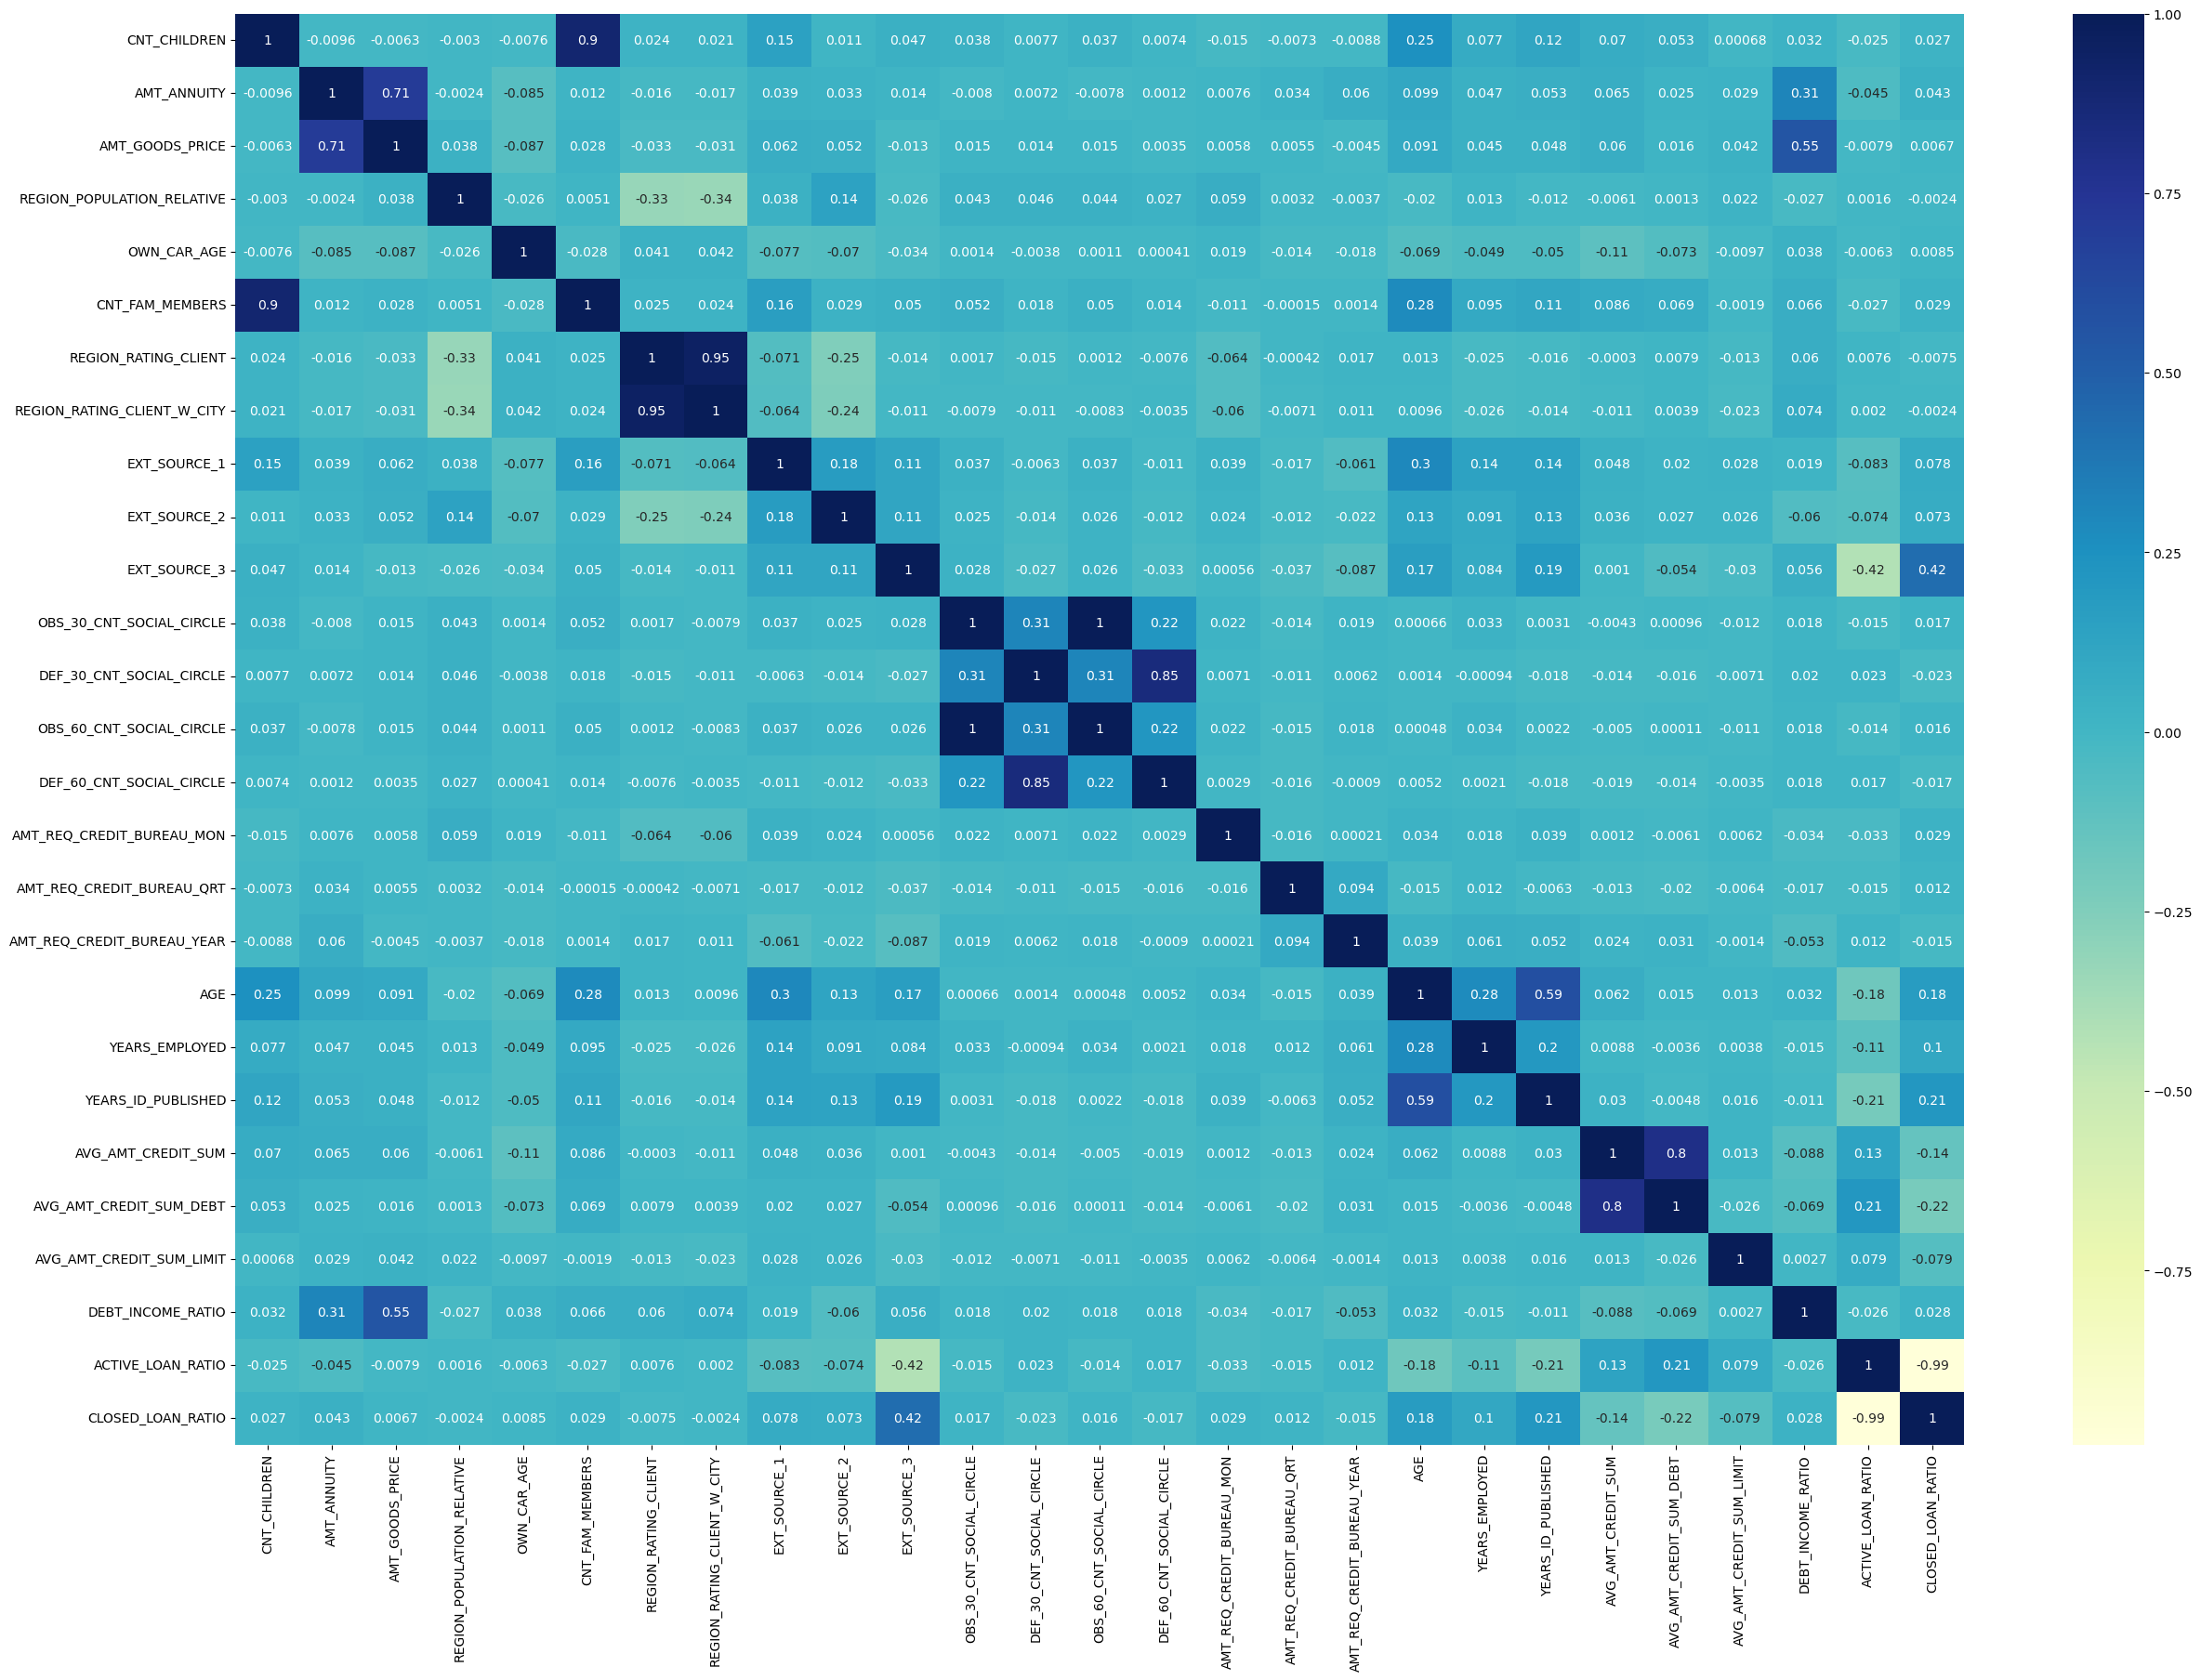

In [48]:
numerical_var = unclean_merged_data.select_dtypes(include=np.number).columns.tolist()
remove_numerical_var = ["SK_ID_CURR", "TARGET"]

for var in remove_numerical_var:
    numerical_var.remove(var)

corr_matrix = unclean_merged_data[numerical_var].corr()

# plot heat map
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns,yticklabels=corr_matrix.columns,annot=True,cmap="YlGnBu", ax=ax)

In [49]:
# Identify variables with highest correlation
# Set lower half of matrix to NaN
corr_matrix_top = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Convert to pivot table structure (panda series) to have both variables and their correlation in same row
corr_table = corr_matrix_top.stack()

# Locate variables with correlation > 0.5 (or indicated number)
corr_table_gt_0_5 = corr_table.loc[lambda x: x > 0.4]
print(corr_table_gt_0_5)
print ("\n")
# Locate variables with correlation > -0.5 (or indicated number)
corr_table_lt_neg_0_5 = corr_table.loc[lambda x: x < -0.4]
print(corr_table_lt_neg_0_5)

CNT_CHILDREN              CNT_FAM_MEMBERS               0.90
AMT_ANNUITY               AMT_GOODS_PRICE               0.71
AMT_GOODS_PRICE           DEBT_INCOME_RATIO             0.55
REGION_RATING_CLIENT      REGION_RATING_CLIENT_W_CITY   0.95
EXT_SOURCE_3              CLOSED_LOAN_RATIO             0.42
OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE      1.00
DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE      0.85
AGE                       YEARS_ID_PUBLISHED            0.59
AVG_AMT_CREDIT_SUM        AVG_AMT_CREDIT_SUM_DEBT       0.80
dtype: float64


EXT_SOURCE_3       ACTIVE_LOAN_RATIO   -0.42
ACTIVE_LOAN_RATIO  CLOSED_LOAN_RATIO   -0.99
dtype: float64


####  Highly correlated variables (r > 0.4 or -0.4)

| Variable Pairs                                              | Correlation | Recommendation                                  |
| ---------------------------------------------------------- | ----------- | ---------------------------------------------- |
| CNT_CHILDREN & CNT_FAM_MEMBERS                             | 0.9         | Drop CNT_CHILDREN  |
| AMT_ANNUITY & AMT_GOODS_PRICE                              | 0.71        | Drop AMT_GOODS_PRICE  |
| AMT_GOODS_PRICE & DEBT_INCOME_RATIO             | 0.55        | Dropped AMT_GOODS_PRICE above                   |
| REGION_RATING_CLIENT & REGION_RATING_CLIENT_W_CITY        | 0.95        | Drop REGION_RATING_CLIENT                        |
| OBS_30_CNT_SOCIAL_CIRCLE & OBS_60_CNT_SOCIAL_CIRCLE         | 1.00        | Drop OBS_30_CNT_SOCIAL_CIRCLE                    |
| DEF_30_CNT_SOCIAL_CIRCLE & DEF_60_CNT_SOCIAL_CIRCLE         | 0.85        | Drop DEF_30_CNT_SOCIAL_CIRCLE                    |
| AGE & YEARS_ID_PUBLISHED                                   | 0.59        | Drop YEARS_ID_PUBLISHED                          |
| ACTIVE_LOAN_RATIO & CLOSED_LOAN_RATIO                                   | 0.99        | Drop CLOSED_LOAN_RATIO                          |
| EXT_SOURCE_3 & ACTIVE_LOAN_RATIO               | 0.42        | Drop EXT_SOURCE_3                     |  
| EXT_SOURCE_3 & CLOSED_LOAN_RATIO               | 0.42       | Dropped EXT_SOURCE_3 above                     |  
| AVG_AMT_CREDIT_SUM & AVG_AMT_CREDIT_SUM_DEBT               | 0.80        | Drop AVG_AMT_CREDIT_SUM_DEBT                     |


In [50]:
# Drop redundant variables
unclean_merged_data.drop(["CNT_CHILDREN","AMT_GOODS_PRICE", "REGION_RATING_CLIENT","OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "YEARS_ID_PUBLISHED", "AVG_AMT_CREDIT_SUM_DEBT","CLOSED_LOAN_RATIO","EXT_SOURCE_3"], axis=1, inplace=True)
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  AMT_ANNUITY  \
22          100026       0            N               N     32521.50   
35          100041       0            N               N     44509.50   
45          100052       0            N               Y      9000.00   
53          100061       0            N               Y     16164.00   
77          100089       0            N               Y     15781.50   
...            ...     ...          ...             ...          ...   
307353      456078       0            N               Y     21339.00   
307383      456108       1            N               Y     33444.00   
307385      456110       0            Y               Y      9000.00   
307436      456174       0            N               N     17064.00   
307457      456196       0            N               Y     18000.00   

            NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
22                   Working  Secondary / secondary special   
35                   Working               Higher education   
45                   Working  Secondary / secondary special   
53      Commercial associate               Higher education   
77                   Working  Secondary / secondary special   
...                      ...                            ...   
307353               Working  Secondary / secondary special   
307383               Working  Secondary / secondary special   
307385  Commercial associate  Secondary / secondary special   
307436               Working  Secondary / secondary special   
307457  Commercial associate  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
22                   Married   Rented apartment                        0.02   
35                   Married  House / apartment                        0.01   
45            Civil marriage  House / apartment                        0.01   
53                   Married  House / apartment                        0.01   
77            Civil marriage  House / apartment                        0.03   
...                      ...                ...                         ...   
307353  Single / not married  House / apartment                        0.04   
307383               Married  House / apartment                        0.02   
307385               Married  House / apartment                        0.01   
307436               Married  House / apartment                        0.02   
307457        Civil marriage  House / apartment                        0.04   

        ...  AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT  \
22      ...                       0.00                      0.00   
35      ...                       0.00                      0.00   
45      ...                        NaN                       NaN   
53      ...                       0.00                      0.00   
77      ...                       0.00                      0.00   
...     ...                        ...                       ...   
307353  ...                        NaN                       NaN   
307383  ...                       0.00                      0.00   
307385  ...                       0.00                      0.00   
307436  ...                       0.00                      0.00   
307457  ...                       2.00                      0.00   

        AMT_REQ_CREDIT_BUREAU_YEAR  ORGANIZATION_TYPE  AGE  YEARS_EMPLOYED  \
22                            5.00      Self-employed   30              11   
35                            0.00      Self-employed   33               3   
45                             NaN      Self-employed   21               2   
53                            5.00      Self-employed   28               3   
77                            3.00      Self-employed   26               7   
...                            ...                ...  ...             ...   
307353                         NaN      Self-employed   23               0

## 2.3 Data Selection

#### Dropping unncessary columns 
- SK_ID_CURR
- ORGANIZATION_TYPE

In [51]:
# Dropping Organization Type cause it is already filtered to Self-employed
clean_merged_data = unclean_merged_data.drop(['SK_ID_CURR','ORGANIZATION_TYPE'], axis=1)

## 3. Grouping and Screening



### 3.1 Fine Classing
#### Generating WOE Bins 
Woebin() generate groupings as a python dictionary object and also provides a method to plot WOE for the bins.  It will optimize for IV, but will not attempt to make the trend monotonic.

Scorecardpy will automatically do the one-hot encoding as part of the binning process so it is not neccesary to do that in advance.

It will also create missing bins for all the variables, so there is no need to imput or remove missing values.

In [52]:
bins = sc.woebin(clean_merged_data, y='TARGET')

# make it easy to read the bins
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


Binning on 8270 rows and 26 columns in 00:00:25
OCCUPATION_TYPE  : 


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing    739   
1  OCCUPATION_TYPE  IT staff%,%Medicine staff%,%Accountants%,%Core...   1241   
2  OCCUPATION_TYPE                           Managers%,%Realty agents    441   
3  OCCUPATION_TYPE  High skill tech staff%,%Sales staff%,%Cooking ...   3376   
4  OCCUPATION_TYPE                                           Laborers   1474   
5  OCCUPATION_TYPE  Drivers%,%Security staff%,%Secretaries%,%Waite...    999   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.09   643   96     0.13 -0.01    0.00      0.07   
1         0.15  1140  101     0.08 -0.54    0.04      0.07   
2         0.05   393   48     0.11 -0.21    0.00      0.07   
3         0.41  2951  425     0.13 -0.05    0.00      0.07   
4         0.18  1251  223     0.15  0.16    0.01      0.07   
5         0.12   805  194     0.19  0.47    0.03      0.07   

                                              breaks  is_special_values  
0                                            missing               True  
1  IT staff%,%Medicine staff%,%Accountants%,%Core...              False  
2                           Managers%,%Realty agents              False  
3  High skill tech staff%,%Sales staff%,%Cooking ...              False  
4                                           Laborers              False  
5  Drivers%,%Security staff%,%Secretaries%,%Waite...              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM_LIMIT  : 


variable            bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM_LIMIT        missing   2424         0.29  2072  352   
1  AVG_AMT_CREDIT_SUM_LIMIT  [-inf,4000.0)   5020         0.61  4394  626   
2  AVG_AMT_CREDIT_SUM_LIMIT   [4000.0,inf)    826         0.10   717  109   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.15  0.12    0.00      0.01  missing               True  
1     0.12 -0.06    0.00      0.01   4000.0              False  
2     0.13  0.00    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------
ACTIVE_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  ACTIVE_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  ACTIVE_LOAN_RATIO  [-inf,0.08)   1380         0.17  1251  129     0.09   
2  ACTIVE_LOAN_RATIO  [0.08,0.22)    499         0.06   468   31     0.06   
3  ACTIVE_LOAN_RATIO  [0.22,0.52)   2437         0.29  2148  289     0.12   
4  ACTIVE_LOAN_RATIO   [0.52,inf)   2145         0.26  1787  358     0.17   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.09  missing               True  
1 -0.38    0.02      0.09     0.08              False  
2 -0.83    0.03      0.09     0.22              False  
3 -0.12    0.00      0.09     0.52              False  
4  0.28    0.02      0.09      inf              False

----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


variable                                              bin  \
0  NAME_EDUCATION_TYPE               Academic degree%,%Higher education   
1  NAME_EDUCATION_TYPE                                Incomplete higher   
2  NAME_EDUCATION_TYPE  Secondary / secondary special%,%Lower secondary   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   1553         0.19  1430  123     0.08 -0.56    0.05      0.06   
1    556         0.07   479   77     0.14  0.06    0.00      0.06   
2   6161         0.74  5274  887     0.14  0.11    0.01      0.06   

                                            breaks  is_special_values  
0               Academic degree%,%Higher education              False  
1                                Incomplete higher              False  
2  Secondary / secondary special%,%Lower secondary              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_2      missing     19         0.00    17    2     0.11 -0.25   
1  EXT_SOURCE_2  [-inf,0.08)    454         0.05   321  133     0.29  1.01   
2  EXT_SOURCE_2  [0.08,0.34)   1926         0.23  1555  371     0.19  0.46   
3  EXT_SOURCE_2  [0.34,0.66)   4625         0.56  4125  500     0.11 -0.22   
4  EXT_SOURCE_2   [0.66,inf)   1246         0.15  1165   81     0.07 -0.78   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.23  missing               True  
1    0.08      0.23     0.08              False  
2    0.06      0.23     0.34              False  
3    0.03      0.23     0.66              False  
4    0.07      0.23      inf              False

----------------------------------------------------------------------------------------------------
CNT_FAM_MEMBERS  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  CNT_FAM_MEMBERS  [-inf,2.0)   1913         0.23  1627  286     0.15  0.15   
1  CNT_FAM_MEMBERS   [2.0,3.0)   3078         0.37  2676  402     0.13 -0.01   
2  CNT_FAM_MEMBERS   [3.0,4.0)   2098         0.25  1836  262     0.12 -0.06   
3  CNT_FAM_MEMBERS   [4.0,inf)   1181         0.14  1044  137     0.12 -0.14   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.01    2.0              False  
1    0.00      0.01    3.0              False  
2    0.00      0.01    4.0              False  
3    0.00      0.01    inf              False

----------------------------------------------------------------------------------------------------
DEF_60_CNT_SOCIAL_CIRCLE  : 


variable         bin  count  count_distr  good  bad  \
0  DEF_60_CNT_SOCIAL_CIRCLE     missing     35         0.00    34    1   
1  DEF_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)   7385         0.89  6440  945   
2  DEF_60_CNT_SOCIAL_CIRCLE   [1.0,inf)    850         0.10   709  141   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.03 -1.64    0.01      0.02  missing               True  
1     0.13 -0.03    0.00      0.02      1.0              False  
2     0.17  0.27    0.01      0.02      inf              False

----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  : 


variable         bin  count  count_distr  good  bad  \
0  OBS_60_CNT_SOCIAL_CIRCLE     missing     35         0.00    34    1   
1  OBS_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)   4124         0.50  3526  598   
2  OBS_60_CNT_SOCIAL_CIRCLE   [1.0,3.0)   2276         0.28  2011  265   
3  OBS_60_CNT_SOCIAL_CIRCLE   [3.0,4.0)    625         0.08   566   59   
4  OBS_60_CNT_SOCIAL_CIRCLE   [4.0,6.0)    677         0.08   590   87   
5  OBS_60_CNT_SOCIAL_CIRCLE   [6.0,inf)    533         0.06   456   77   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.03 -1.64    0.01      0.03  missing               True  
1     0.15  0.11    0.01      0.03      1.0              False  
2     0.12 -0.14    0.01      0.03      3.0              False  
3     0.09 -0.37    0.01      0.03      4.0              False  
4     0.13 -0.03    0.00      0.03      6.0              False  
5     0.14  0.11    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


variable                                      bin  count  \
0  DEBT_INCOME_RATIO                [-inf,1.2000000000000002)   1253   
1  DEBT_INCOME_RATIO                 [1.2000000000000002,2.7)   4501   
2  DEBT_INCOME_RATIO                 [2.7,3.0000000000000004)    698   
3  DEBT_INCOME_RATIO  [3.0000000000000004,3.4000000000000004)    616   
4  DEBT_INCOME_RATIO                 [3.4000000000000004,inf)   1202   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.15  1137  116     0.09 -0.39    0.02      0.04   
1         0.54  3900  601     0.13  0.02    0.00      0.04   
2         0.08   619   79     0.11 -0.17    0.00      0.04   
3         0.07   501  115     0.19  0.42    0.02      0.04   
4         0.15  1026  176     0.15  0.13    0.00      0.04   

               breaks  is_special_values  
0  1.2000000000000002              False  
1                 2.7              False  
2  3.0000000000000004              False  
3  3.4000000000000004              False  
4                 inf              False

----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_QRT  : 


variable         bin  count  count_distr  good  bad  \
0  AMT_REQ_CREDIT_BUREAU_QRT     missing   1761         0.21  1489  272   
1  AMT_REQ_CREDIT_BUREAU_QRT  [-inf,1.0)   5302         0.64  4613  689   
2  AMT_REQ_CREDIT_BUREAU_QRT   [1.0,inf)   1207         0.15  1081  126   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.15  0.19    0.01      0.02  missing               True  
1     0.13 -0.01    0.00      0.02      1.0              False  
2     0.10 -0.26    0.01      0.02      inf              False

----------------------------------------------------------------------------------------------------
OWN_CAR_AGE  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  OWN_CAR_AGE      missing   5447         0.66  4665  782     0.14  0.10   
1  OWN_CAR_AGE   [-inf,5.0)    537         0.06   485   52     0.10 -0.34   
2  OWN_CAR_AGE   [5.0,10.0)    711         0.09   658   53     0.07 -0.63   
3  OWN_CAR_AGE  [10.0,15.0)    663         0.08   575   88     0.13  0.01   
4  OWN_CAR_AGE   [15.0,inf)    912         0.11   800  112     0.12 -0.08   

   bin_iv  total_iv   breaks  is_special_values  
0    0.01      0.04  missing               True  
1    0.01      0.04      5.0              False  
2    0.03      0.04     10.0              False  
3    0.00      0.04     15.0              False  
4    0.00      0.04      inf              False

----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS  : 


variable                               bin  count  count_distr  \
0  NAME_FAMILY_STATUS                   Widow%,%Married   4629         0.56   
1  NAME_FAMILY_STATUS                    Civil marriage   1153         0.14   
2  NAME_FAMILY_STATUS  Single / not married%,%Separated   2488         0.30   

   good  bad  badprob   woe  bin_iv  total_iv  \
0  4083  546     0.12 -0.12    0.01      0.02   
1   987  166     0.14  0.11    0.00      0.02   
2  2113  375     0.15  0.16    0.01      0.02   

                             breaks  is_special_values  
0                   Widow%,%Married              False  
1                    Civil marriage              False  
2  Single / not married%,%Separated              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_1      missing   3569         0.43  3015  554     0.16  0.19   
1  EXT_SOURCE_1  [-inf,0.18)    737         0.09   577  160     0.22  0.61   
2  EXT_SOURCE_1  [0.18,0.44)   2596         0.31  2294  302     0.12 -0.14   
3  EXT_SOURCE_1  [0.44,0.52)    520         0.06   485   35     0.07 -0.74   
4  EXT_SOURCE_1   [0.52,inf)    848         0.10   812   36     0.04 -1.23   

   bin_iv  total_iv   breaks  is_special_values  
0    0.02      0.19  missing               True  
1    0.04      0.19     0.18              False  
2    0.01      0.19     0.44              False  
3    0.03      0.19     0.52              False  
4    0.10      0.19      inf              False

----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


variable                                   bin  count  count_distr  \
0  NAME_INCOME_TYPE  State servant%,%Commercial associate   2186         0.26   
1  NAME_INCOME_TYPE                               Working   6084         0.74   

   good  bad  badprob   woe  bin_iv  total_iv  \
0  1943  243     0.11 -0.19    0.01      0.01   
1  5240  844     0.14  0.06    0.00      0.01   

                                 breaks  is_special_values  
0  State servant%,%Commercial associate              False  
1                               Working              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_CAR   Y   2823         0.34  2518  305     0.11 -0.22    0.02   
1  FLAG_OWN_CAR   N   5447         0.66  4665  782     0.14  0.10    0.01   

   total_iv breaks  is_special_values  
0      0.02      Y              False  
1      0.02      N              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_REALTY  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_REALTY   Y   5280         0.64  4600  680     0.13 -0.02    0.00   
1  FLAG_OWN_REALTY   N   2990         0.36  2583  407     0.14  0.04    0.00   

   total_iv breaks  is_special_values  
0      0.00      Y              False  
1      0.00      N              False

----------------------------------------------------------------------------------------------------
AGE  : 


variable          bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0      AGE  [-inf,24.0)    859         0.10   721  138     0.16  0.23    0.01   
1      AGE  [24.0,27.0)   1154         0.14  1014  140     0.12 -0.09    0.00   
2      AGE  [27.0,29.0)   1569         0.19  1337  232     0.15  0.14    0.00   
3      AGE  [29.0,35.0)   4082         0.49  3587  495     0.12 -0.09    0.00   
4      AGE   [35.0,inf)    606         0.07   524   82     0.14  0.03    0.00   

   total_iv breaks  is_special_values  
0      0.02   24.0              False  
1      0.02   27.0              False  
2      0.02   29.0              False  
3      0.02   35.0              False  
4      0.02    inf              False

----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_MON  : 


variable         bin  count  count_distr  good  bad  \
0  AMT_REQ_CREDIT_BUREAU_MON     missing   1761         0.21  1489  272   
1  AMT_REQ_CREDIT_BUREAU_MON  [-inf,1.0)   5618         0.68  4902  716   
2  AMT_REQ_CREDIT_BUREAU_MON   [1.0,inf)    891         0.11   792   99   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.15  0.19    0.01      0.01  missing               True  
1     0.13 -0.04    0.00      0.01      1.0              False  
2     0.11 -0.19    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_YEAR  : 


variable         bin  count  count_distr  good  bad  \
0  AMT_REQ_CREDIT_BUREAU_YEAR     missing   1761         0.21  1489  272   
1  AMT_REQ_CREDIT_BUREAU_YEAR  [-inf,1.0)   1625         0.20  1424  201   
2  AMT_REQ_CREDIT_BUREAU_YEAR   [1.0,2.0)   1657         0.20  1461  196   
3  AMT_REQ_CREDIT_BUREAU_YEAR   [2.0,3.0)   1317         0.16  1140  177   
4  AMT_REQ_CREDIT_BUREAU_YEAR   [3.0,4.0)    790         0.10   694   96   
5  AMT_REQ_CREDIT_BUREAU_YEAR   [4.0,5.0)    489         0.06   424   65   
6  AMT_REQ_CREDIT_BUREAU_YEAR   [5.0,inf)    631         0.08   551   80   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.15  0.19    0.01      0.01  missing               True  
1     0.12 -0.07    0.00      0.01      1.0              False  
2     0.12 -0.12    0.00      0.01      2.0              False  
3     0.13  0.03    0.00      0.01      3.0              False  
4     0.12 -0.09    0.00      0.01      4.0              False  
5     0.13  0.01    0.00      0.01      5.0              False  
6     0.13 -0.04    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM  : 


variable                  bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM              missing   1809         0.22  1529  280   
1  AVG_AMT_CREDIT_SUM       [-inf,40000.0)    691         0.08   581  110   
2  AVG_AMT_CREDIT_SUM   [40000.0,120000.0)   2509         0.30  2219  290   
3  AVG_AMT_CREDIT_SUM  [120000.0,140000.0)    419         0.05   356   63   
4  AVG_AMT_CREDIT_SUM  [140000.0,680000.0)   2339         0.28  2035  304   
5  AVG_AMT_CREDIT_SUM       [680000.0,inf)    503         0.06   463   40   

   badprob   woe  bin_iv  total_iv    breaks  is_special_values  
0     0.15  0.19    0.01      0.04   missing               True  
1     0.16  0.22    0.00      0.04   40000.0              False  
2     0.12 -0.15    0.01      0.04  120000.0              False  
3     0.15  0.16    0.00      0.04  140000.0              False  
4     0.13 -0.01    0.00      0.04  680000.0              False  
5     0.08 -0.56    0.02      0.04       inf              False

----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


variable                bin  count  count_distr  good  bad  badprob  \
0  AMT_ANNUITY      [-inf,8000.0)    435         0.05   394   41     0.09   
1  AMT_ANNUITY   [8000.0,16000.0)   3172         0.38  2805  367     0.12   
2  AMT_ANNUITY  [16000.0,17000.0)    472         0.06   409   63     0.13   
3  AMT_ANNUITY  [17000.0,19000.0)    658         0.08   535  123     0.19   
4  AMT_ANNUITY      [19000.0,inf)   3533         0.43  3040  493     0.14   

    woe  bin_iv  total_iv   breaks  is_special_values  
0 -0.37    0.01      0.03   8000.0              False  
1 -0.15    0.01      0.03  16000.0              False  
2  0.02    0.00      0.03  17000.0              False  
3  0.42    0.02      0.03  19000.0              False  
4  0.07    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE  : 


variable                                                bin  \
0  NAME_HOUSING_TYPE  Co-op apartment%,%Office apartment%,%House / a...   
1  NAME_HOUSING_TYPE  Rented apartment%,%With parents%,%Municipal ap...   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   6694         0.81  5850  844     0.13 -0.05    0.00      0.01   
1   1576         0.19  1333  243     0.15  0.19    0.01      0.01   

                                              breaks  is_special_values  
0  Co-op apartment%,%Office apartment%,%House / a...              False  
1  Rented apartment%,%With parents%,%Municipal ap...              False

----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


variable            bin  count  count_distr  good  bad  \
0  REGION_POPULATION_RELATIVE   [-inf,0.005)    463         0.06   383   80   
1  REGION_POPULATION_RELATIVE  [0.005,0.021)   5246         0.63  4507  739   
2  REGION_POPULATION_RELATIVE  [0.021,0.027)    862         0.10   780   82   
3  REGION_POPULATION_RELATIVE  [0.027,0.031)    702         0.08   602  100   
4  REGION_POPULATION_RELATIVE    [0.031,inf)    997         0.12   911   86   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.17  0.32    0.01      0.05  0.005              False  
1     0.14  0.08    0.00      0.05  0.021              False  
2     0.10 -0.36    0.01      0.05  0.027              False  
3     0.14  0.09    0.00      0.05  0.031              False  
4     0.09 -0.47    0.02      0.05    inf              False

----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  YEARS_EMPLOYED  [-inf,5.0)   6062         0.73  5188  874     0.14  0.11   
1  YEARS_EMPLOYED   [5.0,8.0)   1428         0.17  1280  148     0.10 -0.27   
2  YEARS_EMPLOYED   [8.0,inf)    780         0.09   715   65     0.08 -0.51   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.04    5.0              False  
1    0.01      0.04    8.0              False  
2    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


variable         bin  count  count_distr  good  bad  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,3.0)   6863         0.83  6037  826   
1  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   1407         0.17  1146  261   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.12 -0.10    0.01      0.04    3.0              False  
1     0.19  0.41    0.03      0.04    inf              False

----------------------------------------------------------------------------------------------------


{'AVG_AMT_CREDIT_SUM': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_MON': <Figure size 640x480 with 2 Axes>,
 'AGE': <Figure size 640x480 with 2 Axes>,
 'CNT_FAM_MEMBERS': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM_LIMIT': <Figure size 640x480 with 2 Axes>,
 'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'OBS_60_CNT_SOCIAL_CIRCLE': <Figure size 640x480 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_QRT': <Figure size 640x480 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'OWN_CAR_AGE': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure si

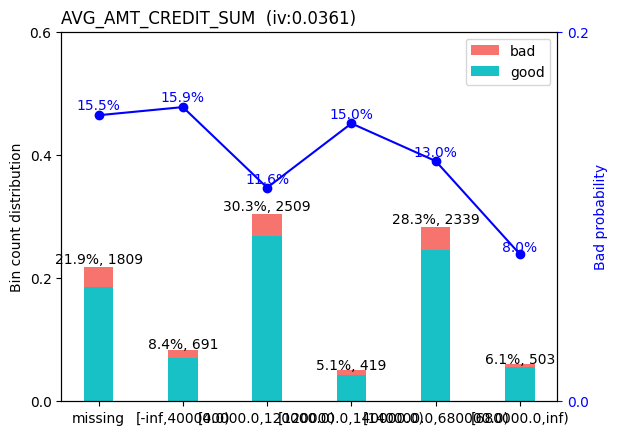

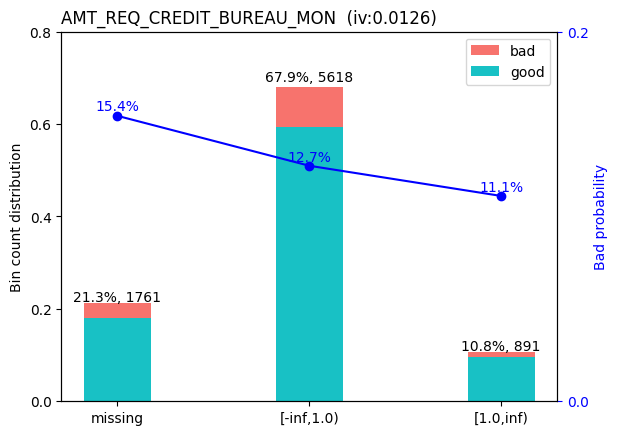

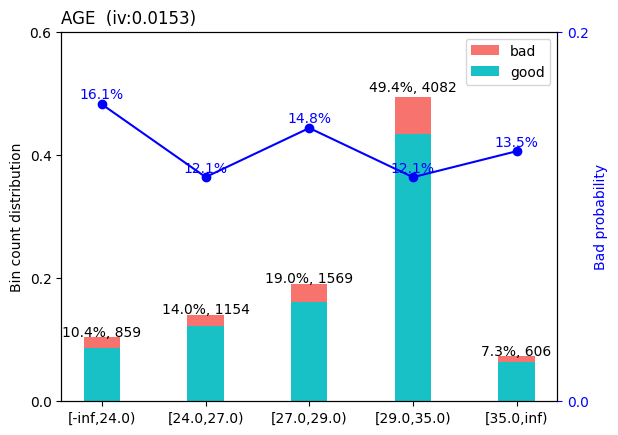

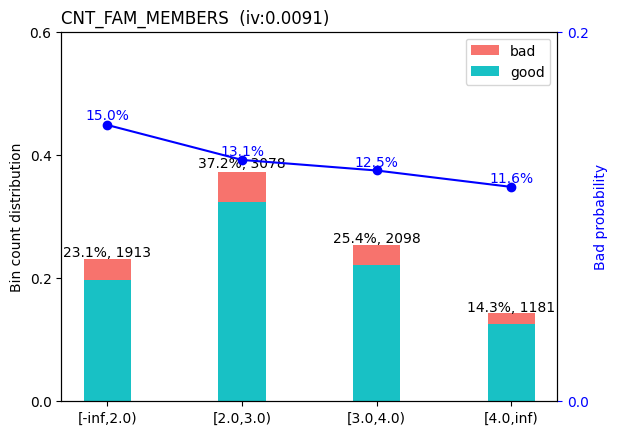

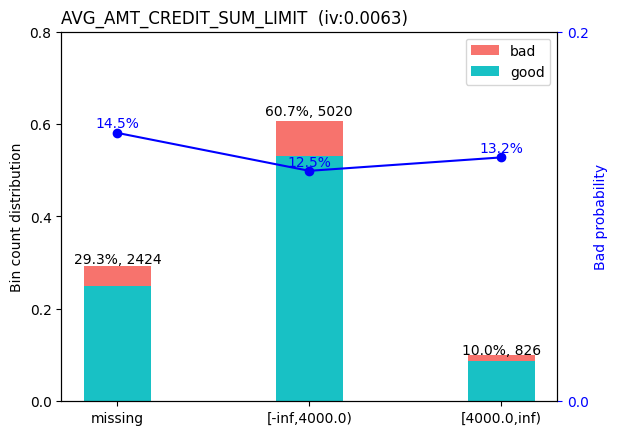

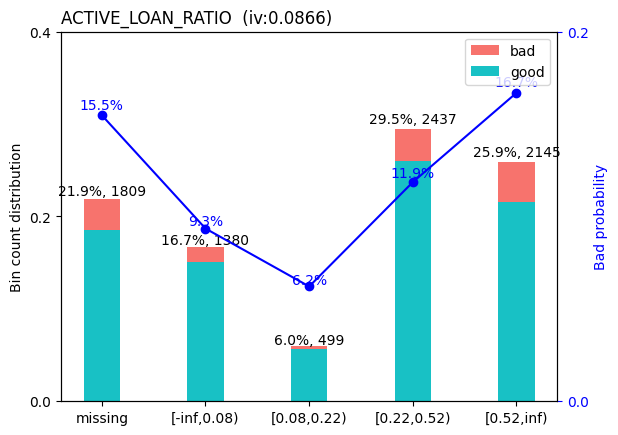

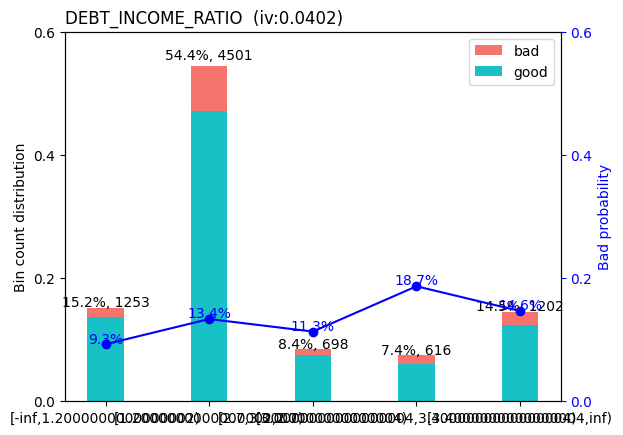

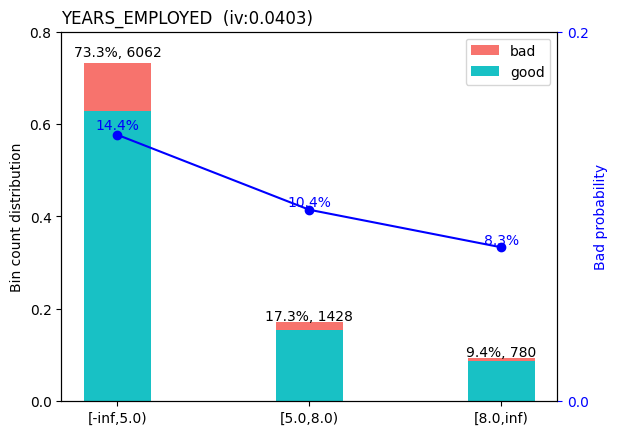

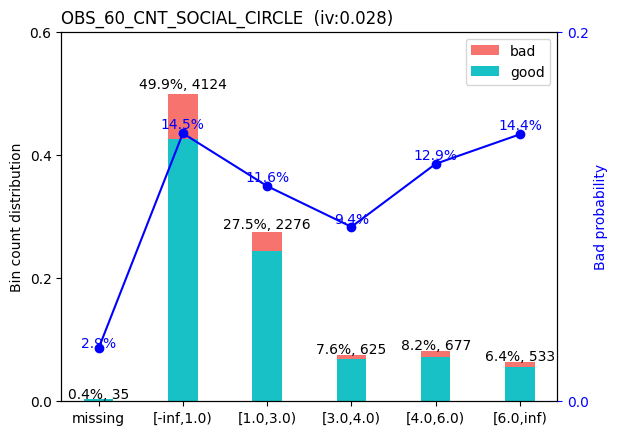

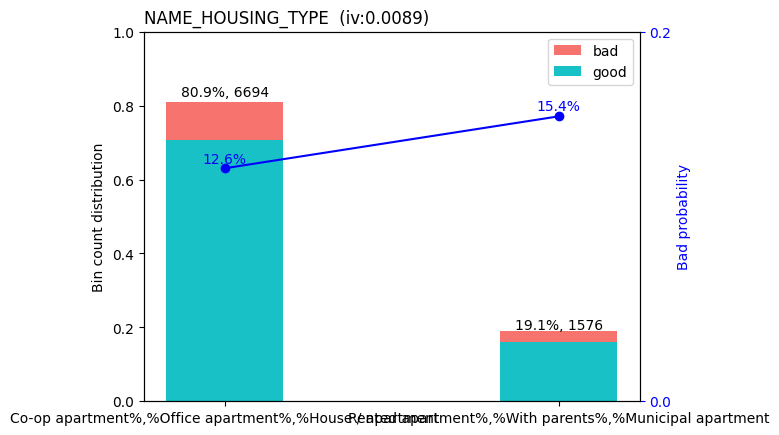

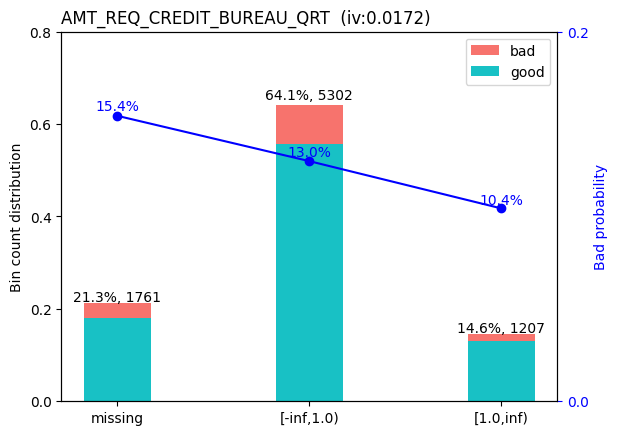

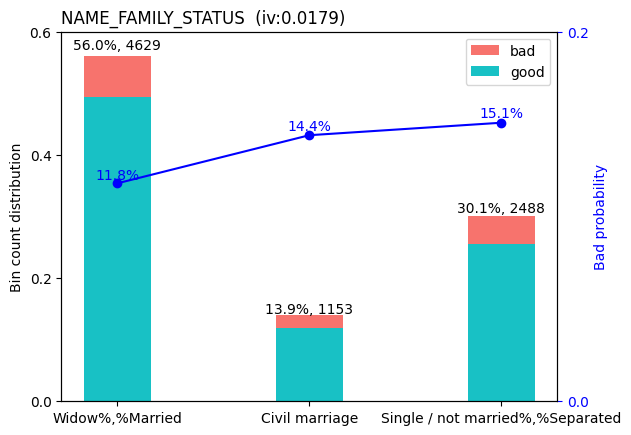

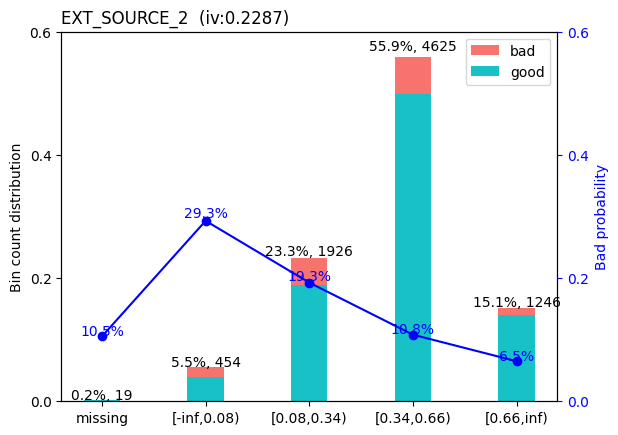

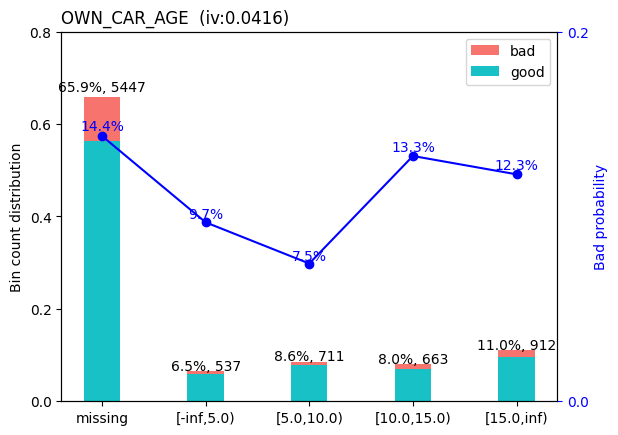

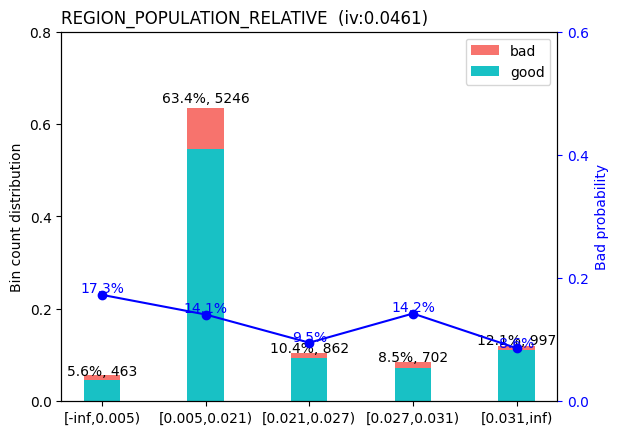

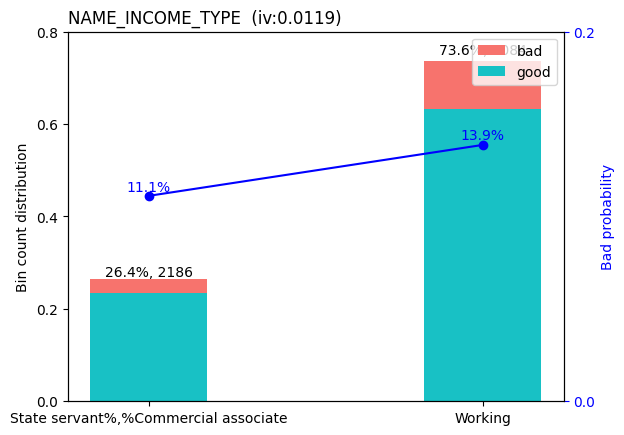

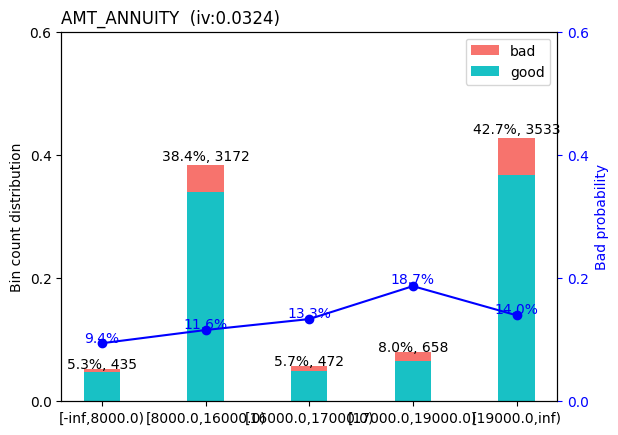

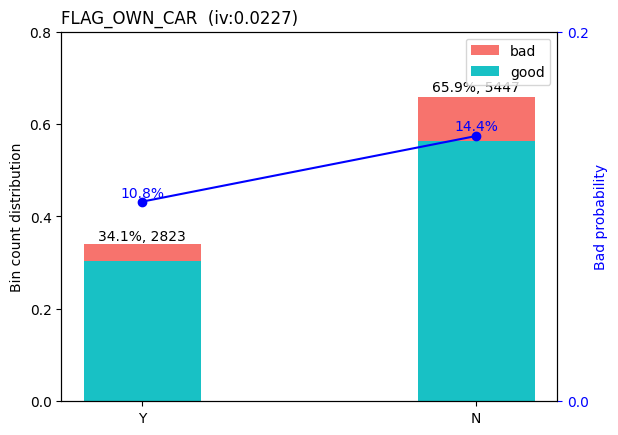

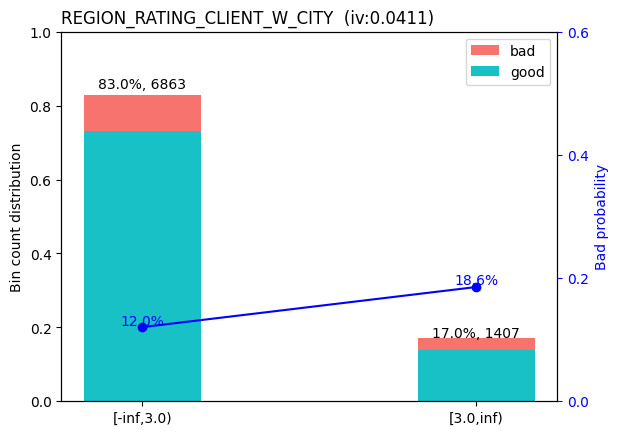

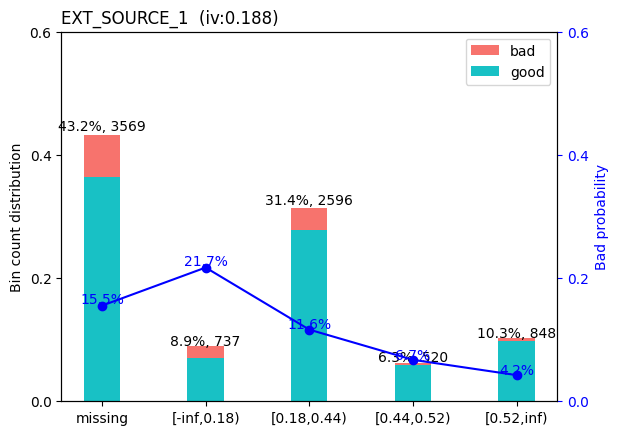

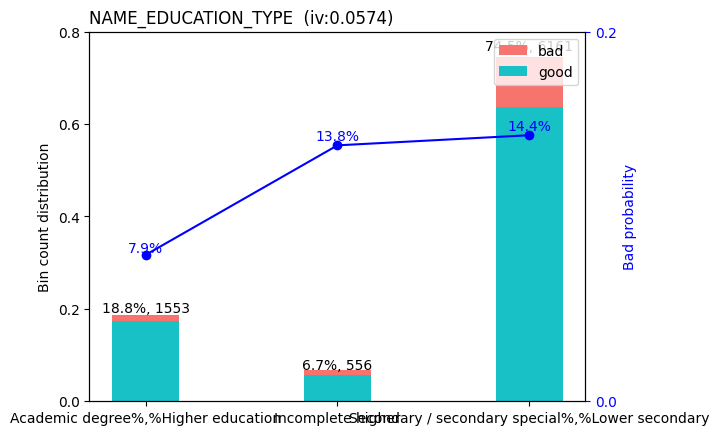

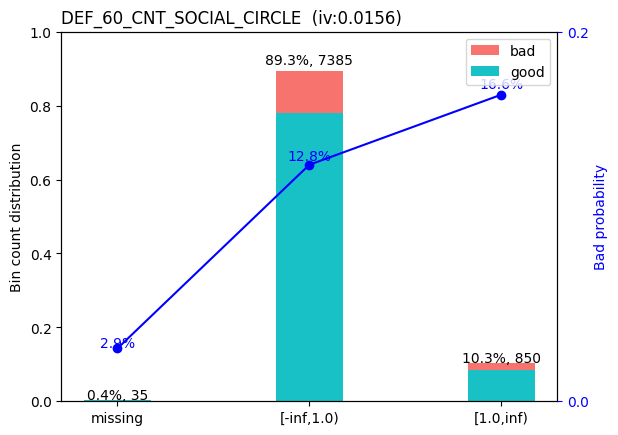

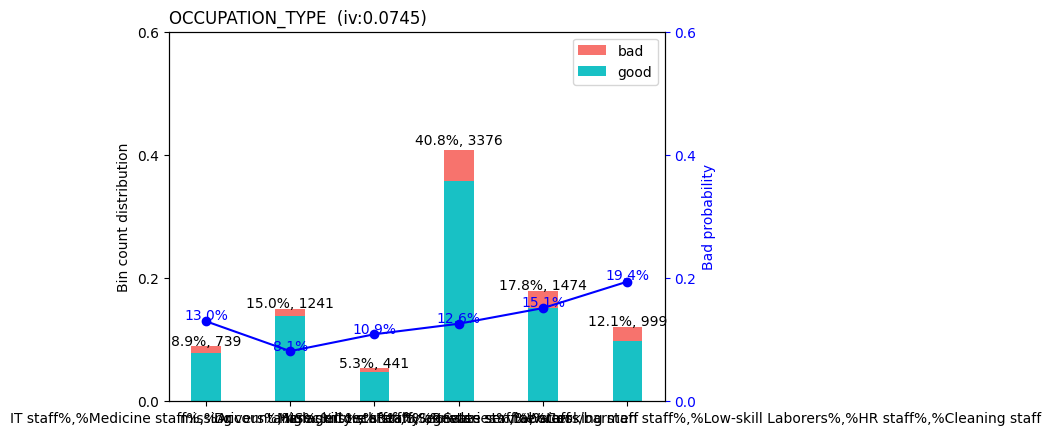

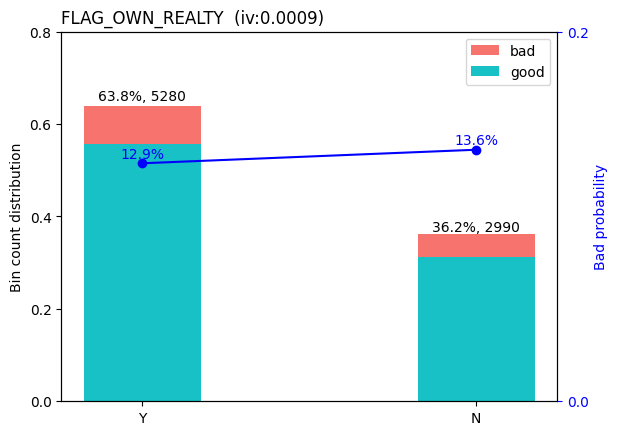

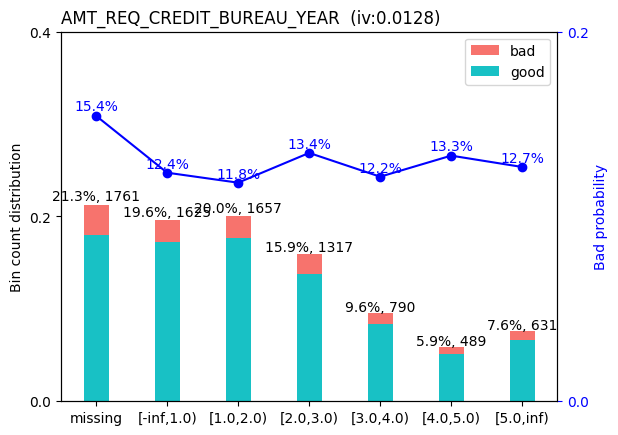

In [635]:
sc.woebin_plot(bins)

### Drop columns with IV < 0.02 or >0.5
| Variable                          | IV    |
| --------------------------------- | ----- |
|FLAG_OWN_REALTY                |   0.0009  |
|AVG_AMT_CREDIT_SUM_LIMIT       |   0.0063  |
|NAME_HOUSING_TYPE              |   0.0089  |
|CNT_FAM_MEMBERS                |   0.0091  |
|NAME_INCOME_TYPE               |   0.0119  |
|AMT_REQ_CREDIT_BUREAU_MON      |   0.0126  |
|AMT_REQ_CREDIT_BUREAU_YEAR     |   0.0128  |
|AGE                            |   0.0153  |
|DEF_60_CNT_SOCIAL_CIRCLE       |   0.0156  |
|AMT_REQ_BUREAU_QRT             |   0.0172  |
|NAME_FAMILY_STATUS             |   0.0179  |



In [636]:
## Drop variable with IV < 0.02
columns_to_drop = [
    "AGE",
    "CNT_FAM_MEMBERS",
    "NAME_FAMILY_STATUS",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "AVG_AMT_CREDIT_SUM_LIMIT",
    "NAME_INCOME_TYPE",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_MON"
]
for col in columns_to_drop:
    clean_merged_data.drop(col, axis=1, inplace=True)

clean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8270 entries, 22 to 307457
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       8270 non-null   int64  
 1   FLAG_OWN_CAR                 8270 non-null   object 
 2   AMT_ANNUITY                  8270 non-null   float64
 3   NAME_EDUCATION_TYPE          8270 non-null   object 
 4   REGION_POPULATION_RELATIVE   8270 non-null   float64
 5   OWN_CAR_AGE                  2823 non-null   float64
 6   OCCUPATION_TYPE              7531 non-null   object 
 7   REGION_RATING_CLIENT_W_CITY  8270 non-null   int64  
 8   EXT_SOURCE_1                 4701 non-null   float64
 9   EXT_SOURCE_2                 8251 non-null   float64
 10  OBS_60_CNT_SOCIAL_CIRCLE     8235 non-null   float64
 11  YEARS_EMPLOYED               8270 non-null   int32  
 12  AVG_AMT_CREDIT_SUM           6461 non-null   float64
 13  DEBT_INCOME_RATIO   

### Review monotonicity after dropping redundant predictors

[INFO] creating woe binning ...
REGION_POPULATION_RELATIVE  : 


variable            bin  count  count_distr  good  bad  \
0  REGION_POPULATION_RELATIVE   [-inf,0.005)    463         0.06   383   80   
1  REGION_POPULATION_RELATIVE  [0.005,0.021)   5246         0.63  4507  739   
2  REGION_POPULATION_RELATIVE  [0.021,0.027)    862         0.10   780   82   
3  REGION_POPULATION_RELATIVE  [0.027,0.031)    702         0.08   602  100   
4  REGION_POPULATION_RELATIVE    [0.031,inf)    997         0.12   911   86   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.17  0.32    0.01      0.05  0.005              False  
1     0.14  0.08    0.00      0.05  0.021              False  
2     0.10 -0.36    0.01      0.05  0.027              False  
3     0.14  0.09    0.00      0.05  0.031              False  
4     0.09 -0.47    0.02      0.05    inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM  : 


variable                  bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM              missing   1809         0.22  1529  280   
1  AVG_AMT_CREDIT_SUM       [-inf,40000.0)    691         0.08   581  110   
2  AVG_AMT_CREDIT_SUM   [40000.0,120000.0)   2509         0.30  2219  290   
3  AVG_AMT_CREDIT_SUM  [120000.0,140000.0)    419         0.05   356   63   
4  AVG_AMT_CREDIT_SUM  [140000.0,680000.0)   2339         0.28  2035  304   
5  AVG_AMT_CREDIT_SUM       [680000.0,inf)    503         0.06   463   40   

   badprob   woe  bin_iv  total_iv    breaks  is_special_values  
0     0.15  0.19    0.01      0.04   missing               True  
1     0.16  0.22    0.00      0.04   40000.0              False  
2     0.12 -0.15    0.01      0.04  120000.0              False  
3     0.15  0.16    0.00      0.04  140000.0              False  
4     0.13 -0.01    0.00      0.04  680000.0              False  
5     0.08 -0.56    0.02      0.04       inf              False

----------------------------------------------------------------------------------------------------
ACTIVE_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  ACTIVE_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  ACTIVE_LOAN_RATIO  [-inf,0.08)   1380         0.17  1251  129     0.09   
2  ACTIVE_LOAN_RATIO  [0.08,0.22)    499         0.06   468   31     0.06   
3  ACTIVE_LOAN_RATIO  [0.22,0.52)   2437         0.29  2148  289     0.12   
4  ACTIVE_LOAN_RATIO   [0.52,inf)   2145         0.26  1787  358     0.17   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.09  missing               True  
1 -0.38    0.02      0.09     0.08              False  
2 -0.83    0.03      0.09     0.22              False  
3 -0.12    0.00      0.09     0.52              False  
4  0.28    0.02      0.09      inf              False

----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


variable                bin  count  count_distr  good  bad  badprob  \
0  AMT_ANNUITY      [-inf,8000.0)    435         0.05   394   41     0.09   
1  AMT_ANNUITY   [8000.0,16000.0)   3172         0.38  2805  367     0.12   
2  AMT_ANNUITY  [16000.0,17000.0)    472         0.06   409   63     0.13   
3  AMT_ANNUITY  [17000.0,19000.0)    658         0.08   535  123     0.19   
4  AMT_ANNUITY      [19000.0,inf)   3533         0.43  3040  493     0.14   

    woe  bin_iv  total_iv   breaks  is_special_values  
0 -0.37    0.01      0.03   8000.0              False  
1 -0.15    0.01      0.03  16000.0              False  
2  0.02    0.00      0.03  17000.0              False  
3  0.42    0.02      0.03  19000.0              False  
4  0.07    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_CAR   Y   2823         0.34  2518  305     0.11 -0.22    0.02   
1  FLAG_OWN_CAR   N   5447         0.66  4665  782     0.14  0.10    0.01   

   total_iv breaks  is_special_values  
0      0.02      Y              False  
1      0.02      N              False

----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


variable         bin  count  count_distr  good  bad  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,3.0)   6863         0.83  6037  826   
1  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   1407         0.17  1146  261   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.12 -0.10    0.01      0.04    3.0              False  
1     0.19  0.41    0.03      0.04    inf              False

----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


variable                                      bin  count  \
0  DEBT_INCOME_RATIO                [-inf,1.2000000000000002)   1253   
1  DEBT_INCOME_RATIO                 [1.2000000000000002,2.7)   4501   
2  DEBT_INCOME_RATIO                 [2.7,3.0000000000000004)    698   
3  DEBT_INCOME_RATIO  [3.0000000000000004,3.4000000000000004)    616   
4  DEBT_INCOME_RATIO                 [3.4000000000000004,inf)   1202   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.15  1137  116     0.09 -0.39    0.02      0.04   
1         0.54  3900  601     0.13  0.02    0.00      0.04   
2         0.08   619   79     0.11 -0.17    0.00      0.04   
3         0.07   501  115     0.19  0.42    0.02      0.04   
4         0.15  1026  176     0.15  0.13    0.00      0.04   

               breaks  is_special_values  
0  1.2000000000000002              False  
1                 2.7              False  
2  3.0000000000000004              False  
3  3.4000000000000004              False  
4                 inf              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_1      missing   3569         0.43  3015  554     0.16  0.19   
1  EXT_SOURCE_1  [-inf,0.18)    737         0.09   577  160     0.22  0.61   
2  EXT_SOURCE_1  [0.18,0.44)   2596         0.31  2294  302     0.12 -0.14   
3  EXT_SOURCE_1  [0.44,0.52)    520         0.06   485   35     0.07 -0.74   
4  EXT_SOURCE_1   [0.52,inf)    848         0.10   812   36     0.04 -1.23   

   bin_iv  total_iv   breaks  is_special_values  
0    0.02      0.19  missing               True  
1    0.04      0.19     0.18              False  
2    0.01      0.19     0.44              False  
3    0.03      0.19     0.52              False  
4    0.10      0.19      inf              False

----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  YEARS_EMPLOYED  [-inf,5.0)   6062         0.73  5188  874     0.14  0.11   
1  YEARS_EMPLOYED   [5.0,8.0)   1428         0.17  1280  148     0.10 -0.27   
2  YEARS_EMPLOYED   [8.0,inf)    780         0.09   715   65     0.08 -0.51   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.04    5.0              False  
1    0.01      0.04    8.0              False  
2    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  : 


variable         bin  count  count_distr  good  bad  \
0  OBS_60_CNT_SOCIAL_CIRCLE     missing     35         0.00    34    1   
1  OBS_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)   4124         0.50  3526  598   
2  OBS_60_CNT_SOCIAL_CIRCLE   [1.0,3.0)   2276         0.28  2011  265   
3  OBS_60_CNT_SOCIAL_CIRCLE   [3.0,4.0)    625         0.08   566   59   
4  OBS_60_CNT_SOCIAL_CIRCLE   [4.0,6.0)    677         0.08   590   87   
5  OBS_60_CNT_SOCIAL_CIRCLE   [6.0,inf)    533         0.06   456   77   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.03 -1.64    0.01      0.03  missing               True  
1     0.15  0.11    0.01      0.03      1.0              False  
2     0.12 -0.14    0.01      0.03      3.0              False  
3     0.09 -0.37    0.01      0.03      4.0              False  
4     0.13 -0.03    0.00      0.03      6.0              False  
5     0.14  0.11    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


variable                                              bin  \
0  NAME_EDUCATION_TYPE               Academic degree%,%Higher education   
1  NAME_EDUCATION_TYPE                                Incomplete higher   
2  NAME_EDUCATION_TYPE  Secondary / secondary special%,%Lower secondary   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   1553         0.19  1430  123     0.08 -0.56    0.05      0.06   
1    556         0.07   479   77     0.14  0.06    0.00      0.06   
2   6161         0.74  5274  887     0.14  0.11    0.01      0.06   

                                            breaks  is_special_values  
0               Academic degree%,%Higher education              False  
1                                Incomplete higher              False  
2  Secondary / secondary special%,%Lower secondary              False

----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing    739   
1  OCCUPATION_TYPE  IT staff%,%Medicine staff%,%Accountants%,%Core...   1241   
2  OCCUPATION_TYPE                           Managers%,%Realty agents    441   
3  OCCUPATION_TYPE  High skill tech staff%,%Sales staff%,%Cooking ...   3376   
4  OCCUPATION_TYPE                                           Laborers   1474   
5  OCCUPATION_TYPE  Drivers%,%Security staff%,%Secretaries%,%Waite...    999   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.09   643   96     0.13 -0.01    0.00      0.07   
1         0.15  1140  101     0.08 -0.54    0.04      0.07   
2         0.05   393   48     0.11 -0.21    0.00      0.07   
3         0.41  2951  425     0.13 -0.05    0.00      0.07   
4         0.18  1251  223     0.15  0.16    0.01      0.07   
5         0.12   805  194     0.19  0.47    0.03      0.07   

                                              breaks  is_special_values  
0                                            missing               True  
1  IT staff%,%Medicine staff%,%Accountants%,%Core...              False  
2                           Managers%,%Realty agents              False  
3  High skill tech staff%,%Sales staff%,%Cooking ...              False  
4                                           Laborers              False  
5  Drivers%,%Security staff%,%Secretaries%,%Waite...              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_2      missing     19         0.00    17    2     0.11 -0.25   
1  EXT_SOURCE_2  [-inf,0.08)    454         0.05   321  133     0.29  1.01   
2  EXT_SOURCE_2  [0.08,0.34)   1926         0.23  1555  371     0.19  0.46   
3  EXT_SOURCE_2  [0.34,0.66)   4625         0.56  4125  500     0.11 -0.22   
4  EXT_SOURCE_2   [0.66,inf)   1246         0.15  1165   81     0.07 -0.78   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.23  missing               True  
1    0.08      0.23     0.08              False  
2    0.06      0.23     0.34              False  
3    0.03      0.23     0.66              False  
4    0.07      0.23      inf              False

----------------------------------------------------------------------------------------------------
OWN_CAR_AGE  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  OWN_CAR_AGE      missing   5447         0.66  4665  782     0.14  0.10   
1  OWN_CAR_AGE   [-inf,5.0)    537         0.06   485   52     0.10 -0.34   
2  OWN_CAR_AGE   [5.0,10.0)    711         0.09   658   53     0.07 -0.63   
3  OWN_CAR_AGE  [10.0,15.0)    663         0.08   575   88     0.13  0.01   
4  OWN_CAR_AGE   [15.0,inf)    912         0.11   800  112     0.12 -0.08   

   bin_iv  total_iv   breaks  is_special_values  
0    0.01      0.04  missing               True  
1    0.01      0.04      5.0              False  
2    0.03      0.04     10.0              False  
3    0.00      0.04     15.0              False  
4    0.00      0.04      inf              False

----------------------------------------------------------------------------------------------------


{'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM': <Figure size 640x480 with 2 Axes>,
 'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'OBS_60_CNT_SOCIAL_CIRCLE': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'OWN_CAR_AGE': <Figure size 640x480 with 2 Axes>}

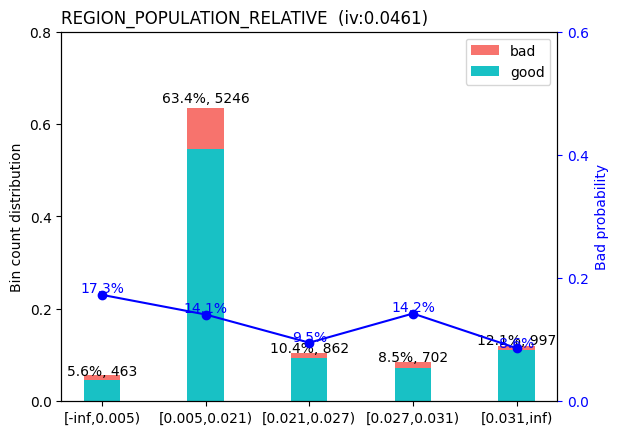

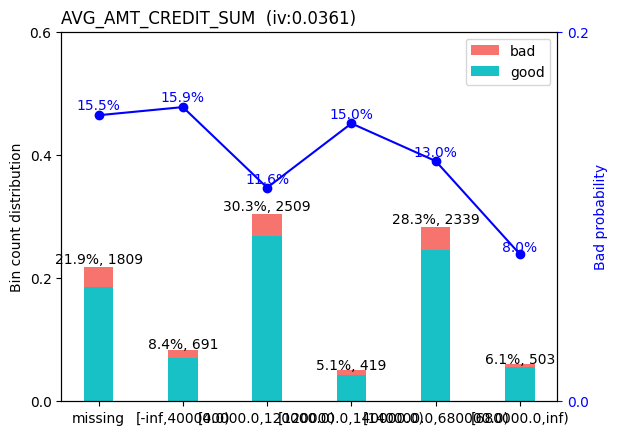

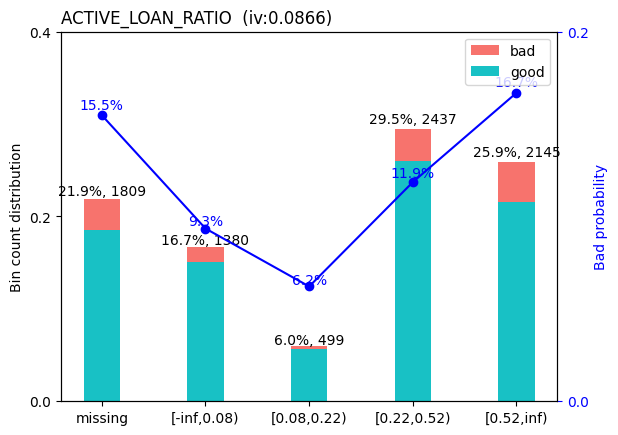

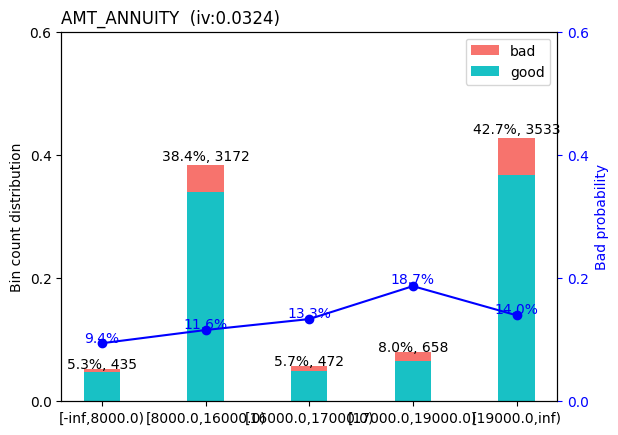

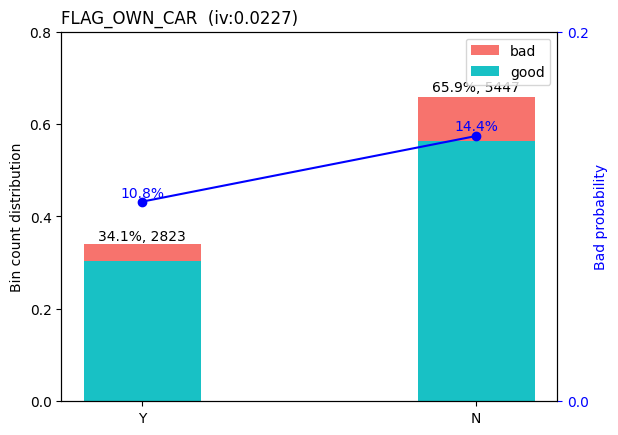

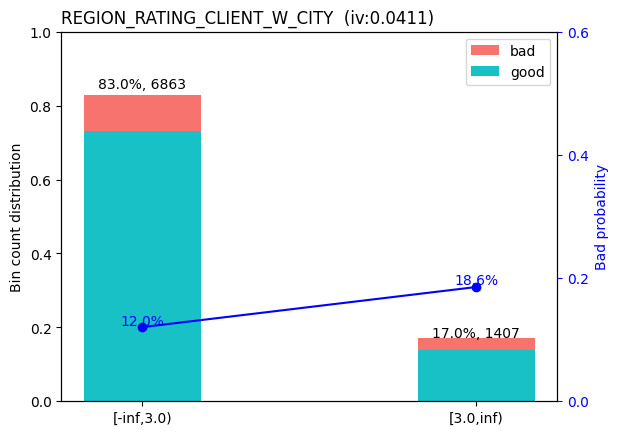

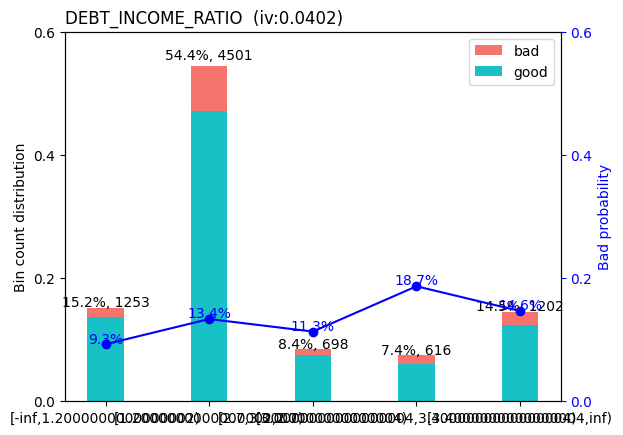

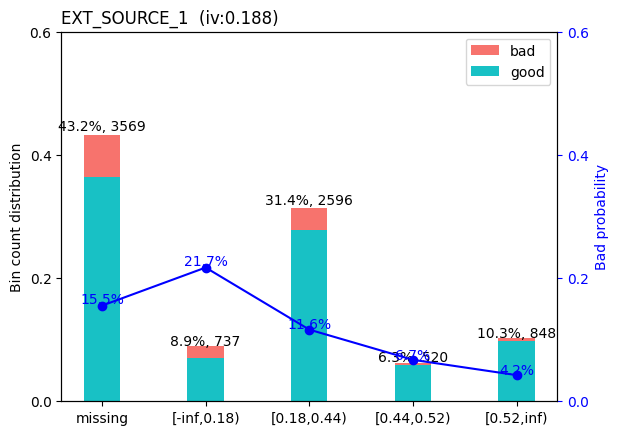

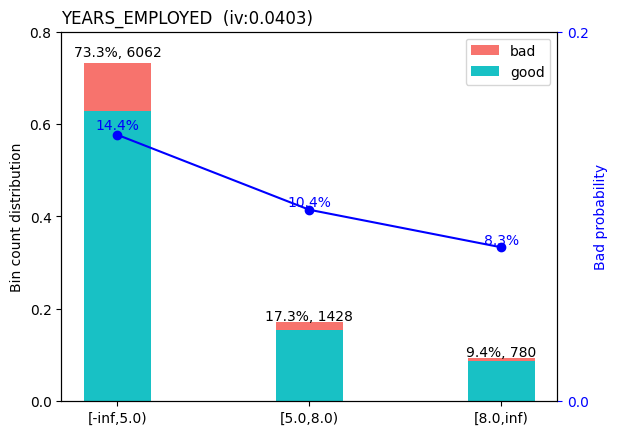

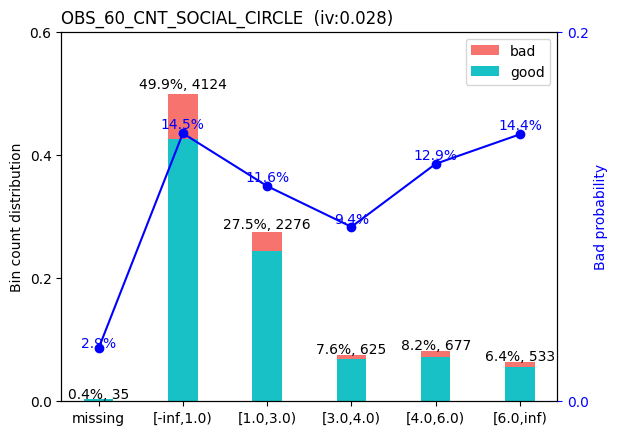

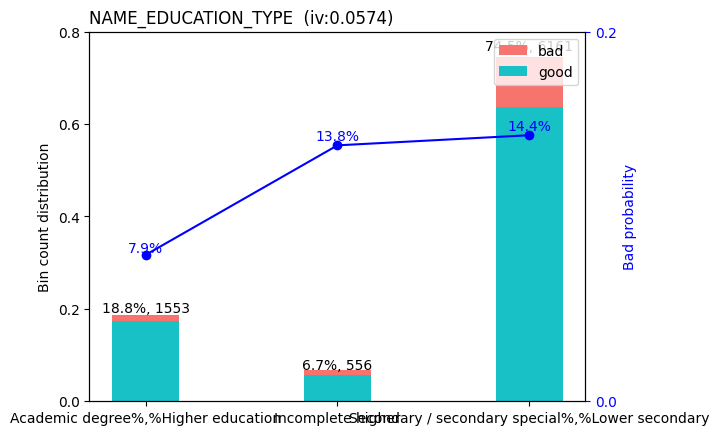

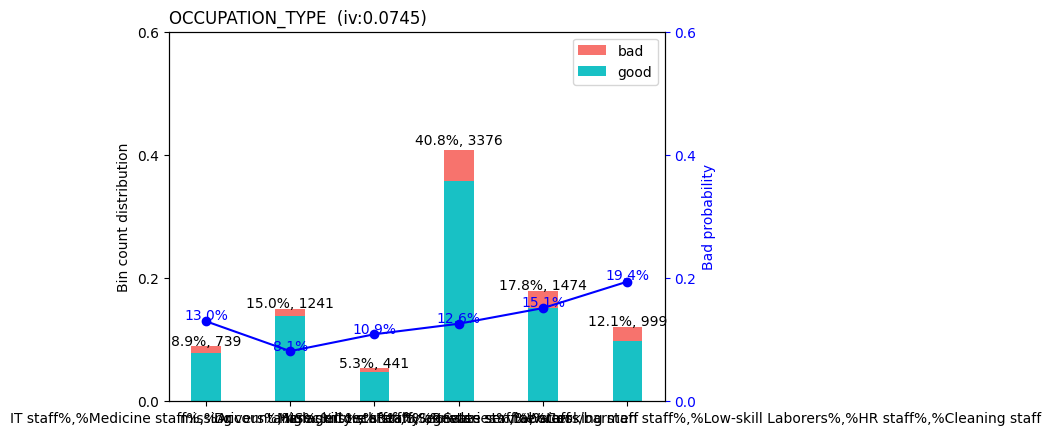

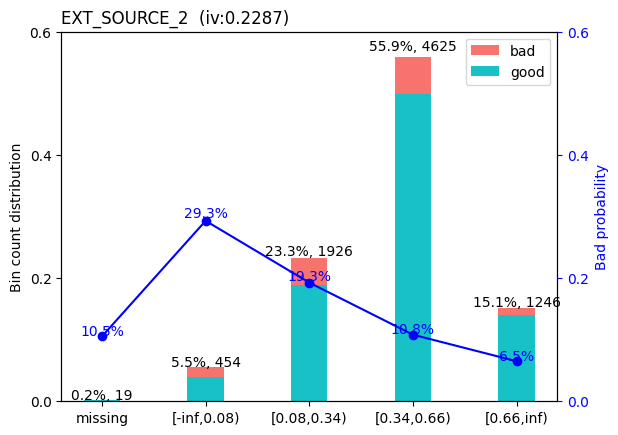

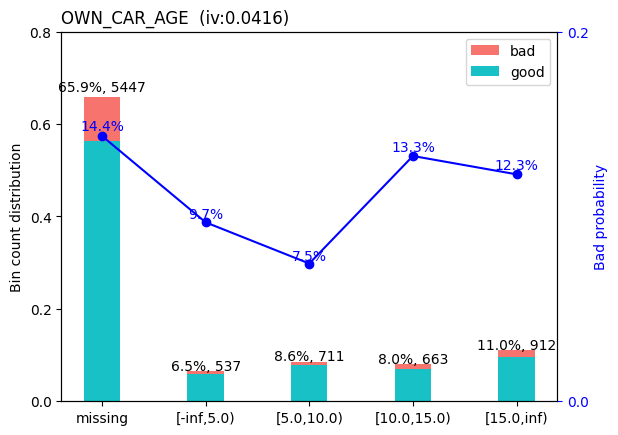

In [637]:
bins_after_dropping_iv = sc.woebin(clean_merged_data, y='TARGET')
# make it easy to read the bins
for variables , bindetails in bins_after_dropping_iv.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)
    
sc.woebin_plot(bins_after_dropping_iv)

## 3.2 Coarse Classing

#### Manual adjustment of sc.woebin groupings

[INFO] creating woe binning ...
REGION_POPULATION_RELATIVE  : 


variable            bin  count  count_distr  good  bad  \
0  REGION_POPULATION_RELATIVE   [-inf,0.005)    463         0.06   383   80   
1  REGION_POPULATION_RELATIVE  [0.005,0.021)   5246         0.63  4507  739   
2  REGION_POPULATION_RELATIVE  [0.021,0.027)    862         0.10   780   82   
3  REGION_POPULATION_RELATIVE  [0.027,0.031)    702         0.08   602  100   
4  REGION_POPULATION_RELATIVE    [0.031,inf)    997         0.12   911   86   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.17  0.32    0.01      0.05  0.005              False  
1     0.14  0.08    0.00      0.05  0.021              False  
2     0.10 -0.36    0.01      0.05  0.027              False  
3     0.14  0.09    0.00      0.05  0.031              False  
4     0.09 -0.47    0.02      0.05    inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM  : 


variable                  bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM              missing   1809         0.22  1529  280   
1  AVG_AMT_CREDIT_SUM       [-inf,40000.0)    691         0.08   581  110   
2  AVG_AMT_CREDIT_SUM   [40000.0,120000.0)   2509         0.30  2219  290   
3  AVG_AMT_CREDIT_SUM  [120000.0,140000.0)    419         0.05   356   63   
4  AVG_AMT_CREDIT_SUM  [140000.0,680000.0)   2339         0.28  2035  304   
5  AVG_AMT_CREDIT_SUM       [680000.0,inf)    503         0.06   463   40   

   badprob   woe  bin_iv  total_iv    breaks  is_special_values  
0     0.15  0.19    0.01      0.04   missing               True  
1     0.16  0.22    0.00      0.04   40000.0              False  
2     0.12 -0.15    0.01      0.04  120000.0              False  
3     0.15  0.16    0.00      0.04  140000.0              False  
4     0.13 -0.01    0.00      0.04  680000.0              False  
5     0.08 -0.56    0.02      0.04       inf              False

----------------------------------------------------------------------------------------------------
ACTIVE_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  ACTIVE_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  ACTIVE_LOAN_RATIO  [-inf,0.08)   1380         0.17  1251  129     0.09   
2  ACTIVE_LOAN_RATIO  [0.08,0.22)    499         0.06   468   31     0.06   
3  ACTIVE_LOAN_RATIO  [0.22,0.52)   2437         0.29  2148  289     0.12   
4  ACTIVE_LOAN_RATIO   [0.52,inf)   2145         0.26  1787  358     0.17   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.09  missing               True  
1 -0.38    0.02      0.09     0.08              False  
2 -0.83    0.03      0.09     0.22              False  
3 -0.12    0.00      0.09     0.52              False  
4  0.28    0.02      0.09      inf              False

----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


variable                bin  count  count_distr  good  bad  badprob  \
0  AMT_ANNUITY      [-inf,8000.0)    435         0.05   394   41     0.09   
1  AMT_ANNUITY   [8000.0,16000.0)   3172         0.38  2805  367     0.12   
2  AMT_ANNUITY  [16000.0,17000.0)    472         0.06   409   63     0.13   
3  AMT_ANNUITY  [17000.0,19000.0)    658         0.08   535  123     0.19   
4  AMT_ANNUITY      [19000.0,inf)   3533         0.43  3040  493     0.14   

    woe  bin_iv  total_iv   breaks  is_special_values  
0 -0.37    0.01      0.03   8000.0              False  
1 -0.15    0.01      0.03  16000.0              False  
2  0.02    0.00      0.03  17000.0              False  
3  0.42    0.02      0.03  19000.0              False  
4  0.07    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_CAR   Y   2823         0.34  2518  305     0.11 -0.22    0.02   
1  FLAG_OWN_CAR   N   5447         0.66  4665  782     0.14  0.10    0.01   

   total_iv breaks  is_special_values  
0      0.02      Y              False  
1      0.02      N              False

----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


variable         bin  count  count_distr  good  bad  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,3.0)   6863         0.83  6037  826   
1  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   1407         0.17  1146  261   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.12 -0.10    0.01      0.04    3.0              False  
1     0.19  0.41    0.03      0.04    inf              False

----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


variable                                      bin  count  \
0  DEBT_INCOME_RATIO                [-inf,1.2000000000000002)   1253   
1  DEBT_INCOME_RATIO                 [1.2000000000000002,2.7)   4501   
2  DEBT_INCOME_RATIO                 [2.7,3.0000000000000004)    698   
3  DEBT_INCOME_RATIO  [3.0000000000000004,3.4000000000000004)    616   
4  DEBT_INCOME_RATIO                 [3.4000000000000004,inf)   1202   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.15  1137  116     0.09 -0.39    0.02      0.04   
1         0.54  3900  601     0.13  0.02    0.00      0.04   
2         0.08   619   79     0.11 -0.17    0.00      0.04   
3         0.07   501  115     0.19  0.42    0.02      0.04   
4         0.15  1026  176     0.15  0.13    0.00      0.04   

               breaks  is_special_values  
0  1.2000000000000002              False  
1                 2.7              False  
2  3.0000000000000004              False  
3  3.4000000000000004              False  
4                 inf              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_1      missing   3569         0.43  3015  554     0.16  0.19   
1  EXT_SOURCE_1  [-inf,0.18)    737         0.09   577  160     0.22  0.61   
2  EXT_SOURCE_1  [0.18,0.44)   2596         0.31  2294  302     0.12 -0.14   
3  EXT_SOURCE_1  [0.44,0.52)    520         0.06   485   35     0.07 -0.74   
4  EXT_SOURCE_1   [0.52,inf)    848         0.10   812   36     0.04 -1.23   

   bin_iv  total_iv   breaks  is_special_values  
0    0.02      0.19  missing               True  
1    0.04      0.19     0.18              False  
2    0.01      0.19     0.44              False  
3    0.03      0.19     0.52              False  
4    0.10      0.19      inf              False

----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  YEARS_EMPLOYED  [-inf,5.0)   6062         0.73  5188  874     0.14  0.11   
1  YEARS_EMPLOYED   [5.0,8.0)   1428         0.17  1280  148     0.10 -0.27   
2  YEARS_EMPLOYED   [8.0,inf)    780         0.09   715   65     0.08 -0.51   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.04    5.0              False  
1    0.01      0.04    8.0              False  
2    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  : 


variable         bin  count  count_distr  good  bad  \
0  OBS_60_CNT_SOCIAL_CIRCLE     missing     35         0.00    34    1   
1  OBS_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)   4124         0.50  3526  598   
2  OBS_60_CNT_SOCIAL_CIRCLE   [1.0,3.0)   2276         0.28  2011  265   
3  OBS_60_CNT_SOCIAL_CIRCLE   [3.0,4.0)    625         0.08   566   59   
4  OBS_60_CNT_SOCIAL_CIRCLE   [4.0,6.0)    677         0.08   590   87   
5  OBS_60_CNT_SOCIAL_CIRCLE   [6.0,inf)    533         0.06   456   77   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.03 -1.64    0.01      0.03  missing               True  
1     0.15  0.11    0.01      0.03      1.0              False  
2     0.12 -0.14    0.01      0.03      3.0              False  
3     0.09 -0.37    0.01      0.03      4.0              False  
4     0.13 -0.03    0.00      0.03      6.0              False  
5     0.14  0.11    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


variable                                              bin  \
0  NAME_EDUCATION_TYPE               Academic degree%,%Higher education   
1  NAME_EDUCATION_TYPE                                Incomplete higher   
2  NAME_EDUCATION_TYPE  Secondary / secondary special%,%Lower secondary   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   1553         0.19  1430  123     0.08 -0.56    0.05      0.06   
1    556         0.07   479   77     0.14  0.06    0.00      0.06   
2   6161         0.74  5274  887     0.14  0.11    0.01      0.06   

                                            breaks  is_special_values  
0               Academic degree%,%Higher education              False  
1                                Incomplete higher              False  
2  Secondary / secondary special%,%Lower secondary              False

----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing    739   
1  OCCUPATION_TYPE  IT staff%,%Medicine staff%,%Accountants%,%Core...   1241   
2  OCCUPATION_TYPE                           Managers%,%Realty agents    441   
3  OCCUPATION_TYPE  High skill tech staff%,%Sales staff%,%Cooking ...   3376   
4  OCCUPATION_TYPE                                           Laborers   1474   
5  OCCUPATION_TYPE  Drivers%,%Security staff%,%Secretaries%,%Waite...    999   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.09   643   96     0.13 -0.01    0.00      0.07   
1         0.15  1140  101     0.08 -0.54    0.04      0.07   
2         0.05   393   48     0.11 -0.21    0.00      0.07   
3         0.41  2951  425     0.13 -0.05    0.00      0.07   
4         0.18  1251  223     0.15  0.16    0.01      0.07   
5         0.12   805  194     0.19  0.47    0.03      0.07   

                                              breaks  is_special_values  
0                                            missing               True  
1  IT staff%,%Medicine staff%,%Accountants%,%Core...              False  
2                           Managers%,%Realty agents              False  
3  High skill tech staff%,%Sales staff%,%Cooking ...              False  
4                                           Laborers              False  
5  Drivers%,%Security staff%,%Secretaries%,%Waite...              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_2      missing     19         0.00    17    2     0.11 -0.25   
1  EXT_SOURCE_2  [-inf,0.08)    454         0.05   321  133     0.29  1.01   
2  EXT_SOURCE_2  [0.08,0.34)   1926         0.23  1555  371     0.19  0.46   
3  EXT_SOURCE_2  [0.34,0.66)   4625         0.56  4125  500     0.11 -0.22   
4  EXT_SOURCE_2   [0.66,inf)   1246         0.15  1165   81     0.07 -0.78   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.23  missing               True  
1    0.08      0.23     0.08              False  
2    0.06      0.23     0.34              False  
3    0.03      0.23     0.66              False  
4    0.07      0.23      inf              False

----------------------------------------------------------------------------------------------------
OWN_CAR_AGE  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  OWN_CAR_AGE      missing   5447         0.66  4665  782     0.14  0.10   
1  OWN_CAR_AGE   [-inf,5.0)    537         0.06   485   52     0.10 -0.34   
2  OWN_CAR_AGE   [5.0,10.0)    711         0.09   658   53     0.07 -0.63   
3  OWN_CAR_AGE  [10.0,15.0)    663         0.08   575   88     0.13  0.01   
4  OWN_CAR_AGE   [15.0,inf)    912         0.11   800  112     0.12 -0.08   

   bin_iv  total_iv   breaks  is_special_values  
0    0.01      0.04  missing               True  
1    0.01      0.04      5.0              False  
2    0.03      0.04     10.0              False  
3    0.00      0.04     15.0              False  
4    0.00      0.04      inf              False

----------------------------------------------------------------------------------------------------


{'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM': <Figure size 640x480 with 2 Axes>,
 'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'OBS_60_CNT_SOCIAL_CIRCLE': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'OWN_CAR_AGE': <Figure size 640x480 with 2 Axes>}

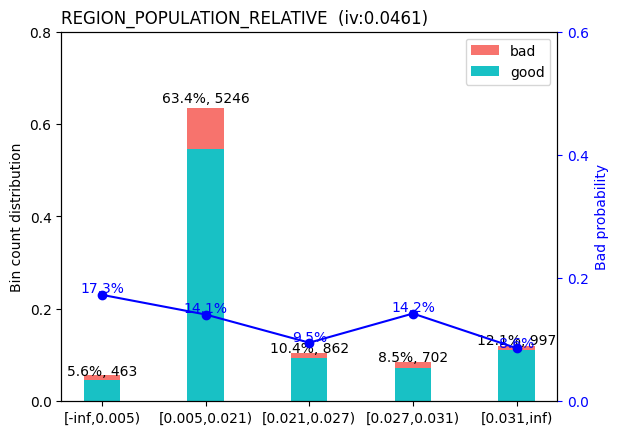

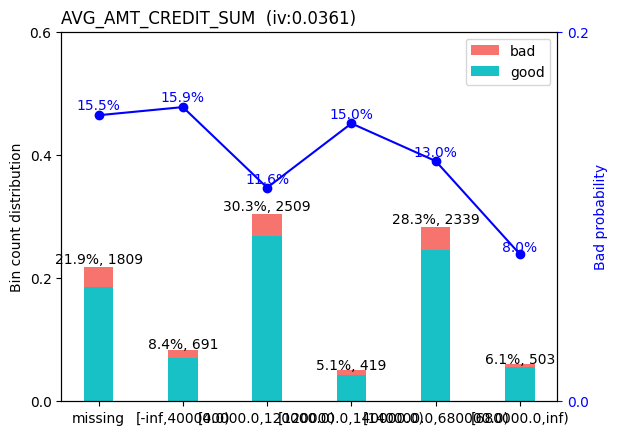

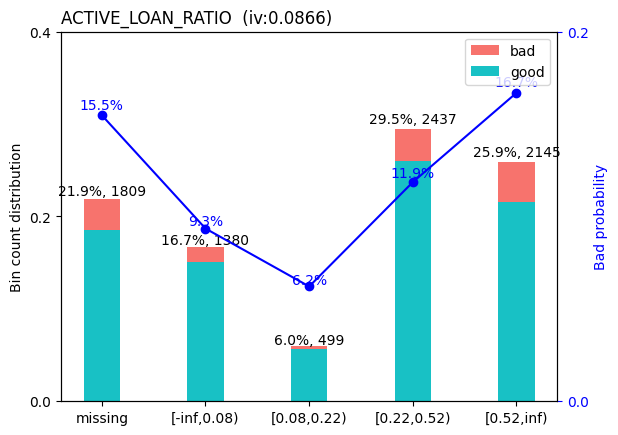

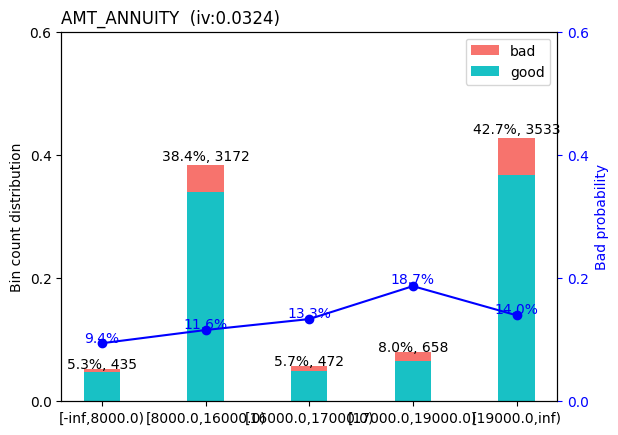

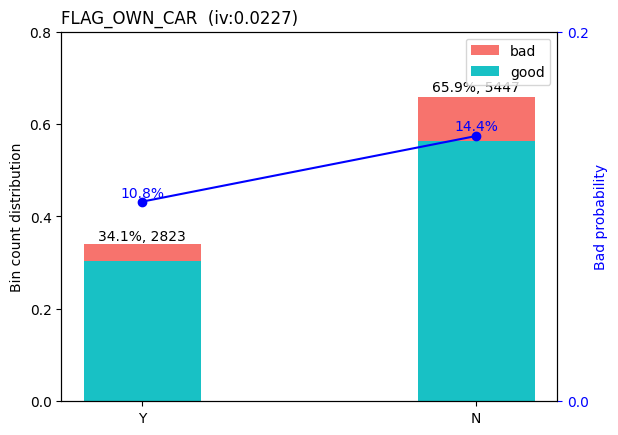

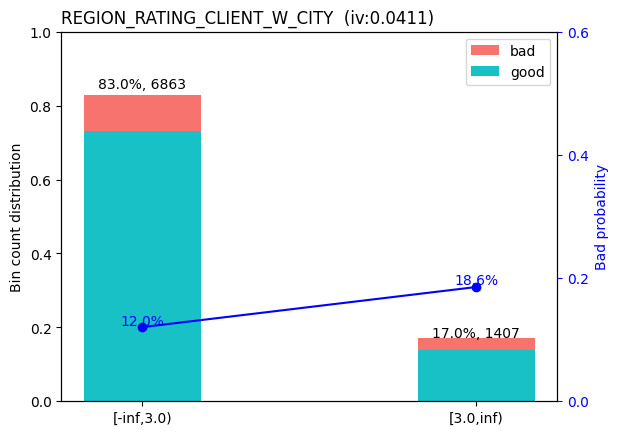

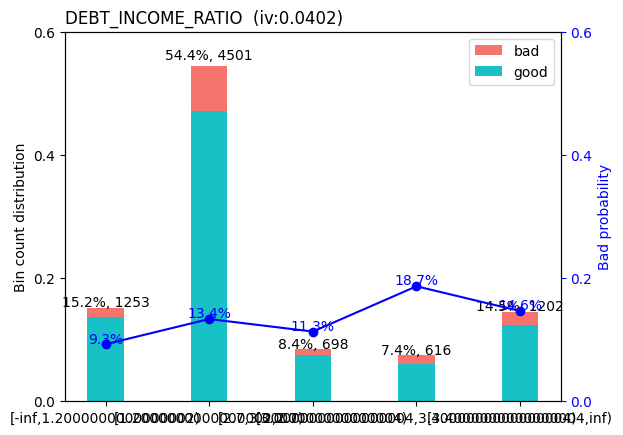

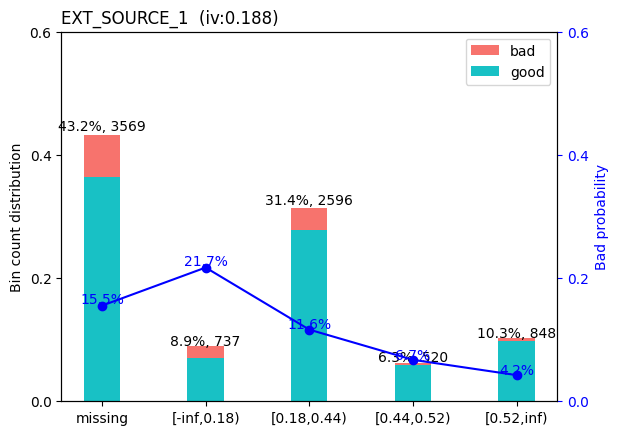

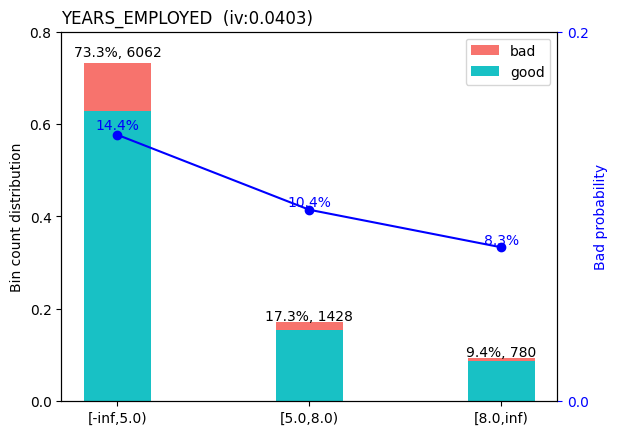

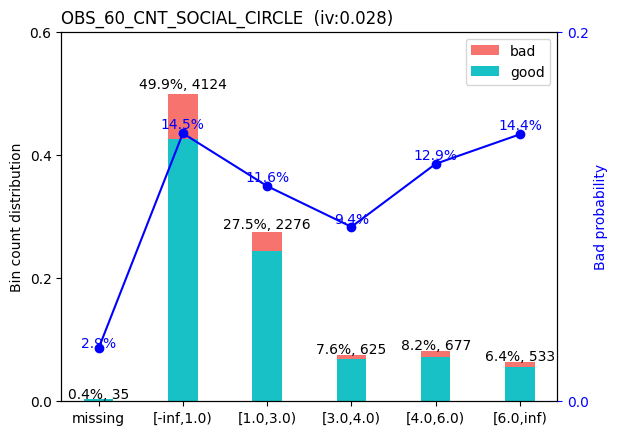

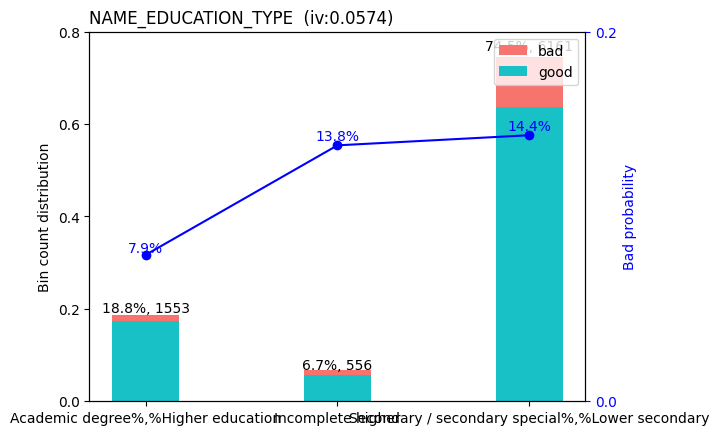

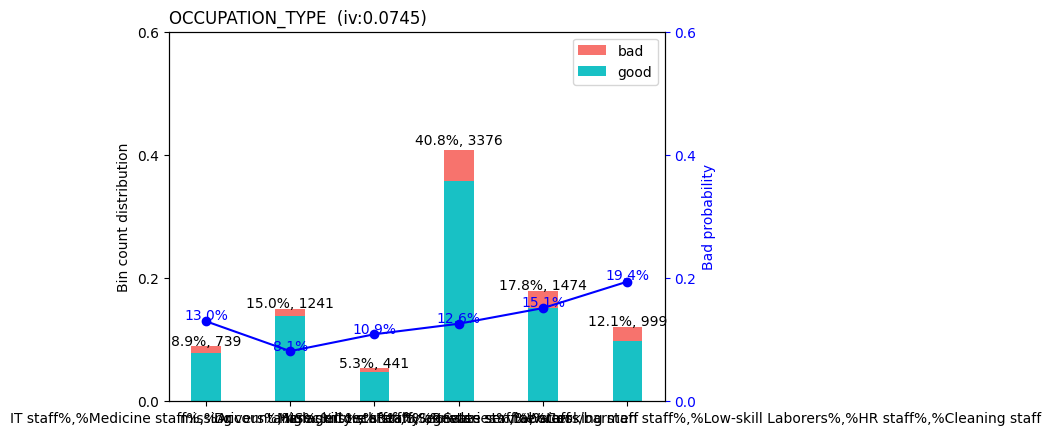

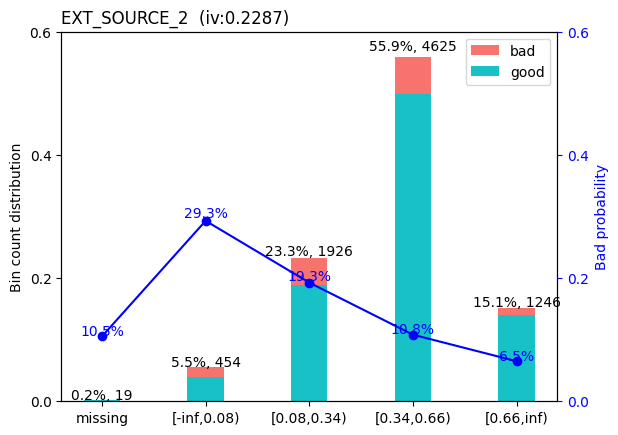

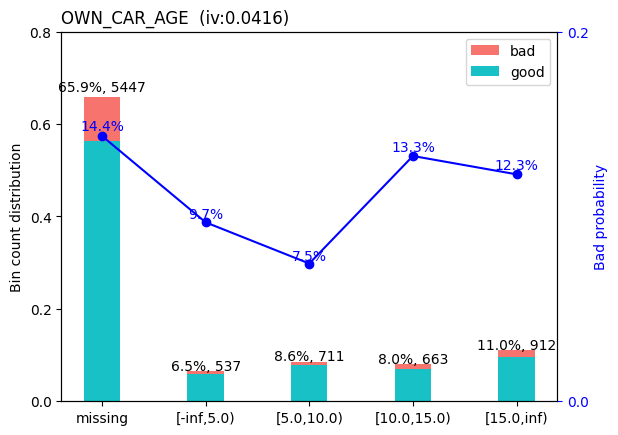

In [638]:
bins_after_dropping_iv = sc.woebin(clean_merged_data, y='TARGET')
# make it easy to read the bins
for variables , bindetails in bins_after_dropping_iv.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)
    
sc.woebin_plot(bins_after_dropping_iv)

## 3.2 Coarse Classing

#### Manual adjustment of sc.woebin groupings

[INFO] creating woe binning ...
REGION_POPULATION_RELATIVE  : 


variable            bin  count  count_distr  good  bad  \
0  REGION_POPULATION_RELATIVE   [-inf,0.005)    463         0.06   383   80   
1  REGION_POPULATION_RELATIVE  [0.005,0.021)   5246         0.63  4507  739   
2  REGION_POPULATION_RELATIVE  [0.021,0.031)   1564         0.19  1382  182   
3  REGION_POPULATION_RELATIVE    [0.031,inf)    997         0.12   911   86   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.17  0.32    0.01      0.04  0.005              False  
1     0.14  0.08    0.00      0.04  0.021              False  
2     0.12 -0.14    0.00      0.04  0.031              False  
3     0.09 -0.47    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM  : 


variable                 bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM             missing   1809         0.22  1529  280   
1  AVG_AMT_CREDIT_SUM      [-inf,40000.0)    691         0.08   581  110   
2  AVG_AMT_CREDIT_SUM  [40000.0,680000.0)   5267         0.64  4610  657   
3  AVG_AMT_CREDIT_SUM      [680000.0,inf)    503         0.06   463   40   

   badprob   woe  bin_iv  total_iv    breaks  is_special_values  
0     0.15  0.19    0.01      0.03   missing               True  
1     0.16  0.22    0.00      0.03   40000.0              False  
2     0.12 -0.06    0.00      0.03  680000.0              False  
3     0.08 -0.56    0.02      0.03       inf              False

----------------------------------------------------------------------------------------------------
ACTIVE_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  ACTIVE_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  ACTIVE_LOAN_RATIO  [-inf,0.22)   1879         0.23  1719  160     0.09   
2  ACTIVE_LOAN_RATIO  [0.22,0.52)   2437         0.29  2148  289     0.12   
3  ACTIVE_LOAN_RATIO   [0.52,inf)   2145         0.26  1787  358     0.17   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.08  missing               True  
1 -0.49    0.04      0.08     0.22              False  
2 -0.12    0.00      0.08     0.52              False  
3  0.28    0.02      0.08      inf              False

----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


variable                bin  count  count_distr  good  bad  badprob  \
0  AMT_ANNUITY      [-inf,8000.0)    435         0.05   394   41     0.09   
1  AMT_ANNUITY   [8000.0,17000.0)   3644         0.44  3214  430     0.12   
2  AMT_ANNUITY  [17000.0,19000.0)    658         0.08   535  123     0.19   
3  AMT_ANNUITY      [19000.0,inf)   3533         0.43  3040  493     0.14   

    woe  bin_iv  total_iv   breaks  is_special_values  
0 -0.37    0.01      0.03   8000.0              False  
1 -0.12    0.01      0.03  17000.0              False  
2  0.42    0.02      0.03  19000.0              False  
3  0.07    0.00      0.03      inf              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_CAR   Y   2823         0.34  2518  305     0.11 -0.22    0.02   
1  FLAG_OWN_CAR   N   5447         0.66  4665  782     0.14  0.10    0.01   

   total_iv breaks  is_special_values  
0      0.02      Y              False  
1      0.02      N              False

----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


variable         bin  count  count_distr  good  bad  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,3.0)   6863         0.83  6037  826   
1  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   1407         0.17  1146  261   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.12 -0.10    0.01      0.04    3.0              False  
1     0.19  0.41    0.03      0.04    inf              False

----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


variable         bin  count  count_distr  good  bad  badprob  \
0  DEBT_INCOME_RATIO  [-inf,1.2)   1184         0.14  1073  111     0.09   
1  DEBT_INCOME_RATIO   [1.2,2.1)   2914         0.35  2550  364     0.12   
2  DEBT_INCOME_RATIO  [2.1,3.01)   2354         0.28  2033  321     0.14   
3  DEBT_INCOME_RATIO  [3.01,inf)   1818         0.22  1527  291     0.16   

    woe  bin_iv  total_iv breaks  is_special_values  
0 -0.38    0.02      0.03    1.2              False  
1 -0.06    0.00      0.03    2.1              False  
2  0.04    0.00      0.03   3.01              False  
3  0.23    0.01      0.03    inf              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_1      missing   3569         0.43  3015  554     0.16  0.19   
1  EXT_SOURCE_1  [-inf,0.18)    737         0.09   577  160     0.22  0.61   
2  EXT_SOURCE_1  [0.18,0.44)   2596         0.31  2294  302     0.12 -0.14   
3  EXT_SOURCE_1   [0.44,inf)   1368         0.17  1297   71     0.05 -1.02   

   bin_iv  total_iv   breaks  is_special_values  
0    0.02      0.18  missing               True  
1    0.04      0.18     0.18              False  
2    0.01      0.18     0.44              False  
3    0.12      0.18      inf              False

----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  YEARS_EMPLOYED  [-inf,5.0)   6062         0.73  5188  874     0.14  0.11   
1  YEARS_EMPLOYED   [5.0,8.0)   1428         0.17  1280  148     0.10 -0.27   
2  YEARS_EMPLOYED   [8.0,inf)    780         0.09   715   65     0.08 -0.51   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.04    5.0              False  
1    0.01      0.04    8.0              False  
2    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  : 


variable         bin  count  count_distr  good  bad  \
0  OBS_60_CNT_SOCIAL_CIRCLE     missing     35         0.00    34    1   
1  OBS_60_CNT_SOCIAL_CIRCLE  [-inf,1.0)   4124         0.50  3526  598   
2  OBS_60_CNT_SOCIAL_CIRCLE   [1.0,2.0)   1391         0.17  1224  167   
3  OBS_60_CNT_SOCIAL_CIRCLE   [2.0,inf)   2720         0.33  2399  321   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.03 -1.64    0.01      0.02  missing               True  
1     0.15  0.11    0.01      0.02      1.0              False  
2     0.12 -0.10    0.00      0.02      2.0              False  
3     0.12 -0.12    0.00      0.02      inf              False

----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


variable                                              bin  \
0  NAME_EDUCATION_TYPE               Academic degree%,%Higher education   
1  NAME_EDUCATION_TYPE                                Incomplete higher   
2  NAME_EDUCATION_TYPE  Secondary / secondary special%,%Lower secondary   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   1553         0.19  1430  123     0.08 -0.56    0.05      0.06   
1    556         0.07   479   77     0.14  0.06    0.00      0.06   
2   6161         0.74  5274  887     0.14  0.11    0.01      0.06   

                                            breaks  is_special_values  
0               Academic degree%,%Higher education              False  
1                                Incomplete higher              False  
2  Secondary / secondary special%,%Lower secondary              False

----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing    739   
1  OCCUPATION_TYPE  IT staff%,%Medicine staff%,%Accountants%,%Core...   1241   
2  OCCUPATION_TYPE                           Managers%,%Realty agents    441   
3  OCCUPATION_TYPE  High skill tech staff%,%Sales staff%,%Cooking ...   3376   
4  OCCUPATION_TYPE                                           Laborers   1474   
5  OCCUPATION_TYPE  Drivers%,%Security staff%,%Secretaries%,%Waite...    999   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.09   643   96     0.13 -0.01    0.00      0.07   
1         0.15  1140  101     0.08 -0.54    0.04      0.07   
2         0.05   393   48     0.11 -0.21    0.00      0.07   
3         0.41  2951  425     0.13 -0.05    0.00      0.07   
4         0.18  1251  223     0.15  0.16    0.01      0.07   
5         0.12   805  194     0.19  0.47    0.03      0.07   

                                              breaks  is_special_values  
0                                            missing               True  
1  IT staff%,%Medicine staff%,%Accountants%,%Core...              False  
2                           Managers%,%Realty agents              False  
3  High skill tech staff%,%Sales staff%,%Cooking ...              False  
4                                           Laborers              False  
5  Drivers%,%Security staff%,%Secretaries%,%Waite...              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_2      missing     19         0.00    17    2     0.11 -0.25   
1  EXT_SOURCE_2  [-inf,0.08)    454         0.05   321  133     0.29  1.01   
2  EXT_SOURCE_2  [0.08,0.34)   1926         0.23  1555  371     0.19  0.46   
3  EXT_SOURCE_2  [0.34,0.66)   4625         0.56  4125  500     0.11 -0.22   
4  EXT_SOURCE_2   [0.66,inf)   1246         0.15  1165   81     0.07 -0.78   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.23  missing               True  
1    0.08      0.23     0.08              False  
2    0.06      0.23     0.34              False  
3    0.03      0.23     0.66              False  
4    0.07      0.23      inf              False

----------------------------------------------------------------------------------------------------
OWN_CAR_AGE  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  OWN_CAR_AGE     missing   5447         0.66  4665  782     0.14  0.10   
1  OWN_CAR_AGE  [-inf,8.0)    928         0.11   850   78     0.08 -0.50   
2  OWN_CAR_AGE  [8.0,12.0)    581         0.07   524   57     0.10 -0.33   
3  OWN_CAR_AGE  [12.0,inf)   1314         0.16  1144  170     0.13 -0.02   

   bin_iv  total_iv   breaks  is_special_values  
0    0.01      0.04  missing               True  
1    0.02      0.04      8.0              False  
2    0.01      0.04     12.0              False  
3    0.00      0.04      inf              False

----------------------------------------------------------------------------------------------------


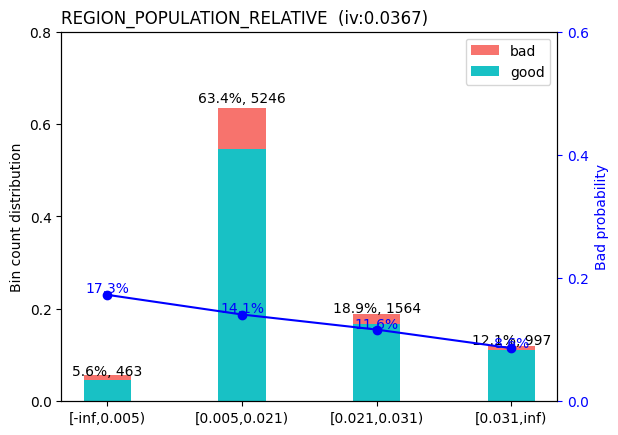

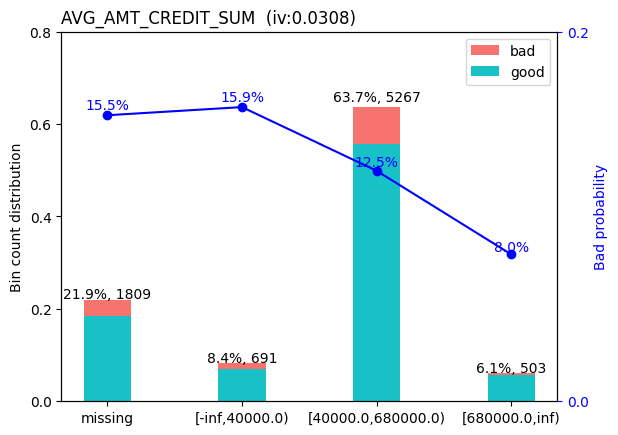

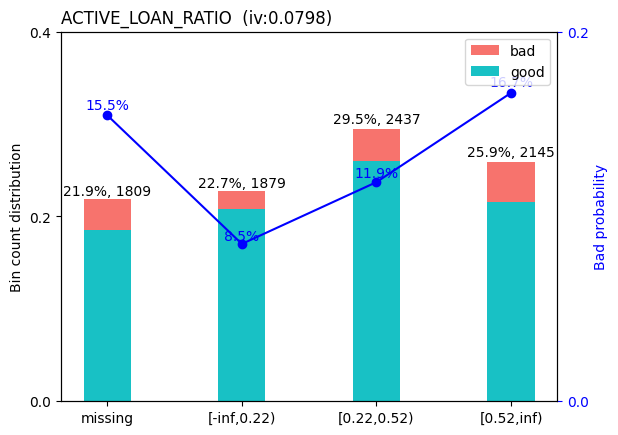

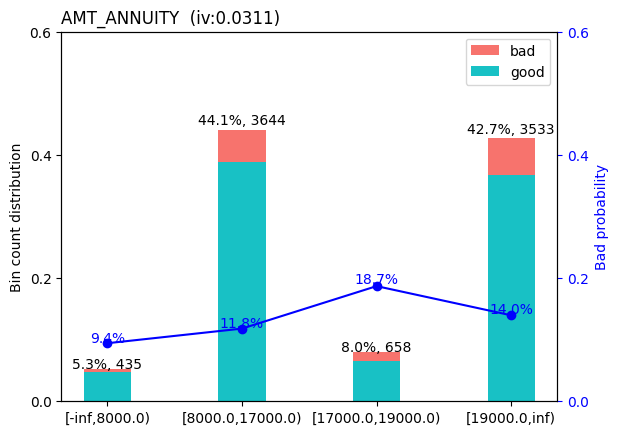

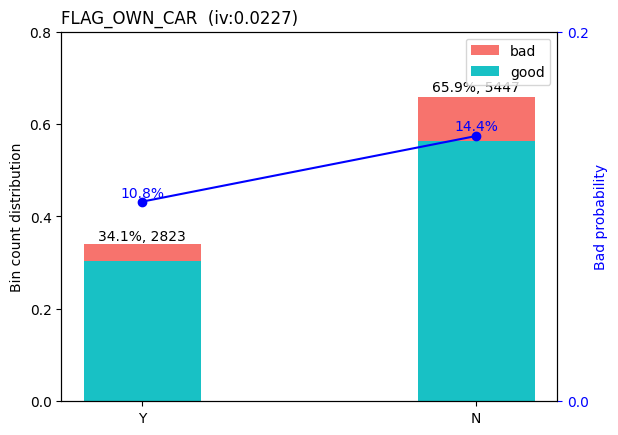

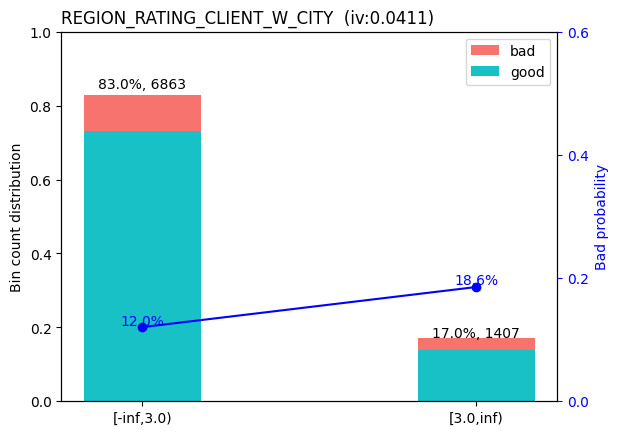

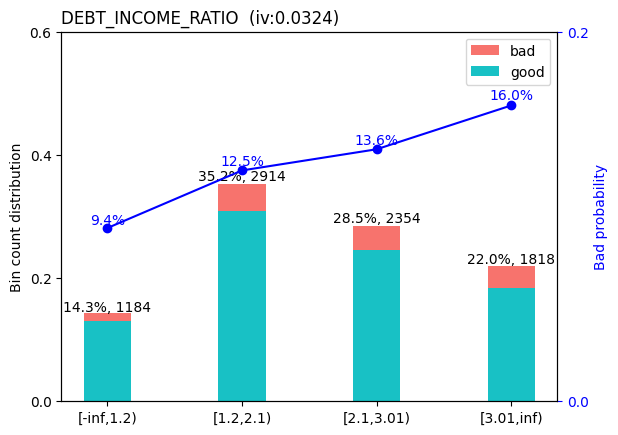

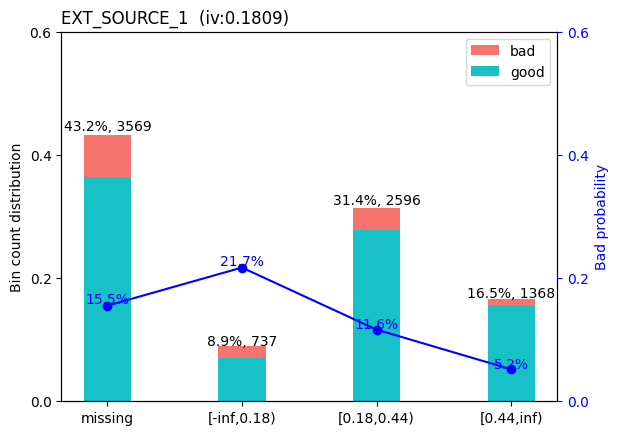

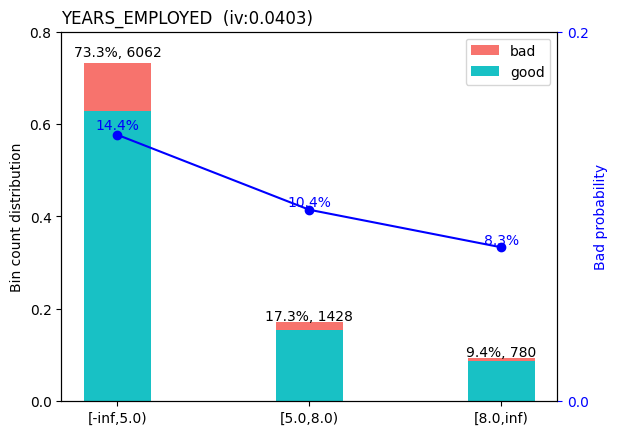

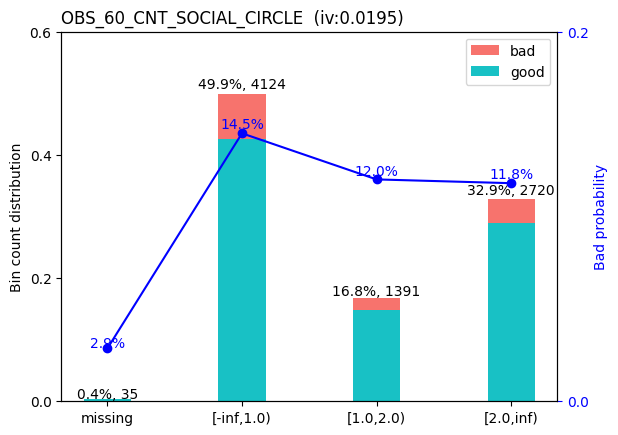

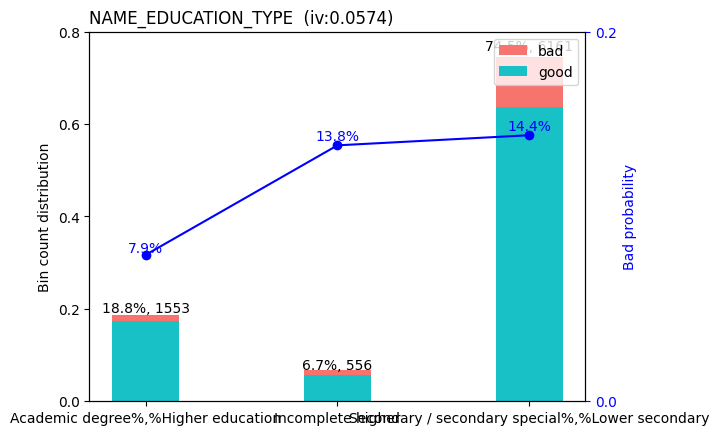

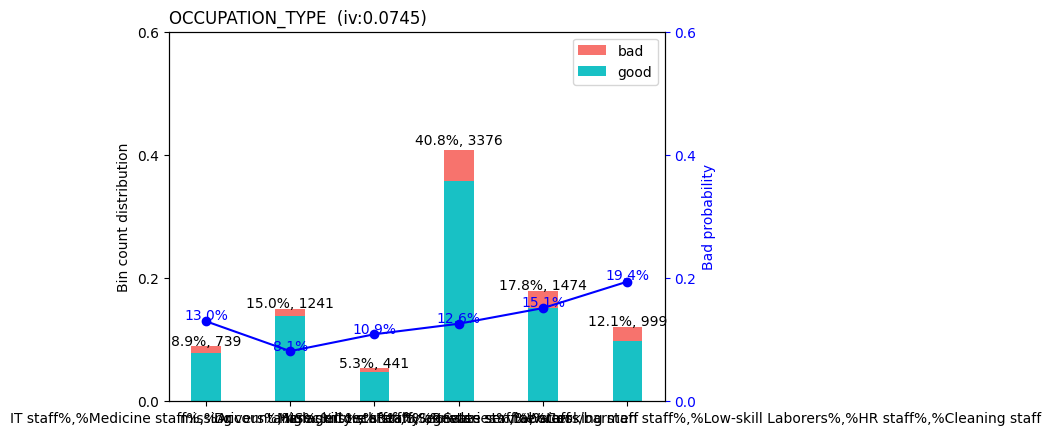

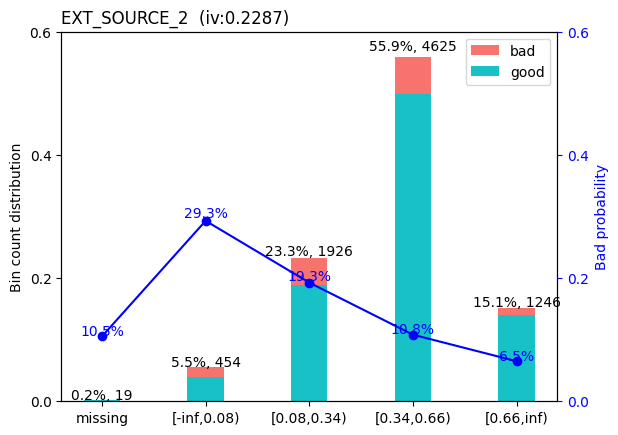

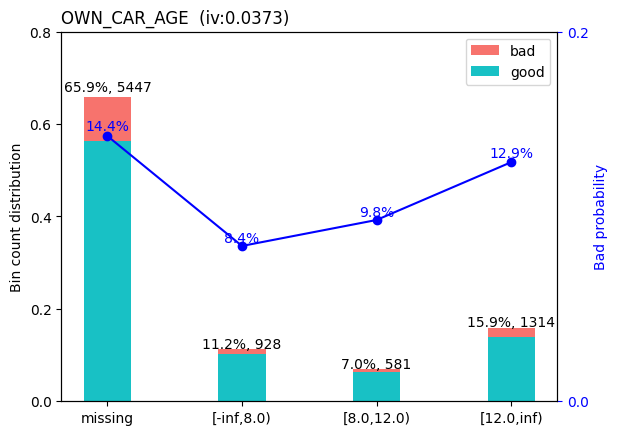

In [639]:
# bin adjustments 

breaks_adj = {
            'AVG_AMT_CREDIT_SUM' : [40000, 680000],
            'OBS_60_CNT_SOCIAL_CIRCLE':[1,2],
            'OWN_CAR_AGE':[8, 12],
            'DEBT_INCOME_RATIO' : [1.2, 2.1, 3.01],
            'AMT_ANNUITY' : [8000, 17000, 19000],
            'REGION_POPULATION_RELATIVE': [0.005, 0.021, 0.031],
            'ACTIVE_LOAN_RATIO' :[0.22,0.52],
            'EXT_SOURCE_1': [0.18, 0.44] # Reducing bins
            }

bins2 = sc.woebin(clean_merged_data, y='TARGET',breaks_list=breaks_adj)
sc.woebin_plot(bins2)

for variables , bindetails in bins2.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

### Compare IVs of bins pre and post-coarse classing
Ensure coarse classing has not affected IV range.

| Variable                   |  Previous IV |   New IV     |
|---------------------------|-----------|-----------------|      
| FLAG_OWN_CAR              | 0.0227    |   0.0227 |
| OBS_60_CNT_SOCIAL_CIRCLE   | 0.028    |   0.0195 |
| AVG_AMT_CREDIT_SUM        | 0.0361    |   0.0308 |
| AMT_ANNUITY               | 0.0324    |   0.0311 |
| DEBT_INCOME_RATIO         | 0.0402    |   0.0324 |
| REGION_POPULATION_RELATIVE | 0.0461   |   0.0367 |
| OWN_CAR_AGE               | 0.0416    |   0.0373 |
| YEARS_EMPLOYED            | 0.0403    |   0.0403 |
| REGION_RATING_CLIENT_W_CITY | 0.0411  |   0.0411 |
| NAME_EDUCATION_TYPE       | 0.0574    |  0.0574 |
| OCCUPATION_TYPE           | 0.0745    |  0.0745 |
| ACTIVE_LOAN_RATIO         | 0.0866    |   0.0798 |
| EXT_SOURCE_1              | 0.188     |   0.1809  |
| EXT_SOURCE_2              | 0.2287    |   0.2287 |


#### Drop variables where valid monotonicity cannot be achieved in the same IV range.
Valid monotonicty = when a variable does not make sense if it's not monotonic

In [640]:
clean_merged_data.drop("OBS_60_CNT_SOCIAL_CIRCLE", axis=1, inplace=True)
clean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8270 entries, 22 to 307457
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       8270 non-null   int64  
 1   FLAG_OWN_CAR                 8270 non-null   object 
 2   AMT_ANNUITY                  8270 non-null   float64
 3   NAME_EDUCATION_TYPE          8270 non-null   object 
 4   REGION_POPULATION_RELATIVE   8270 non-null   float64
 5   OWN_CAR_AGE                  2823 non-null   float64
 6   OCCUPATION_TYPE              7531 non-null   object 
 7   REGION_RATING_CLIENT_W_CITY  8270 non-null   int64  
 8   EXT_SOURCE_1                 4701 non-null   float64
 9   EXT_SOURCE_2                 8251 non-null   float64
 10  YEARS_EMPLOYED               8270 non-null   int32  
 11  AVG_AMT_CREDIT_SUM           6461 non-null   float64
 12  DEBT_INCOME_RATIO            8270 non-null   float64
 13  ACTIVE_LOAN_RATIO   

## 4. Create Scorecard

## 4.1 Logistic Regression with WOE encoding


In [641]:
train, test = sc.split_df(clean_merged_data, 'TARGET', ratio=0.7).values()
print(train.shape)
print(test.shape)

(5789, 14)
(2481, 14)


In [642]:
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train,bins2)
test_woe = sc.woebin_ply(test,bins2)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


TARGET  REGION_POPULATION_RELATIVE_woe  AVG_AMT_CREDIT_SUM_woe  \
22           0                            0.08                   -0.56   
35           0                            0.08                   -0.06   
53           0                            0.08                    0.22   
77           0                           -0.14                   -0.06   
168          0                            0.32                    0.19   
...        ...                             ...                     ...   
307353       0                           -0.47                    0.19   
307383       1                            0.08                   -0.06   
307385       0                            0.08                   -0.56   
307436       0                            0.08                   -0.06   
307457       0                           -0.47                   -0.06   

        ACTIVE_LOAN_RATIO_woe  AMT_ANNUITY_woe  FLAG_OWN_CAR_woe  \
22                       0.28             0.07              0.10   
35                      -0.49             0.07              0.10   
53                      -0.49            -0.12              0.10   
77                      -0.49            -0.12              0.10   
168                      0.19             0.07              0.10   
...                       ...              ...               ...   
307353                   0.19             0.07              0.10   
307383                  -0.12             0.07              0.10   
307385                   0.28            -0.12             -0.22   
307436                  -0.49             0.42              0.10   
307457                  -0.49             0.42              0.10   

        REGION_RATING_CLIENT_W_CITY_woe  DEBT_INCOME_RATIO_woe  \
22                                -0.10                  -0.38   
35                                -0.10                   0.23   
53                                -0.10                  -0.06   
77                                -0.10                   0.04   
168                               -0.10                   0.23   
...                                 ...                    ...   
307353                            -0.10                   0.23   
307383                             0.41                   0.23   
307385                            -0.10                  -0.38   
307436                            -0.10                  -0.06   
307457                            -0.10                  -0.06   

        EXT_SOURCE_1_woe  YEARS_EMPLOYED_woe  NAME_EDUCATION_TYPE_woe  \
22                  0.19               -0.51                     0.11   
35                  0.19                0.11                    -0.56   
53                 -0.14                0.11                    -0.56   
77                  0.19               -0.27                     0.11   
168                -1.02                0.11                     0.11   
...                  ...                 ...                      ...   
307353              0.19                0.11                     0.11   
307383              0.19               -0.27                     0.11   
307385             -0.14               -0.51                     0.11   
307436             -0.14                0.11                     0.11   
307457              0.19               -0.51                     0.11   

        OCCUPATION_TYPE_woe  EXT_SOURCE_2_woe  OWN_CAR_AGE_woe  
22                    -0.05             -0.22             0.10  
35                    -0.05             -0.78             0.10  
53                    -0.54             -0.78             0.10  
77                     0.16             -0.22             0.10  
168                   -0.05             -0.22             0.10  
...                     ...               ...              ...  
307353                -0.01              0.46             0.10  
307383                 0.16              0.46             0.10  
307385                -0.05             -0.22  

In [643]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

In [644]:
#create a logistic regression model object
lr = LogisticRegression(random_state=42, class_weight='balanced')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic regression coef:\n ",lr.coef_,"\n")
print("\nLogistic regression intercept: ",lr.intercept_,"\n")
print("\nLogistic regression accuracy: ",accuracy_score(y_test,y_pred),"\n")
print(10*"*","Percentage Correctly Classified",10*"*","\n",classification_report(y_test, y_pred))

Logistic regression coef:
  [[0.37680221 0.31991932 0.88312445 0.84602005 0.69280761 0.33524765
  0.45372161 0.77157033 0.46397384 0.5639789  0.70945461 0.7280281
  0.1960008 ]] 


Logistic regression intercept:  [-0.00821079] 


Logistic regression accuracy:  0.6328093510681176 

********** Percentage Correctly Classified ********** 
               precision    recall  f1-score   support

           0       0.92      0.63      0.75      2155
           1       0.21      0.65      0.32       326

    accuracy                           0.63      2481
   macro avg       0.57      0.64      0.53      2481
weighted avg       0.83      0.63      0.69      2481



## 4.2 Generate scorecard

In [645]:
card = sc.scorecard(
        bins,
        lr, 
        X_train.columns, 
        points0 = 600, 
        odds0 = 1/20, 
        pdo = 20,
        basepoints_eq0 = False
        )

pprint.pprint(card)


{'ACTIVE_LOAN_RATIO':              variable          bin  points
21  ACTIVE_LOAN_RATIO      missing   -5.00
22  ACTIVE_LOAN_RATIO  [-inf,0.08)   10.00
23  ACTIVE_LOAN_RATIO  [0.08,0.22)   21.00
24  ACTIVE_LOAN_RATIO  [0.22,0.52)    3.00
25  ACTIVE_LOAN_RATIO   [0.52,inf)   -7.00,
 'AMT_ANNUITY':        variable                bin  points
65  AMT_ANNUITY      [-inf,8000.0)    9.00
66  AMT_ANNUITY   [8000.0,16000.0)    4.00
67  AMT_ANNUITY  [16000.0,17000.0)   -0.00
68  AMT_ANNUITY  [17000.0,19000.0)  -10.00
69  AMT_ANNUITY      [19000.0,inf)   -2.00,
 'AVG_AMT_CREDIT_SUM':              variable                  bin  points
0  AVG_AMT_CREDIT_SUM              missing   -2.00
1  AVG_AMT_CREDIT_SUM       [-inf,40000.0)   -2.00
2  AVG_AMT_CREDIT_SUM   [40000.0,120000.0)    1.00
3  AVG_AMT_CREDIT_SUM  [120000.0,140000.0)   -1.00
4  AVG_AMT_CREDIT_SUM  [140000.0,680000.0)    0.00
5  AVG_AMT_CREDIT_SUM       [680000.0,inf)    5.00,
 'DEBT_INCOME_RATIO':              variable                    

## 4.3 Test Scorecard
Variable | Value
--- | ---
FLAG_OWN_CAR | Y
AMT_ANNUITY | 8000
NAME_EDUCATION_TYPE | Academic degree
REGION_POPULATION_RELATIVE | 0.027
OWN_CAR_AGE | 5
OCCUPATION_TYPE | IT staff
REGION_RATING_CLIENT_W_CITY | 2
EXT_SOURCE_1 | 0.5
EXT_SOURCE_2 | 0.4
YEARS_EMPLOYED | 4
AVG_AMT_CREDIT_SUM | 40000.0
DEBT_INCOME_RATIO | 1
ACTIVE_LOAN_RATIO | 0.08



In [646]:
# list of variable names
variable_names = ['FLAG_OWN_CAR', 'AMT_ANNUITY', 'NAME_EDUCATION_TYPE', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'YEARS_EMPLOYED', 'AVG_AMT_CREDIT_SUM', 'DEBT_INCOME_RATIO', 'ACTIVE_LOAN_RATIO']
value= [['Y', 8000, 'Academic degree', 0.027, 5, 'IT staff', 2, 0.5, 0.4, 4, 40000.0, 1, 0.08]]
new_appl = pd.DataFrame(value, columns = variable_names)
new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')
summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value','Points']
print(summary)

                                   App Value  Points
FLAG_OWN_CAR                               Y    4.00
AMT_ANNUITY                             8000    4.00
NAME_EDUCATION_TYPE          Academic degree    9.00
REGION_POPULATION_RELATIVE              0.03   -1.00
OWN_CAR_AGE                                5    4.00
OCCUPATION_TYPE                     IT staff   11.00
REGION_RATING_CLIENT_W_CITY                2    1.00
EXT_SOURCE_1                            0.50   16.00
EXT_SOURCE_2                            0.40    5.00
YEARS_EMPLOYED                             4   -1.00
AVG_AMT_CREDIT_SUM                  40000.00    1.00
DEBT_INCOME_RATIO                          1    5.00
ACTIVE_LOAN_RATIO                       0.08   21.00
score                                    NaN  593.00


## 5. Analysis and Tuning

## 5.1 Score all the test data and train data

Text(0.5, 1.0, 'test data scores')

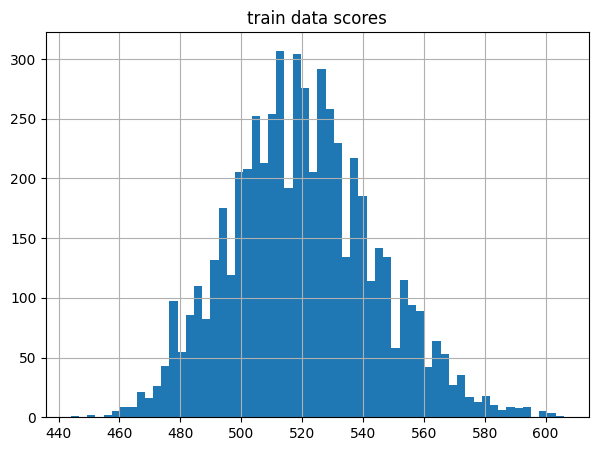

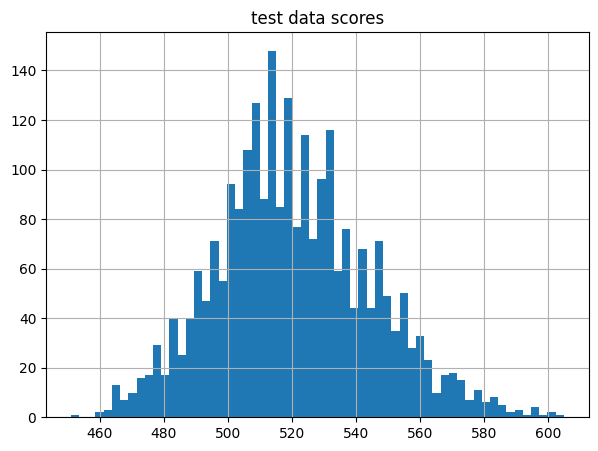

In [647]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

## 5.2 Tuning 

### Model Selection: Best Performance

### Hyperparameter Tuning

In [127]:
fcustom_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
scoring = {'AUC': 'roc_auc', 'F2': fcustom_scorer}

params = {
    'penalty' : ['l1','l2','none', 'elasticnet'], 
    'C'       : [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
}

cyclical_learning_rates = RandomizedSearchCV(LogisticRegression(
                random_state=42, 
                class_weight='balanced'),      
                param_distributions= params,
                scoring=fcustom_scorer,
                cv=10,
                n_iter=10,
                )

cyclical_learning_rates.fit(X_train, y_train)
print("Tuned Hyperparameters :", cyclical_learning_rates.best_params_)
## Best Params : {'solver': 'saga', 'penalty': 'l2', 'C': 0.001}

Tuned Hyperparameters : {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


#### Hyperparameter Tuning applied onto LR

In [128]:
# tuned_lr = LogisticRegression(
#     penalty=cyclical_learning_rates.best_params_['penalty'], 
#     C=cyclical_learning_rates.best_params_['C'], 
#     solver=cyclical_learning_rates.best_params_['solver'], 
#     class_weight='balanced', 
#     random_state=42
#     )

tuned_lr = LogisticRegression(
    penalty='l2', 
    C=0.001, 
    solver='saga', 
    class_weight='balanced', 
    random_state=42
    )


tuned_lr.fit(X_train, y_train)

new_card = sc.scorecard(
        bins,
        tuned_lr, 
        X_train.columns, 
        points0 = 600, 
        odds0 = 1/20, 
        pdo = 20,
        basepoints_eq0 = False
    )

y_pred_tuned = tuned_lr.predict(X_test)

print("\n")
print(30*"*", "Logistic Regression" , 30*"*")
tp,fp,fn,tn = confusion_matrix(y_test, y_pred).ravel()
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test, y_pred))

print("\n")
print(30*"*", "Tuned Logistic Regression" , 30*"*")
tp,fp,fn,tn = confusion_matrix(y_test, y_pred_tuned).ravel()
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,y_pred_tuned))
print("\n")
print(classification_report(y_test, y_pred_tuned))



****************************** Logistic Regression ******************************
True Positive:  1359
False Positive:  796
False Negative:  115
True Negative:  211
Accuracy:  0.6328093510681176


              precision    recall  f1-score   support

           0       0.92      0.63      0.75      2155
           1       0.21      0.65      0.32       326

    accuracy                           0.63      2481
   macro avg       0.57      0.64      0.53      2481
weighted avg       0.83      0.63      0.69      2481



****************************** Tuned Logistic Regression ******************************
True Positive:  1404
False Positive:  751
False Negative:  121
True Negative:  205
Accuracy:  0.6485288190245868


              precision    recall  f1-score   support

           0       0.92      0.65      0.76      2155
           1       0.21      0.63      0.32       326

    accuracy                           0.65      2481
   macro avg       0.57      0.64      0.54      24

### Score all Test and Train Data

array([[<Axes: title={'center': 'score'}>]], dtype=object)

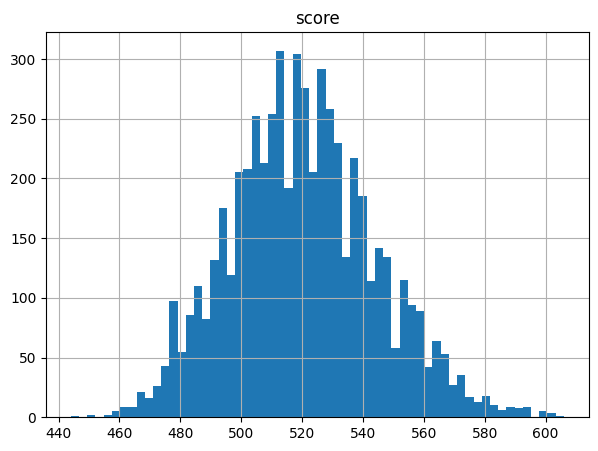

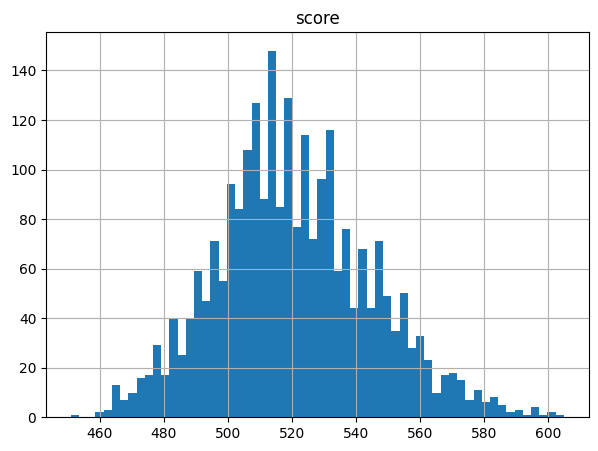

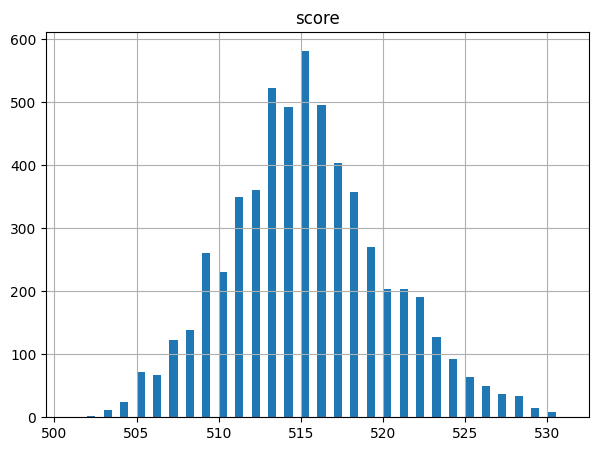

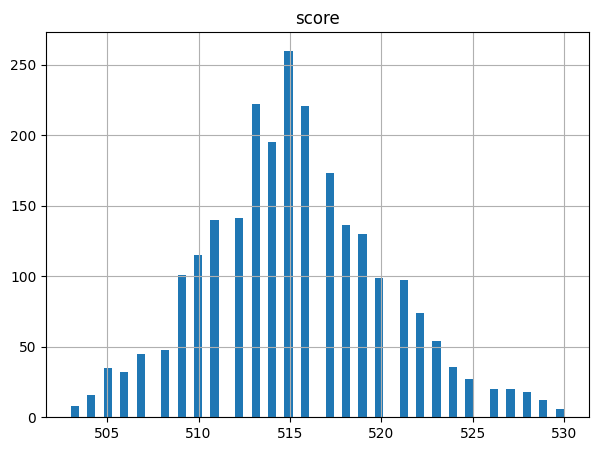

In [129]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

new_card_train_score = sc.scorecard_ply(train, new_card)
new_card_test_score = sc.scorecard_ply(test, new_card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
test_score.hist(figsize=(7,5),bins=60)
new_card_train_score.hist(figsize=(7,5),bins=60)
new_card_test_score.hist(figsize=(7,5),bins=60)


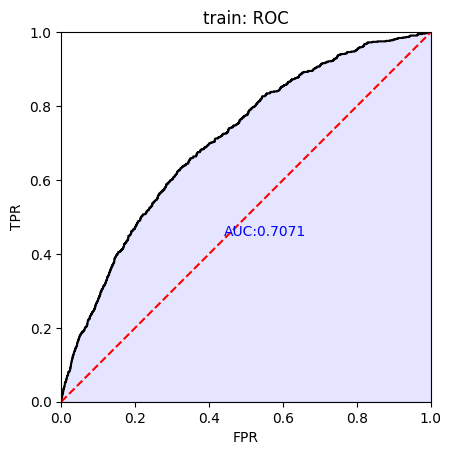

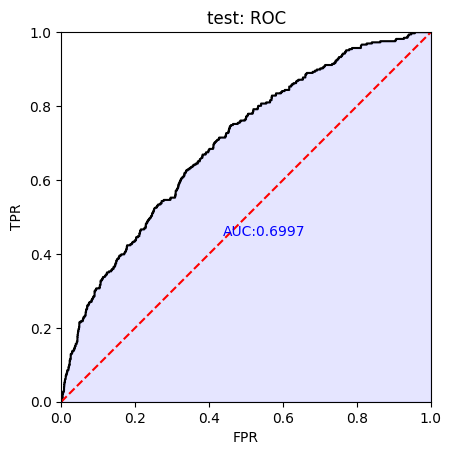

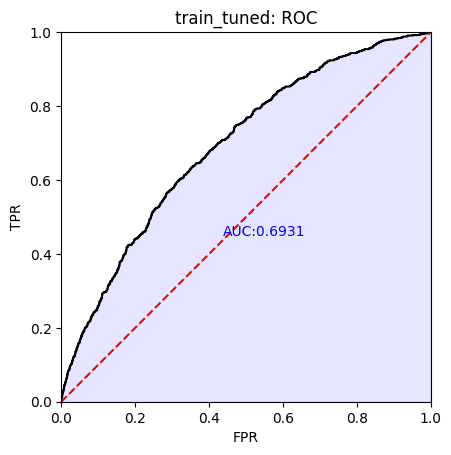

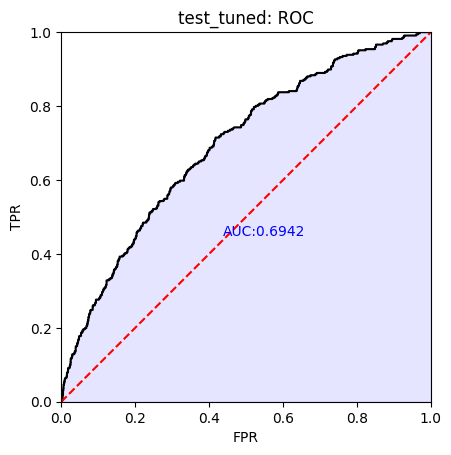

In [130]:
# evaluate the performance of the logistic regression
train_pred= lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# evaluate the performance of the logistic regression
train_tuned_pred= tuned_lr.predict_proba(X_train)[:,1]
test_tuned_pred = tuned_lr.predict_proba(X_test)[:,1]



# performance ks & roc 
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

# performance ks & roc 
train_perf_tuned = sc.perf_eva(y_train, train_tuned_pred, plot_type=['roc'], title = "train_tuned")
test_perf_tuned = sc.perf_eva(y_test, test_tuned_pred, plot_type=['roc'], title = "test_tuned")

## 5.3 Champion and Challenge Strategy
The team would like to explore the removal of external factors to see the performance of our model against the tuned Logistic Regression model we created. The following variables will be removed

| Variable       |   IV |
|----------------|-----------|
| EXT_SOURCE_1   | 0.188     |
| EXT_SOURCE_2   | 0.2287    |



In [131]:
bins3 = bins2.copy()
del(bins3["EXT_SOURCE_1"])
del(bins3["EXT_SOURCE_2"])
challenger_data = clean_merged_data.copy()
challenger_data.drop(["EXT_SOURCE_1","EXT_SOURCE_2"], axis=1, inplace=True)
challenger_data_woe = sc.woebin_ply(challenger_data,bins3)

train, test = sc.split_df(challenger_data, 'TARGET', ratio=0.7).values()
train_woe = sc.woebin_ply(train,bins3)
test_woe = sc.woebin_ply(test,bins3)

#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']
tuned_lr.fit(X_train, y_train)

challenger_pred = tuned_lr.predict(X_test)

print("\n")
print(30*"*", "Challenger Logistic Regression" , 30*"*")
tp,fp,fn,tn = confusion_matrix(y_test, challenger_pred).ravel()
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,challenger_pred))
print("\n")
print(classification_report(y_test, challenger_pred))

print("\n")
print(30*"*", "Tuned Logistic Regression" , 30*"*")
tp,fp,fn,tn = confusion_matrix(y_test, y_pred_tuned).ravel()
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,y_pred_tuned))
print("\n")
print(classification_report(y_test, y_pred_tuned))



[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


****************************** Challenger Logistic Regression ******************************
True Positive:  1240
False Positive:  915
False Negative:  122
True Negative:  204
Accuracy:  0.5820233776702942


              precision    recall  f1-score   support

           0       0.91      0.58      0.71      2155
           1       0.18      0.63      0.28       326

    accuracy                           0.58      2481
   macro avg       0.55      0.60      0.49      2481
weighted avg       0.81      0.58      0.65      2481



****************************** Tuned Logistic Regression ******************************
True Positive:  1404
False Positive:  751
False Negative:  121
True Negative:  205
Accuracy:  0.6485288190245868


              precision    recall  f1-score   support

           0       0.92      0.65      0.76      2155
           1       0.21      0.63  